In [1]:
import os
import math
import numpy as np
import pandas as pd
from ast import literal_eval
import pymc3
import itertools
import arviz as az
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
pd.options.mode.chained_assignment = None  # default='warn'

from helper_functions import *

# Pre-processing of data

In [2]:

def pre_process_input_data(dataframe):
    """
    dataframe must be pandas dataFrame with appropriate columns...
    """

    if 'Unnamed: 0' in dataframe.columns:
        dataframe.rename(columns={'Unnamed: 0': 'frame'}, inplace=True)
    else:
        dataframe.insert(0, 'frame', dataframe.index)

    # convert columns with literal_eval to not have strings anymore
    dataframe.player_pos = dataframe.player_pos.apply(lambda row: literal_eval(row))
    dataframe.visible_obstacles = dataframe.visible_obstacles.apply(lambda row: literal_eval(row))
    dataframe.visible_drift_tiles = dataframe.visible_drift_tiles.apply(lambda row: literal_eval(row))
    if 'last_walls_tile' in dataframe:
        dataframe.last_walls_tile = dataframe.last_walls_tile.apply(lambda row: literal_eval(row))

    # adjust time tag if existent
    if 'time_tag' in dataframe.columns:
        dataframe['adjusted_time_tag'] = dataframe.time_played + dataframe.time_tag

    ## annotate input data

    # input can be either None, "Right", "Left"
    rows_with_input = dataframe[~dataframe["current_input"].isnull()][["frame"]]

    # condition for start input
    cond = rows_with_input.frame - rows_with_input.frame.shift(1) >= 2

    # have =1 everywhere condition applies and =0 where not
    rows_with_input["start_input"] = np.where(cond, 1, 0)

    # flag first row also as start input (because we missed it by not taking any rows before that row due to subsetting)
    # but account for data without any input
    if len(rows_with_input) > 0:
        index = rows_with_input.iloc[0].frame
        rows_with_input.loc[index, "start_input"] = 1.0

    # label all frames of each individual input with number of input
    rows_with_input["N_input"] = (rows_with_input["start_input"] == 1).cumsum()

    # joining dataframes
    dataframe = dataframe.merge(rows_with_input, on="frame", how='left')

    ## annotate input switch (strategy change?)
    rows_with_input_direction = dataframe[dataframe["start_input"] == 1][["frame", "current_input"]]

    # condition for input switch
    cond = rows_with_input_direction.current_input != rows_with_input_direction.current_input.shift(1)

    # have =1 everywhere condition applies and =0 where not
    rows_with_input_direction["input_change"] = np.where(cond, 1, 0)
    # drop current_input column for better merge in next step
    rows_with_input_direction.drop(columns="current_input", axis=1, inplace=True)

    # joining dataframes
    dataframe = dataframe.merge(rows_with_input_direction, on="frame", how='left')

    # include input_duration for every button press
    try:
        dataframe['input_duration'] = np.nan
        dataframe['input_duration'] = dataframe.groupby('N_input')['time_played'].transform(lambda x: max(x) - min(x))
    except ValueError:
        print("ValueError: Length mismatch: Expected axis has X elements, new values have Y elements")
    
    # flagging drift onset (and second drift onset)
    # condition for drift onset
    cond = (dataframe["visible_drift_tiles"].str.len() != 0) & (
            dataframe["visible_drift_tiles"].shift(1).str.len() == 0)

    # have =1 everywhere condition applies and =0 where not
    dataframe["drift_tile_onset"] = np.where(cond, 1, 0)

    # condition for multiple drift tiles on screen
    cond = (dataframe["visible_drift_tiles"].shift(1).str.len() != 0) & (
            dataframe["visible_drift_tiles"].str.len() > dataframe["visible_drift_tiles"].shift(1).str.len())

    # have =1 everywhere condition applies and =0 where not
    dataframe["second_drift_tile_onset"] = np.where(cond, 1, 0)

    return dataframe

In [3]:
#data = pd.read_csv('input_data/demo_output_00.csv', index_col=False)
data = pd.read_csv('input_data/pilot4_output_00.csv', index_col=False) 
data = pre_process_input_data(data)
#data

In [4]:
#data = pd.read_csv('input_data/demo_output_00.csv', index_col=False)
#data = pre_process_input_data(data)
#data

## Deviations from predefined time step (by FPS) due to internal computations delaying completion of frame

In [5]:
# exemplary data 
data = pd.read_csv('input_data/pilot4_output_00.csv', index_col=False) 
data = pre_process_input_data(data)

In [6]:
data['time_step'] = data.time_played.shift(-1) - data.time_played
data.time_step

0       0.015571
1       0.016747
2       0.016014
3       0.016950
4       0.020624
          ...   
1544    0.016557
1545    0.016522
1546    0.016946
1547    2.142221
1548         NaN
Name: time_step, Length: 1549, dtype: float64

<AxesSubplot:>

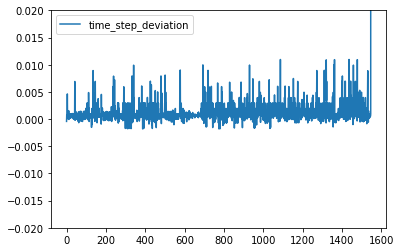

In [7]:
data['time_step_deviation'] = data.time_step - 0.016
data.plot(y='time_step_deviation', ylim=[-0.02, 0.02])

In [8]:
max(np.abs(data.time_step_deviation[0:-2]))
np.mean(np.abs(data.time_step_deviation[0:-2]))

0.0013975252978787828

In [9]:
data['abs_time_step_deviation'] = abs(data['time_step_deviation'])

<AxesSubplot:>

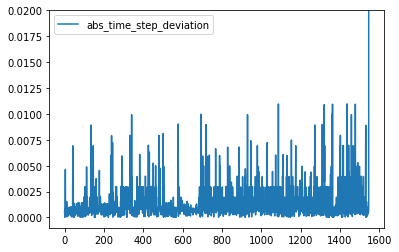

In [10]:
data.plot(y='abs_time_step_deviation', ylim=[-0.001, 0.02])

## Variables of interest

In [11]:
seconds_played = data.iloc[-2].time_played  # second last row because last row is written to df AFTER SoC response given which may take time
seconds_played

26.69550728797913

In [12]:
SoC = data.iloc[-1].SoC
SoC

3.0

In [13]:
crashed = data.iloc[-1].collision
crashed

False

# Eye-tracking data

In [14]:
def calc_fixation_duration(fixation_rows):
    '''
    Need to be given pandas dataframe grouped by N_fixation.
    Dataframe must have columns of TimeTag (VPixx generated data).
    Returned dataframe now holds fixation duration.
    '''
    
    fixation_rows.fixation_duration = fixation_rows.iloc[-1].TimeTag - fixation_rows.iloc[0].TimeTag
    
    return fixation_rows

In [15]:
def calc_saccade_direction(saccade_rows):
    '''
    Need to be given pandas dataframe grouped by N_saccade. 
    Dataframe must have columns of eye positions (e.g. LeftEyeX) and saccade_direction.
    Returned dataframe now holds direction vector of saccade in every row in column saccade direction.
    '''
    
    # x-direction
    left_eye_x_direction = saccade_rows.iloc[-1].LeftEyeX - saccade_rows.iloc[0].LeftEyeX
    right_eye_x_direction = saccade_rows.iloc[-1].RightEyeX - saccade_rows.iloc[0].RightEyeX
    x_direction = (left_eye_x_direction + right_eye_x_direction)/2
    
    # y-direction
    left_eye_y_direction = saccade_rows.iloc[-1].LeftEyeY - saccade_rows.iloc[0].LeftEyeY
    right_eye_y_direction = saccade_rows.iloc[-1].RightEyeY - saccade_rows.iloc[0].RightEyeY
    y_direction = (left_eye_y_direction + right_eye_y_direction)/2
    
    saccade_rows.saccade_direction_x = saccade_rows.apply(lambda x: x_direction, axis=1)
    saccade_rows.saccade_direction_y = saccade_rows.apply(lambda x: y_direction, axis=1)
    saccade_rows.saccade_amplitude = saccade_rows.apply(lambda x: np.sqrt(np.power(x_direction, 2) + np.power(y_direction, 2)), axis=1)
    
    return saccade_rows

In [16]:
screen_width_in_mm=595
screen_height_in_mm=335
pixels_width=1920
pixels_height=1080
distance_to_screen_in_mm=770

#np.arctan((300*0.27)/700)
pixels_in_mm = ((pixels_width / screen_width_in_mm) + (pixels_height / screen_height_in_mm)) / 2

saccade_amplitude_in_pixel = 295.332133
saccade_amplitude_in_mm = 295.332133/pixels_in_mm

out = np.arctan((saccade_amplitude_in_mm)/distance_to_screen_in_mm)
print(out)

0.11835964591418666


In [17]:
np.arctan((300*0.27)/700)  # 6.6 degrees

0.11520193208763194

In [18]:
# annotate eye_tracking data

def pre_process_eye_data(eye_data, screen_width_in_mm=595, screen_height_in_mm=335, pixels_width=1920, pixels_height=1080, distance_to_screen_in_mm=770):
    
    # calc how many pixels are within 1 mm on screen
    pixels_in_mm = ((pixels_width / screen_width_in_mm) + (pixels_height / screen_height_in_mm)) / 2
    
    # adjust time tag to start at 0
    eye_data["time_tag"] = eye_data.TimeTag - eye_data.TimeTag[0]
    
    # annotate binocular fixations
    eye_data["Fixation"] = eye_data.LeftEyeFixationFlag + eye_data.RightEyeFixationFlag
    ## eliminate simultaneous blink and fixation (setting fixation to 0)
    eye_data.Fixation.loc[eye_data.LeftBlink > 0.0] = 0.0
    eye_data.Fixation.loc[eye_data.RightBlink > 0.0] = 0.0
    eye_data.Fixation[eye_data.Fixation > 1] = 1.0
    
    # condition for initiating fixation
    cond = (eye_data.Fixation >= 1.0) & (eye_data.Fixation.shift(1) == 0.0)
    
    # have =1 everywhere condition applies and =0 where not
    eye_data["fixationOnset"] = np.where(cond, 1, 0)
    
    # insert N_fixation - counting up fixations
    eye_data["N_fixation"] = (eye_data["fixationOnset"] == 1).cumsum()
    eye_data.loc[eye_data.Fixation < 1.0, "N_fixation"] = np.nan  # have NaN everywhere where there is no fixation
    
    # annotate fixation duration
    eye_data["fixation_duration"] = np.nan
    eye_data = eye_data.groupby("N_fixation", dropna=False).apply(calc_fixation_duration)
    
    # sum up left and right eye positions to converging eye position in x and y dimension
    eye_data["converging_eye_x"] = eye_data.apply(lambda row: (row.LeftEyeX + row.RightEyeX) / 2, axis=1)
    eye_data["converging_eye_y"] = eye_data.apply(lambda row: (row.LeftEyeY + row.RightEyeY) / 2, axis=1)
    
    # adjust eye-tracking coordinates by fixed factor
    eye_data["converging_eye_x_adjusted"] = eye_data.converging_eye_x + 960
    eye_data["converging_eye_y_adjusted"] = eye_data.converging_eye_y.apply(lambda x: x*(-1)+540)
    
    # annotate fixations exploring the scene
    cond = (eye_data["fixationOnset"] == 1.0) & (eye_data["converging_eye_y_adjusted"] > 640)
    # have =1 everywhere condition applies and =0 where not
    eye_data["exploring_fixation"] = np.where(cond, 1, 0)

    
    # flag fixations and saccades aiming within game boarders
    #in (edge*scaling, (edge+observation_space_x)*scaling)
    
    # annotate binocular saccades
    eye_data["Saccade"] = eye_data.LeftEyeSaccadeFlag + eye_data.RightEyeSaccadeFlag
    ## eliminate simultaneous blink and saccades (setting saccade to 0)
    eye_data.Saccade.loc[eye_data.LeftBlink > 0.0] = 0.0
    eye_data.Saccade.loc[eye_data.RightBlink > 0.0] = 0.0
    eye_data.Saccade[eye_data.Saccade > 1] = 1.0
    
    # condition for initiating saccade
    cond = (eye_data.Saccade >= 1.0) & (eye_data.Saccade.shift(1) == 0.0)

    # have =1 everywhere condition applies and =0 where not
    eye_data["saccadeOnset"] = np.where(cond, 1, 0)
    
    # insert N_saccade - counting up saccades
    eye_data["N_saccade"] = (eye_data["saccadeOnset"] == 1).cumsum()
    eye_data.loc[eye_data.Saccade < 1.0, "N_saccade"] = np.nan  # have NaN everywhere where there is no saccade
    
    # insert saccade direction column
    eye_data["saccade_direction_x"] = np.nan
    eye_data["saccade_direction_y"] = np.nan
    eye_data["saccade_amplitude"] = np.nan
    out = eye_data.groupby("N_saccade", dropna=False).apply(calc_saccade_direction)
    
    # convert saccade amplitude from pixels to visual angle (°)
    #eye_data["saccade_amplitude_visual_angle"] = 
    
    # set saccade direction to NaN everywhere where there is no saccade
    out.loc[eye_data.Saccade < 1.0, ["saccade_direction_x", "saccade_direction_y"]] = np.nan
    
    return out

In [19]:
exp_data = pre_process_eye_data(pd.read_csv("experimental_data/AR02AA/eye_data/AR02AA_eye_tracking_output_1FN_01.csv", index_col=False))
exp_data

TimeTag   LeftEyeX   LeftEyeY  LeftPupilDiameter   RightEyeX  \
0      28035.1235  69.678947  53.448730          63.339844  195.942261   
1      28035.1240  69.340508  54.702179          63.230469  196.022034   
2      28035.1245  68.634209  55.905762          63.148438  196.890900   
3      28035.1250  68.089836  56.967407          63.011719  196.694275   
4      28035.1255  67.075340  57.276398          62.933594  196.109314   
...           ...        ...        ...                ...         ...   
59470  28064.8585        NaN        NaN        9999.000000         NaN   
59471  28064.8590        NaN        NaN        9999.000000         NaN   
59472  28064.8595        NaN        NaN        9999.000000         NaN   
59473  28064.8600        NaN        NaN        9999.000000         NaN   
59474  28064.8605        NaN        NaN        9999.000000         NaN   

        RightEyeY  RightPupilDiameter   DigitalIn  LeftBlink  RightBlink  ...  \
0     -130.926575           68.667969  16777215.0        0.0         0.0  ...   
1     -131.305725           68.699219  16777215.0        0.0         0.0  ...   
2     -131.564514           68.742188  16777215.0        0.0         0.0  ...   
3     -131.536804           68.746094  16777215.0        0.0         0.0  ...   
4     -131.601501           68.703125  16777215.0        0.0         0.0  ...   
...           ...                 ...         ...        ...         ...  ...   
59470         NaN         9999.000000  16777215.0        1.0         1.0  ...   
59471         NaN         9999.000000  16777215.0        1.0         1.0  ...   
59472         NaN         9999.000000  16777215.0        1.0         1.0  ...   
59473         NaN         9999.000000  16777215.0        1.0         1.0  ...   
59474         NaN         9999.000000  16777215.0        1.0         1.0  ...   

       converging_eye_y  converging_eye_x_adjusted  converging_eye_y_adjusted  \
0            -38.738922                1092.810604                 578.738922   
1            -38.301773                1092.681271                 578.301773   
2            -37.829376                1092.762554                 577.829376   
3            -37.284698                1092.392056                 577.284698   
4            -37.162552                1091.592327                 577.162552   
...                 ...                        ...                        ...   
59470               NaN                        NaN                        NaN   
59471               NaN                        NaN                        NaN   
59472               NaN                        NaN                        NaN   
59473               NaN                        NaN                        NaN   
59474               NaN                        NaN                        NaN   

       exploring_fixation  Saccade  saccadeOnset  N_saccade  \
0                       0      0.0             0        NaN   
1                       0      0.0             0        NaN   
2                       0      0.0             0        NaN   
3                       0      0.0             0        NaN   
4                       0      0.0             0        NaN   
...                   ...      ...           ...        ...   
59470                   0      0.0             0        NaN   
59471                   0      0.0             0        NaN   
59472                   0      0.0             0        NaN   
59473                   0      0.0             0        NaN   
59474                   0      0.0             0        NaN   

       saccade_direction_x  saccade_direction_y  saccade_amplitude  
0                      NaN                  NaN                NaN  
1                      NaN                  NaN                NaN  
2                      NaN                  NaN                NaN  
3                      NaN                  NaN                NaN  
4                      NaN                  NaN                NaN  
... 

In [20]:
exp_data[exp_data.saccadeOnset == 1]

TimeTag    LeftEyeX    LeftEyeY  LeftPupilDiameter   RightEyeX  \
740    28035.4935   -0.536229   91.597748          57.773438  164.717560   
1095   28035.6710 -196.584534  339.471436          53.945312 -165.383820   
3724   28036.9855   52.224789  156.006836          58.492188  171.238617   
4274   28037.2605  139.037659   54.919373          59.785156  260.676300   
5155   28037.7010   43.420559   88.806091          61.750000  173.588013   
...           ...         ...         ...                ...         ...   
50959  28060.6030  -27.284336  141.902161          58.339844   84.120148   
51409  28060.8280   -2.175053  148.049988          57.941406  111.596497   
51436  28060.8415  -19.903812  204.704468          58.218750   34.833984   
54465  28062.3560   60.238216  201.130188          66.417969  123.596741   
55032  28062.6395  123.254997  207.395630          63.605469  298.939026   

        RightEyeY  RightPupilDiameter   DigitalIn  LeftBlink  RightBlink  ...  \
740    -69.199066           61.328125  16777215.0        0.0         0.0  ...   
1095   523.516296           56.367188  16777215.0        0.0         0.0  ...   
3724    82.697052           60.175781  16777215.0        0.0         0.0  ...   
4274  -126.952942           63.261719  16777215.0        0.0         0.0  ...   
5155   -42.991455           63.468750  16777215.0        0.0         0.0  ...   
...           ...                 ...         ...        ...         ...  ...   
50959   12.250977           60.664062  16777215.0        0.0         0.0  ...   
51409   16.500366           60.957031  16777215.0        0.0         0.0  ...   
51436  178.755981           62.074219  16777215.0        0.0         0.0  ...   
54465  188.083252           70.984375  16777215.0        0.0         0.0  ...   
55032   71.714630           70.511719  16777215.0        0.0         0.0  ...   

       converging_eye_y  converging_eye_x_adjusted  converging_eye_y_adjusted  \
740           11.199341                1042.090666                 528.800659   
1095         431.493866                 779.015823                 108.506134   
3724         119.351944                1071.731703                 420.648056   
4274         -36.016785                1159.856979                 576.016785   
5155          22.907318                1068.504286                 517.092682   
...                 ...                        ...                        ...   
50959         77.076569                 988.417906                 462.923431   
51409         82.275177                1014.710722                 457.724823   
51436        191.730225                 967.465086                 348.269775   
54465        194.606720                1051.917479                 345.393280   
55032        139.555130                1171.097012                 400.444870   

       exploring_fixation  Saccade  saccadeOnset  N_saccade  \
740                     0      1.0             1        1.0   
1095                    0      1.0             1        2.0   
3724                    0      1.0             1        3.0   
4274                    0      1.0             1        4.0   
5155                    0      1.0             1        5.0   
...                   ...      ...           ...        ...   
50959                   0      1.0             1       72.0   
51409                   0      1.0             1       73.0   
51436                   0      1.0             1       74.0   
54465                   0      1.0             1       75.0   
55032                   0      1.0             1       76.0   

       saccade_direction_x  saccade_direction_y  saccade_amplitude  
740            -264.454420           286.185272         389.664151  
1095              3.405853            23.980499          24.221152  
3724            220.578173          -175.658066         281.976039  
4274            -66.317921            33.202271          74.165068  
5155             65.266447           -68.381775  

## pilot 4 run 04

In [21]:
eye_data = pd.read_csv('eye_data/pilot4_eye_tracking_output_04.csv', index_col=False)
eye_data = pre_process_eye_data(eye_data)
#eye_data

# Combining KDEs of input and eye tracking data

In [22]:
def point_estimate(data):
    """
    function for estimating point of maximum for kde
    """
    try:
        kde = st.gaussian_kde(data)  # gaussian kernel
        n_samples = 1000  # arbitrarily high number of samples
        samples = np.linspace(min(data), max(data), n_samples)  # sampling
        probs = kde.evaluate(samples)
        point_estimate_y = max(probs)
        point_estimate_index = probs.argmax()
        point_estimate_x = samples[point_estimate_index]
        hdi = az.hdi(samples,
                     hdi_prob=0.25)  # compute hpdi (I went for the smallest interval which contains 25% of the mass)

        return point_estimate_x, point_estimate_y, hdi[0], hdi[1]
    except np.linalg.LinAlgError:
        print("SingularMatrixError; numpy.linalg.LinAlgError: singular matrix; no variance in data")

        return data.iloc[0], data.iloc[0], data.iloc[0], data.iloc[0]

In [23]:
def plot_kde_combined(input_data, eye_data, safe_plot=True, path_to_save_folder=f"{os.getcwd()}/plots/kde_plots_event_distribution/"):
    
    # reducing data to only respective events of interest
    inputs = input_data[input_data["start_input"] == 1.0]
    saccades = eye_data[eye_data["saccadeOnset"] == 1.0]
    
    # extract level features
    level = inputs.iloc[0].trial
    drift_enabled = inputs.iloc[0].drift_enabled
    input_noise = inputs.iloc[0].input_noise_magnitude
    
    # define arrays of time tags for respective data
    input_data_array = np.asarray(inputs.time_played)

    # define point dataframes
    input_data_points = {'x': input_data_array, 'y': [0]*len(input_data_array)}
    input_data_points = pd.DataFrame(data=input_data_points)
    # dataframe for eye_data points (pro & regressive) is generated down below...

    # compute hpdi (I went for the smallest interval which contains 25% of the mass)
    input_data_hpdi_bounds = az.hdi(input_data_array, 0.25)
    
    
    # plot boundaries:
    lbound = 0
    ubound = input_data.iloc[-2].time_played  # second last row because last row is written to df AFTER SoC response given which may take time

    
    # instatiate KDEs
    kde_init = np.linspace(lbound, ubound, 100)

    input_data_kde = st.gaussian_kde(input_data_array)

    
    # Grid
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f"Densities of events for level {level} (drift enabled = {drift_enabled}, input noise = {input_noise}, crashed = {input_data.iloc[-1].collision})", fontdict={"fontweight": "bold"})

    
    # axis labels
    ax.set_xlabel("Time played")
    ax.set_ylabel("Density")

    ax.set_xlim([lbound, ubound])

    xaxis = np.linspace(lbound, ubound, 10)
    ax.set_xticks(xaxis)

    
    # Plotting
    colors = ["crimson", "limegreen", "royalblue"]

    ax.plot(kde_init, input_data_kde(kde_init), color=colors[0], label='keyboard inputs')
    #ax.fill_between(kde_init, input_data_kde(kde_init), step="mid", alpha=0.3, color=colors[0])
    ax.scatter(input_data_points.x, input_data_points.y, marker=".", color=colors[0])
    
    y_max = ax.get_ylim()[1]  # 0: bottom; 1: top
    

    # point estimates and HPDIs:
    point_estimate_input_data = point_estimate(inputs.time_played)
    #ax.axvspan(point_estimate_input_data[2], point_estimate_input_data[3], alpha=0.3, color=colors[0])
    plt.vlines(point_estimate_input_data[0], ymin=0, ymax=point_estimate_input_data[1], color=colors[0])

    # eye-movement behavior 
    # progressive saccades
    progressive_saccades = saccades.loc[saccades["saccade_direction_y"] < 0]
    progressive_eye_data_array = np.asarray(progressive_saccades.time_tag)

    progressive_eye_data_hpdi_bounds = az.hdi(progressive_eye_data_array, 0.25)
    progressive_eye_data_kde = st.gaussian_kde(progressive_eye_data_array)
    ax.plot(kde_init, progressive_eye_data_kde(kde_init), color=colors[1], label='progressive eye movements')

    progressive_eye_data_points = {'x': progressive_eye_data_array, 'y': [y_max/95]*len(progressive_eye_data_array)}
    progressive_eye_data_points = pd.DataFrame(data=progressive_eye_data_points)
    ax.scatter(progressive_eye_data_points.x, progressive_eye_data_points.y, marker=".", color=colors[1])

    point_estimate_progressive_eye_data = point_estimate(progressive_saccades.time_tag)
    plt.vlines(point_estimate_progressive_eye_data[0], ymin=0, ymax=point_estimate_progressive_eye_data[1], color=colors[1])
    
    # regressive saccades
    regressive_saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
    regressive_eye_data_array = np.asarray(regressive_saccades.time_tag)

    regressive_eye_data_hpdi_bounds = az.hdi(regressive_eye_data_array, 0.25)
    regressive_eye_data_kde = st.gaussian_kde(regressive_eye_data_array)
    ax.plot(kde_init, regressive_eye_data_kde(kde_init), color=colors[2], label='regressive eye movements')

    regressive_eye_data_points = {'x': regressive_eye_data_array, 'y': [y_max/95]*len(regressive_eye_data_array)}
    regressive_eye_data_points = pd.DataFrame(data=regressive_eye_data_points)
    ax.scatter(regressive_eye_data_points.x, regressive_eye_data_points.y, marker=".", color=colors[2])

    point_estimate_regressive_eye_data = point_estimate(regressive_saccades.time_tag)
    plt.vlines(point_estimate_regressive_eye_data[0], ymin=0, ymax=point_estimate_regressive_eye_data[1], color=colors[2])
    
    ax.legend()

    if safe_plot:
        plt.savefig(f"{path_to_save_folder}Event_densities_level_{level}_drift_enabled_{drift_enabled}_input_noise_{input_noise}", dpi=300)
        plt.close()

In [ ]:
input_data = pre_process_input_data(pd.read_csv(f'experimental_data/AE07EM1/data/AE07EM1_output_6FW_done_37.csv', index_col=False))
eye_data = pre_process_eye_data(pd.read_csv(f'experimental_data/AE07EM1/eye_data/AE07EM1_eye_tracking_output_6FW_37.csv', index_col=False))

plot_kde_combined(input_data=input_data, eye_data=eye_data, safe_plot=False)

# Eyes fixating on ship

In [ ]:
code = "2FS_02"
only_ship_data = pd.read_csv(f'eye_data/only_ship_eye_tracking_output_{code}.csv', index_col=False)
only_ship_data = pre_process_eye_data(only_ship_data)

fixations = only_ship_data[only_ship_data["Fixation"] == 1.0]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"{code}", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("observation space x")
ax.set_ylabel("observation space y")

ax.set_xlim([-120, 120])
ax.set_ylim([-600, 600])

#plt.gca().invert_yaxis()

# Plotting
colors = ["crimson", "limegreen"]

#ax.scatter(fixations.LeftEyeX, fixations.LeftEyeY, marker=".", color=colors[0], alpha=0.3)
#ax.scatter(fixations.RightEyeX, fixations.RightEyeY, marker=".", color=colors[1], alpha=0.3)

heatmap_left = sns.kdeplot(x=fixations.LeftEyeX, 
                           y=fixations.LeftEyeY, 
                           cmap="Reds",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

heatmap_right = sns.kdeplot(x=fixations.RightEyeX, 
                           y=fixations.RightEyeY, 
                           cmap="Greens",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

y_coord = point_estimate(fixations.converging_eye_y)[0]
ax.axhline(y_coord, color="lightskyblue")
x_coord = point_estimate(fixations.converging_eye_x)[0]
ax.axvline(x_coord, color="lightskyblue")

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="left eye"),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="right eye"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="converging eyes")]
ax.legend(handles=handles)

In [ ]:
code = "3FW_01"
only_ship_data = pd.read_csv(f'eye_data/only_ship_eye_tracking_output_{code}.csv', index_col=False)
only_ship_data = pre_process_eye_data(only_ship_data)

fixations = only_ship_data[only_ship_data["Fixation"] == 1.0]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"{code}", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("observation space x")
ax.set_ylabel("observation space y")

ax.set_xlim([-120, 120])
ax.set_ylim([-600, 600])

#plt.gca().invert_yaxis()

# Plotting
colors = ["crimson", "limegreen"]

#ax.scatter(fixations.LeftEyeX, fixations.LeftEyeY, marker=".", color=colors[0], alpha=0.3)
#ax.scatter(fixations.RightEyeX, fixations.RightEyeY, marker=".", color=colors[1], alpha=0.3)

heatmap_left = sns.kdeplot(x=fixations.LeftEyeX, 
                           y=fixations.LeftEyeY, 
                           cmap="Reds",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

heatmap_right = sns.kdeplot(x=fixations.RightEyeX, 
                           y=fixations.RightEyeY, 
                           cmap="Greens",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

y_coord = point_estimate(fixations.converging_eye_y)[0]
ax.axhline(y_coord, color="lightskyblue")
x_coord = point_estimate(fixations.converging_eye_x)[0]
ax.axvline(x_coord, color="lightskyblue")

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="left eye"),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="right eye"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="converging eyes")]
ax.legend(handles=handles)

In [ ]:
code = "4FN_00"
only_ship_data = pd.read_csv(f'eye_data/only_ship_eye_tracking_output_{code}.csv', index_col=False)
only_ship_data = pre_process_eye_data(only_ship_data)

fixations = only_ship_data[only_ship_data["Fixation"] == 1.0]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"{code}", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("observation space x")
ax.set_ylabel("observation space y")

ax.set_xlim([-120, 120])
ax.set_ylim([-600, 600])

#plt.gca().invert_yaxis()

# Plotting
colors = ["crimson", "limegreen"]

#ax.scatter(fixations.LeftEyeX, fixations.LeftEyeY, marker=".", color=colors[0], alpha=0.3)
#ax.scatter(fixations.RightEyeX, fixations.RightEyeY, marker=".", color=colors[1], alpha=0.3)

heatmap_left = sns.kdeplot(x=fixations.LeftEyeX, 
                           y=fixations.LeftEyeY, 
                           cmap="Reds",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

heatmap_right = sns.kdeplot(x=fixations.RightEyeX, 
                           y=fixations.RightEyeY, 
                           cmap="Greens",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

y_coord = point_estimate(fixations.converging_eye_y)[0]
ax.axhline(y_coord, color="lightskyblue")
x_coord = point_estimate(fixations.converging_eye_x)[0]
ax.axvline(x_coord, color="lightskyblue")

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="left eye"),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="right eye"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="converging eyes")]
ax.legend(handles=handles)

# Finding runs that can be compared (same trial, same drift, different input_noise, but no crash)

In [27]:
code="pilot4"

N_run = 43

levels = []
crashs = []
drifts = []
input_noise_magnitudes = []

for n_run in np.arange(N_run+1):
    input_data = pd.read_csv(f'input_data/{code}_output_{n_run:0>2}.csv', index_col=False)
    input_data = pre_process_input_data(input_data)
    levels.append(input_data.iloc[-1].trial)
    crashs.append(input_data.iloc[-1].collision)
    drifts.append(input_data.iloc[-1].drift_enabled)
    input_noise_magnitudes.append(input_data.iloc[-1].input_noise_magnitude)
    
trial_config = pd.DataFrame(columns=['level', 'crash', 'drift', 'input_noise'])
trial_config.level = levels
trial_config.crash = crashs
trial_config.drift = drifts
trial_config.input_noise = input_noise_magnitudes

trial_config

level  crash  drift input_noise
0       3  False   True      strong
1       4  False   True      strong
2       6   True   True        weak
3       6  False  False         NaN
4       5  False   True         NaN
5       3  False   True         NaN
6       2  False   True      strong
7       6   True   True      strong
8       6   True   True         NaN
9       1  False  False        weak
10      2  False   True         NaN
11      4  False  False      strong
12      2  False  False      strong
13      1  False  False         NaN
14      3  False  False        weak
15      5  False   True      strong
16      2  False   True        weak
17      5   True   True        weak
18      5  False  False      strong
19      4  False  False        weak
20      4  False   True         NaN
21      2  False  False         NaN
22      4  False   True        weak
23      6   True   True      strong
24      1  False  False      strong
25      3  False  False         NaN
26      1  False   True        weak
27      5   True  False        weak
28      1  False   True         NaN
29      1  False   True      strong
30      6   True   True        weak
31      6  False   True        weak
32      6   True   True         NaN
33      3  False   True        weak
34      2  False  False        weak
35      5  False  False        weak
36      6   True   True      strong
37      6  False  False      strong
38      6  False   True         NaN
39      3  False  False      strong
40      4  False  False         NaN
41      6  False  False        weak
42      5  False  False         NaN
43      5  False   True        weak

In [28]:
trial_config_no_crashs = trial_config[trial_config.crash == False]

grouped = trial_config_no_crashs.groupby(["level", "drift"])
for name_of_the_group, group in grouped:
    print(name_of_the_group)
    print(group)

(1, False)
    level  crash  drift input_noise
9       1  False  False        weak
13      1  False  False         NaN
24      1  False  False      strong
(1, True)
    level  crash  drift input_noise
26      1  False   True        weak
28      1  False   True         NaN
29      1  False   True      strong
(2, False)
    level  crash  drift input_noise
12      2  False  False      strong
21      2  False  False         NaN
34      2  False  False        weak
(2, True)
    level  crash  drift input_noise
6       2  False   True      strong
10      2  False   True         NaN
16      2  False   True        weak
(3, False)
    level  crash  drift input_noise
14      3  False  False        weak
25      3  False  False         NaN
39      3  False  False      strong
(3, True)
    level  crash  drift input_noise
0       3  False   True      strong
5       3  False   True         NaN
33      3  False   True        weak
(4, False)
    level  crash  drift input_noise
11      4  False  False   

In [29]:
trial_config_combinations = [[13, 9, 24], [28, 26, 29], [21, 34, 12], [10, 16, 6], [25, 14, 39], [5, 33, 0], [40, 19, 11], [20, 1, 22], [42, 35, 18], [4, 43, 15], [3, 41, 37], [38, 31, 36]]
# 3rd trial in last entry is an unsuccessfull run for level 6, drift_enabled=True, input_noise=strong
len(trial_config_combinations)

12

In [30]:
for combination in trial_config_combinations:
    print(combination)

[13, 9, 24]
[28, 26, 29]
[21, 34, 12]
[10, 16, 6]
[25, 14, 39]
[5, 33, 0]
[40, 19, 11]
[20, 1, 22]
[42, 35, 18]
[4, 43, 15]
[3, 41, 37]
[38, 31, 36]


# Eye resting position (differences in y dimension)

In [8]:
def plot_fixation_location_kde(eye_data_none, eye_data_weak, eye_data_strong, level=1, drift_enabled=False, scaling=18, edge=34, observation_space_x=40, observation_space_y=60, bottom_edge=15, exploring_fixations=False, safe_plot=False, path_to_save_folder=f"{os.getcwd()}/plots/kde_plots_fixation_locations/"):

    """
    :param eye_data_none: data of onput noise = none
    :param eye_data_weak: data of onput noise = weak
    :param eye_data_strong: data of onput noise = strong
    :param level: level played
    :param drift_enabled: True vs. False
    :param safe_plot: True vs. False - determines whether plots are saved or not
    :param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
    IMPORTANT: The function will not raise an error if the runs aren't of the same level and drift condition. It will only consider level and drift passed for labeling
    """
    
    if exploring_fixations:
        fixation_type = "exploring_fixations"
    else:
        fixation_type = "resting_fixations"
    
    # initiate plot 
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))  # 3 subplots
    fig.suptitle(f"fixation locations KDE - {fixation_type}; level {level}, drift_enabled = {drift_enabled}")

    fig.supxlabel("observation space x")
    fig.supylabel("observation space y")

    # Plotting
    colors = ["crimson", "limegreen", "lightskyblue"]
    color_maps = ["Reds", "Greens", "Blues"]
    input_noise_magnitude = ["none", "weak", "strong"]
    counter = 0

    for eye_data, ax in zip([eye_data_none, eye_data_weak, eye_data_strong], axs.ravel()):

        # axis labels
        ax.set_xlabel(" ")
        ax.set_ylabel(" ")
        
        x_bounds = [edge*scaling, (edge+observation_space_x)*scaling]
        y_bounds = [0, (observation_space_y - bottom_edge)*scaling]

        ax.set_xlim([-300, 300])
        ax.set_ylim([-600, 600])
        
        # subset target fixations
        if exploring_fixations:
            target_fixations = eye_data[(eye_data["fixationOnset"] == 1.0) & (eye_data["exploring_fixation"] == 1)]
        else:
            target_fixations = eye_data[(eye_data["fixationOnset"] == 1.0) & (eye_data["exploring_fixation"] == 0)]

        
        # check for fixation within game boarders
        target_fixations = target_fixations[target_fixations["converging_eye_x_adjusted"].between(x_bounds[0], x_bounds[1])]

        heatmap = sns.kdeplot(x=target_fixations.converging_eye_x,
                              y=target_fixations.converging_eye_y,
                              cmap=color_maps[counter],
                              shade=True,
                              alpha=0.9,
                              bw_adjust=0.4,
                              ax=ax)
        
        if not exploring_fixations:
            y_coord = point_estimate(target_fixations.converging_eye_y)[0]
            ax.axhline(y_coord, color=colors[counter])
            x_coord = point_estimate(target_fixations.converging_eye_x)[0]
            ax.axvline(x_coord, color=colors[counter])

        counter += 1

    handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=input_noise_magnitude[0]),
               mpatches.Patch(facecolor=plt.cm.Greens(100), label=input_noise_magnitude[1]),
               mpatches.Patch(facecolor=plt.cm.Blues(100), label=input_noise_magnitude[2])]
    fig.legend(handles=handles, loc='center right')
    
    if safe_plot:
        plt.savefig(f"{path_to_save_folder}fixation_location_kde_{fixation_type}_level_{level}_drift_enabled_{drift_enabled}", dpi=300)
        #plt.close()

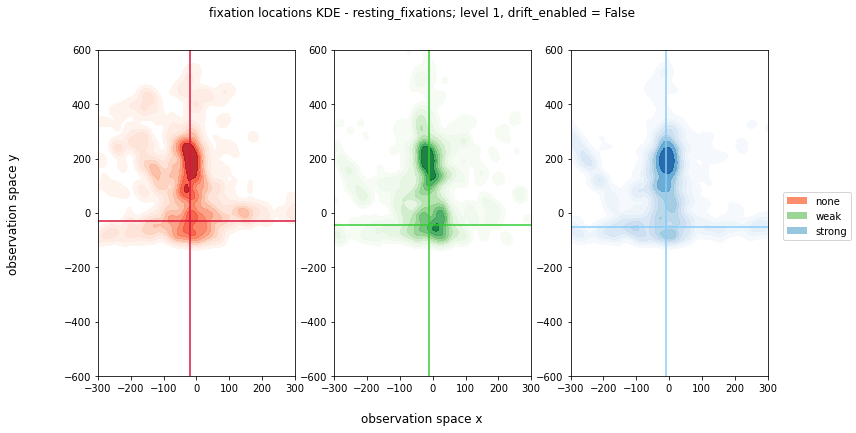

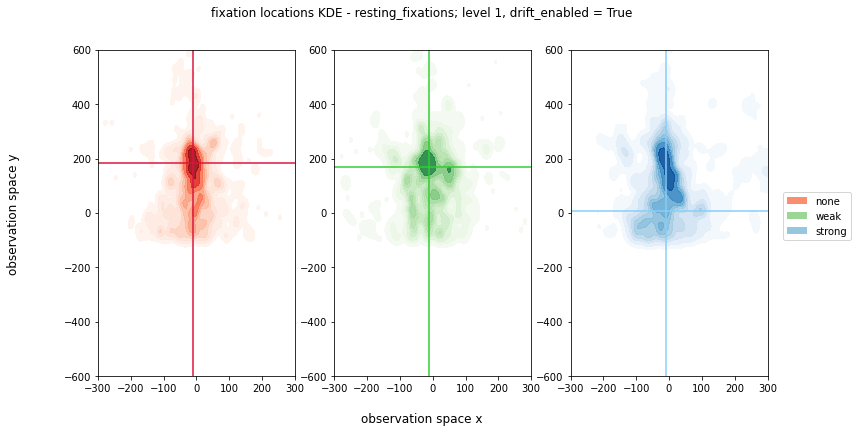

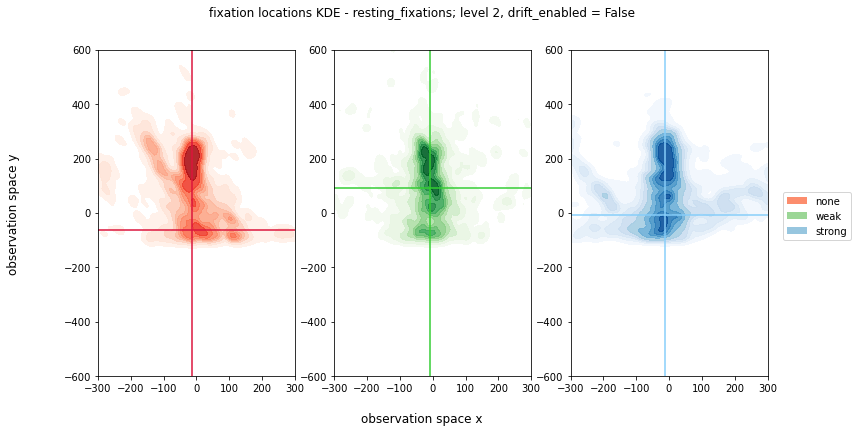

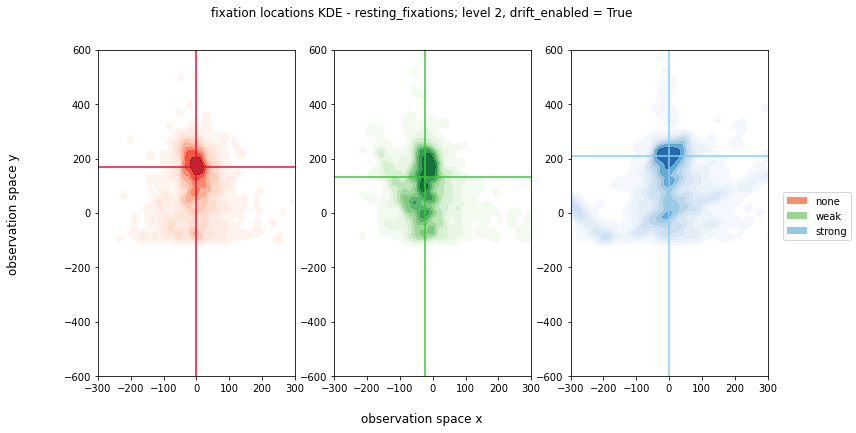

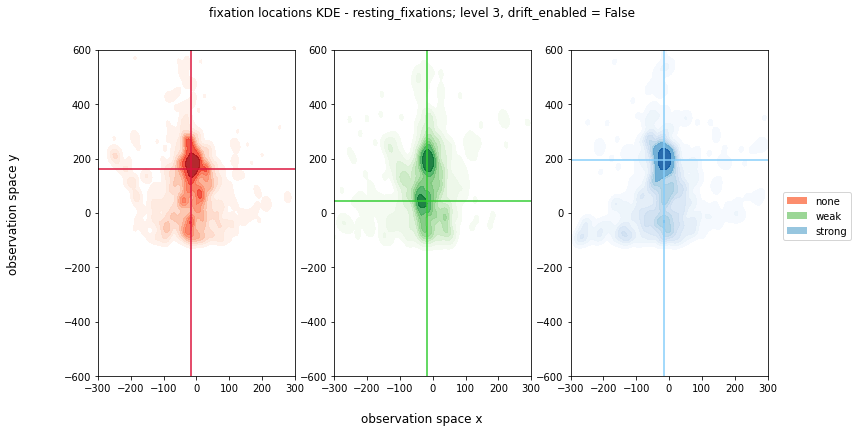

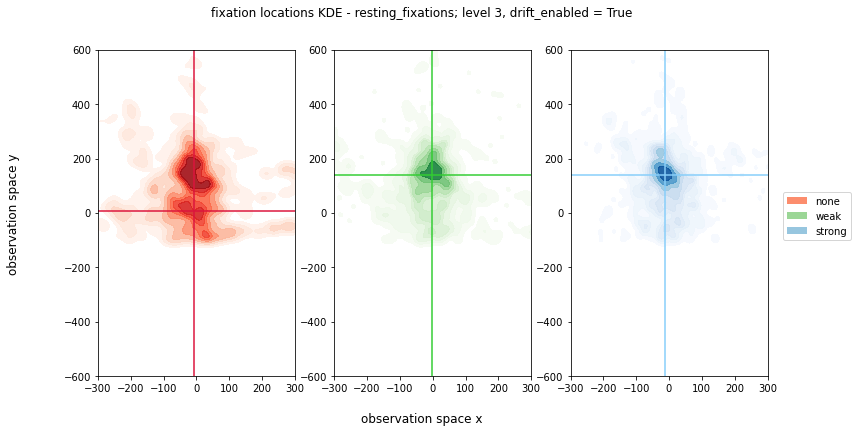

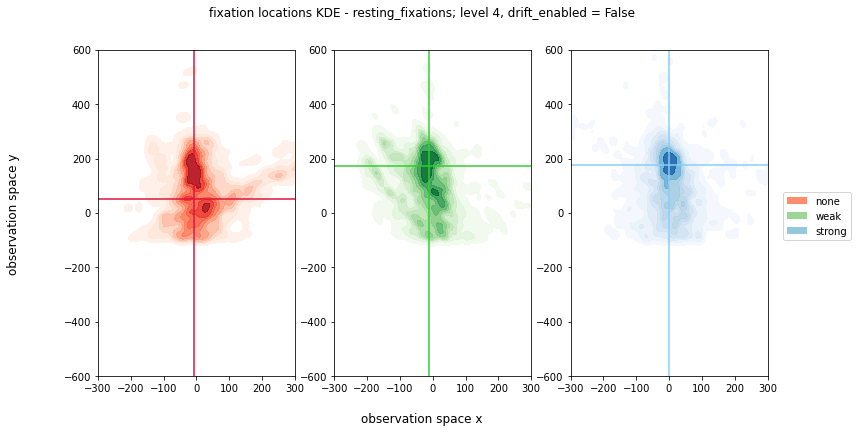

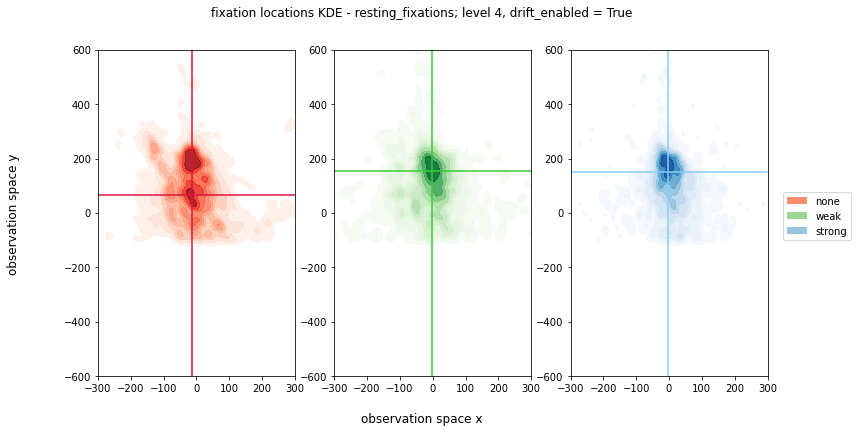

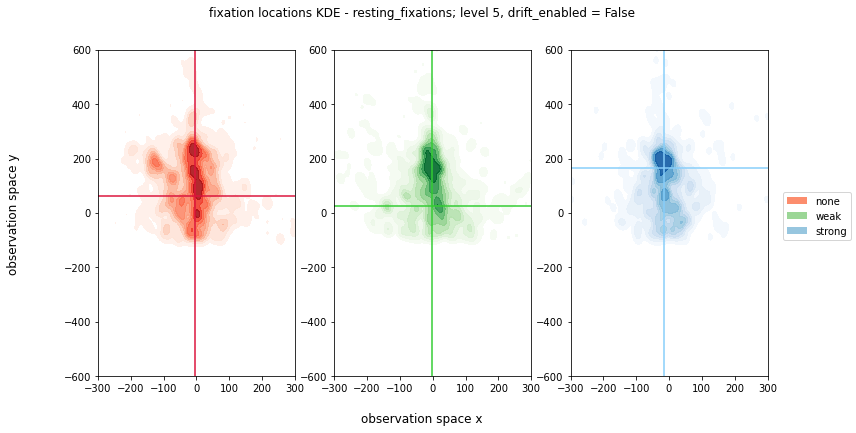

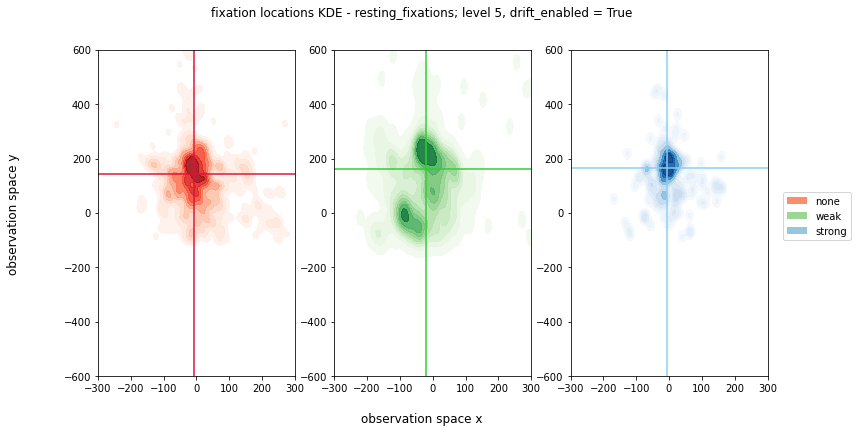

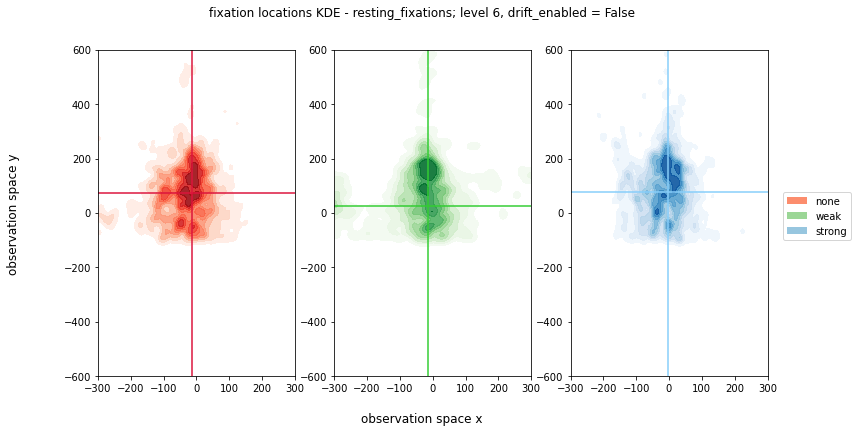

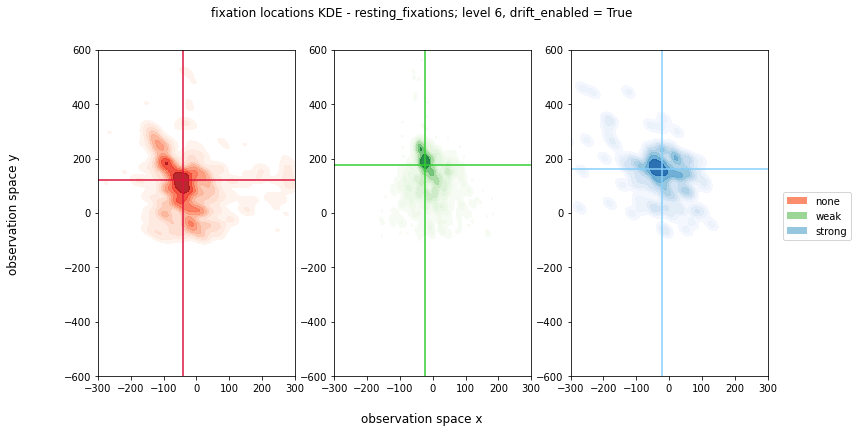

In [45]:
target_levels = [1, 2, 3, 4, 5, 6]
drift_enabled_args = [False, True]


args_list = [target_levels, drift_enabled_args]
arg_combs = list(itertools.product(*args_list))

for arg_comb in arg_combs:
    
    target_level = arg_comb[0]
    drift_enabled = arg_comb[1]

    eye_data = pd.read_csv(f'eye_data/experimental_eye_data_fixations.csv', index_col=False)
    eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled}")[0])]

    eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
    eye_data_weak = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'W']
    eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']

    plot_fixation_location_kde(eye_data_none, eye_data_weak, eye_data_strong, target_level, drift_enabled, exploring_fixations=False, safe_plot=False)


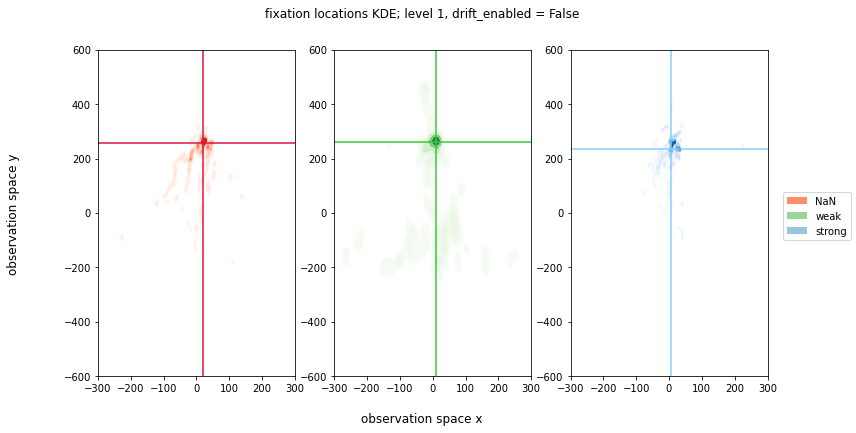

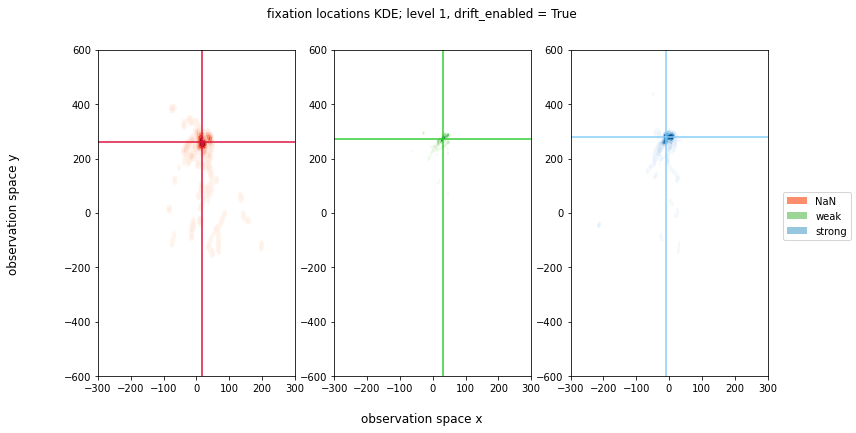

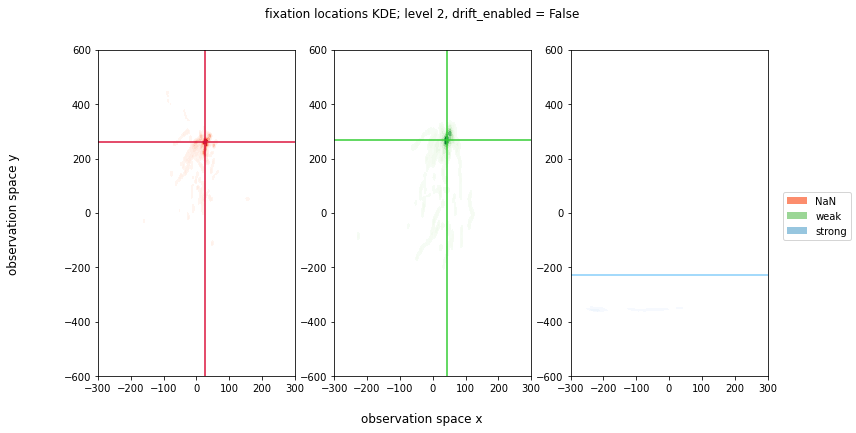

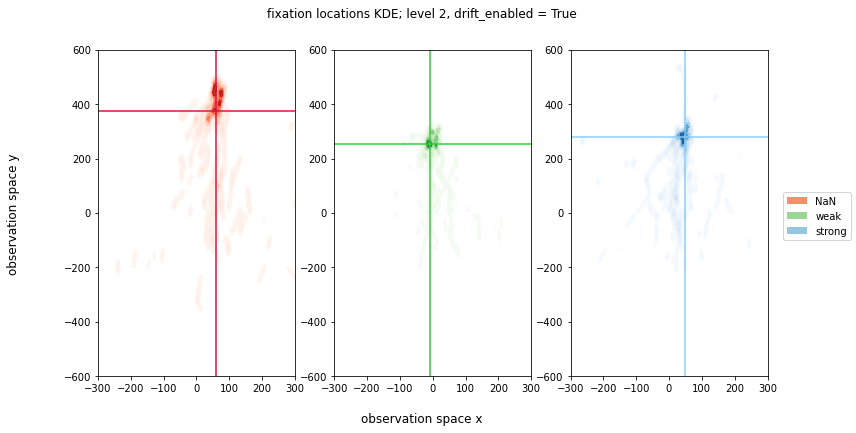

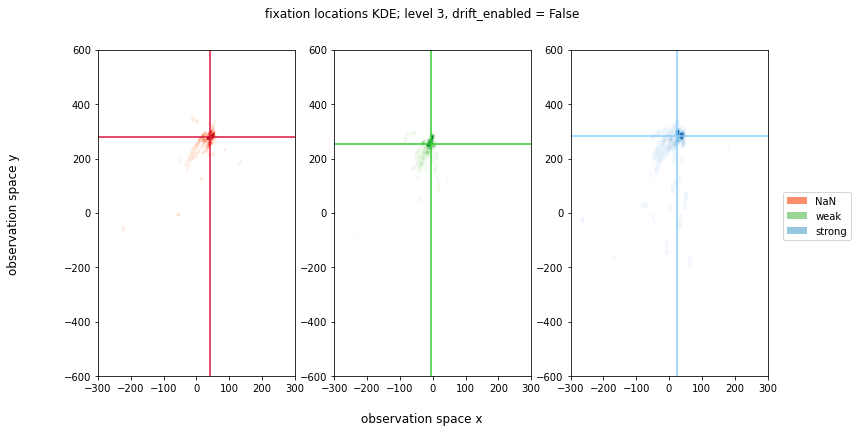

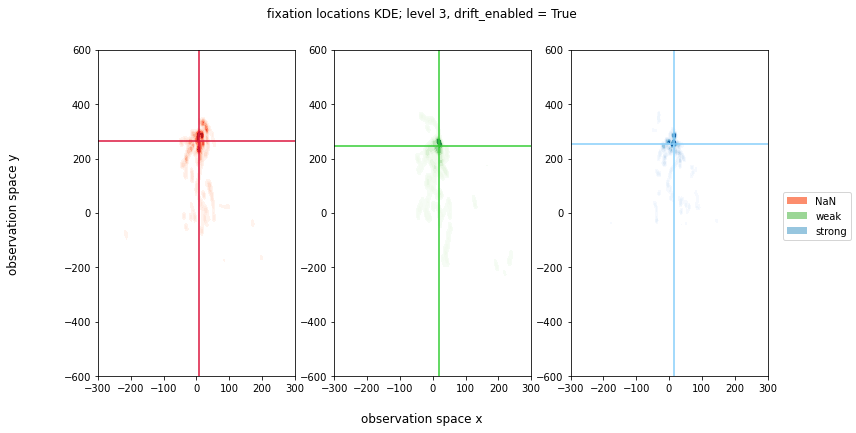

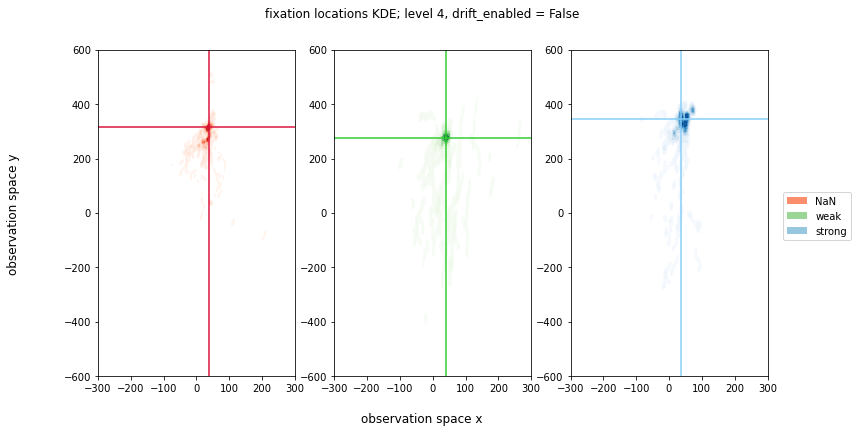

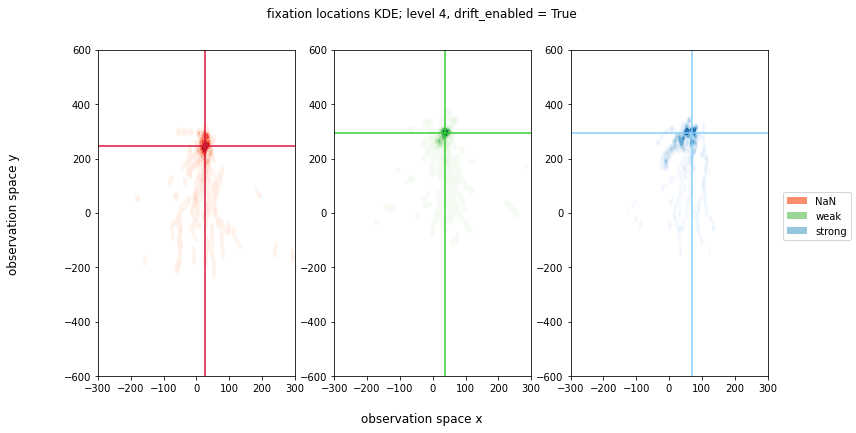

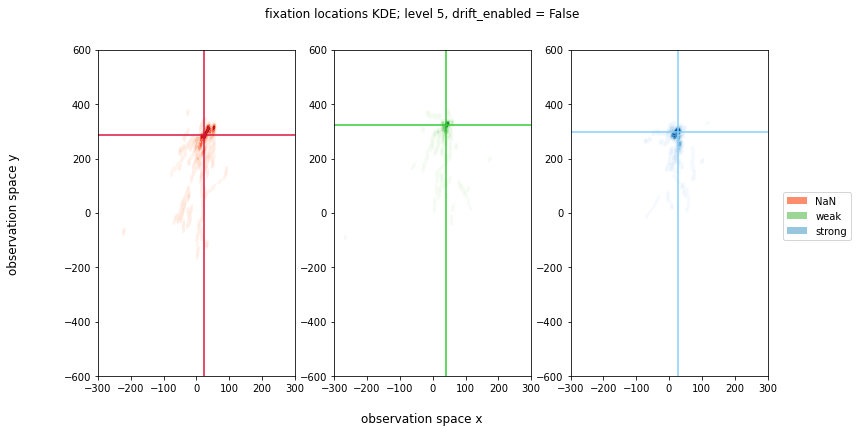

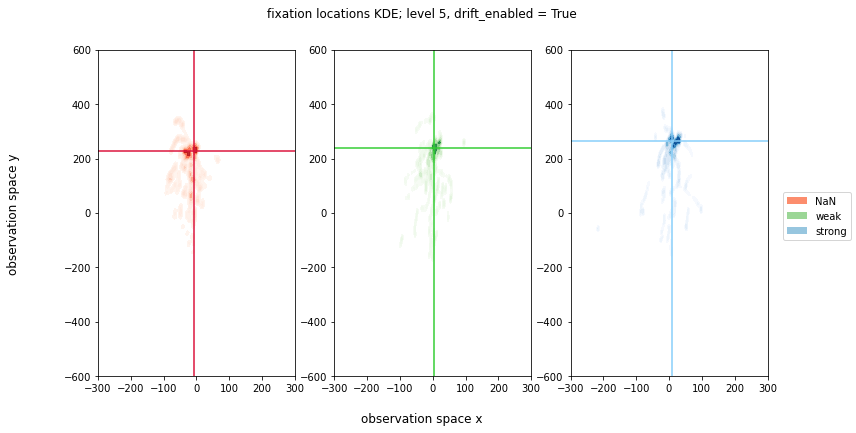

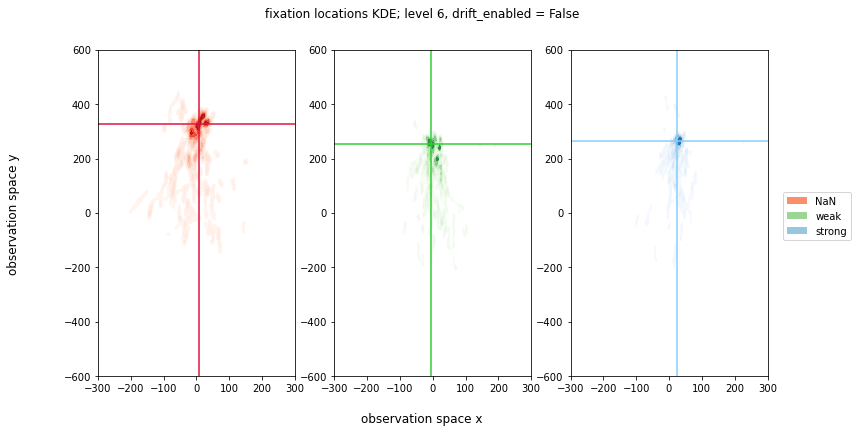

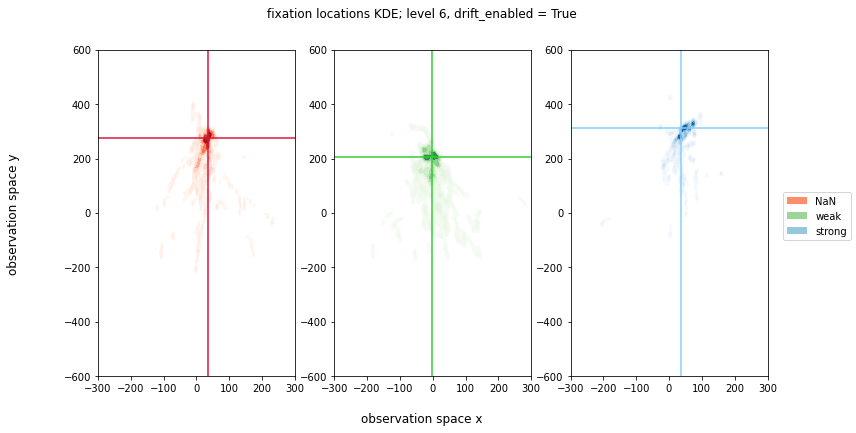

In [68]:
code = "pilot4"
for combination in trial_config_combinations:
    
    eye_data_none = pre_process_eye_data(pd.read_csv(f'eye_data/{code}_eye_tracking_output_{combination[0]:0>2}.csv', index_col=False))
    eye_data_weak = pre_process_eye_data(pd.read_csv(f'eye_data/{code}_eye_tracking_output_{combination[1]:0>2}.csv', index_col=False))
    eye_data_strong = pre_process_eye_data(pd.read_csv(f'eye_data/{code}_eye_tracking_output_{combination[2]:0>2}.csv', index_col=False))
    
    # get level features from exemplary input data
    input_data = pd.read_csv(f'input_data/{code}_output_{combination[0]:0>2}.csv', index_col=False)
    input_data = pre_process_input_data(input_data)
    level = input_data.iloc[-1].trial
    drift_enabled = input_data.iloc[-1].drift_enabled
    
    plot_fixation_location_kde(eye_data_none, eye_data_weak, eye_data_strong, level=level, drift_enabled=drift_enabled, safe_plot=False)

# Eye resting positions y (with drift onset if True)

In [31]:
def plot_eye_rest_y_over_time(eye_data_none, eye_data_weak, eye_data_strong, input_data, safe_plot=False, path_to_save_folder=f"{os.getcwd()}/plots/eye_resting_position_y/"):

    """
    :param eye_data_none: data of onput noise = none
    :param eye_data_weak: data of onput noise = weak
    :param eye_data_strong: data of onput noise = strong
    :param input_data: from which level features will be extracted as well as drift onset
    :param safe_plot: True vs. False - determines whether plots are saved or not
    :param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
    IMPORTANT: The function will not raise an error if the runs aren't of the same level and drift condition. It will only consider level and drift passed for labeling
    """
    
    # get level features from input data
    ## exemplary input data
    level = input_data.iloc[-1].trial
    drift_enabled = input_data.iloc[-1].drift_enabled
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f"eye resting y positions; level = {level}, drift_enabled = {drift_enabled}", fontdict={"fontweight": "bold"})

    # axis labels
    ax.set_xlabel("time_played")
    ax.set_ylabel("observation space y")
    
    ax.set_ylim([-200, 500])

    #plt.gca().invert_yaxis()

    # Plotting
    ## initiate colors and labels
    colors = ["coral", "lightgreen", "royalblue"]
    colors_p = ["crimson", "green", "blue"]
    color_maps = ["Reds", "Greens", "Blues"]
    alpha_levels = [0.8, 0.8, 0.8]  # none, weak, strong
    input_noise_magnitude = ["none", "weak", "strong"]
    
    counter = 0
    
    if drift_enabled:
        # draw lines where drift tile onset
        drift_tile_onset = input_data[input_data.drift_tile_onset == 1]
        for drift_onset_time_tag in drift_tile_onset.time_played:
            ax.axvline(drift_onset_time_tag, color="pink")
            
        second_drift_onset = input_data[input_data.second_drift_tile_onset == 1]
        for drift_onset_time_tag in second_drift_onset.time_played:
            ax.axvline(drift_onset_time_tag, color="hotpink")
    
    #for run in list_of_runs:
    for eye_data in [eye_data_none, eye_data_weak, eye_data_strong]:
        
        fixations = eye_data[eye_data["Fixation"] == 1]

        # draw on canvas
        ax.plot(fixations.time_tag, fixations.converging_eye_y, color=colors[counter], alpha=alpha_levels[counter])
        
        counter += 1
    
    handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=[input_noise_magnitude[0]]),
               mpatches.Patch(facecolor=plt.cm.Greens(100), label=[input_noise_magnitude[1]]),
               mpatches.Patch(facecolor=plt.cm.Blues(100), label=[input_noise_magnitude[2]])]
    ax.legend(handles=handles)
    
    if safe_plot:
        plt.savefig(f"{path_to_save_folder}eye_resting_position_y_level_{level}_drift_enabled_{drift_enabled}", dpi=300)
        #plt.close()

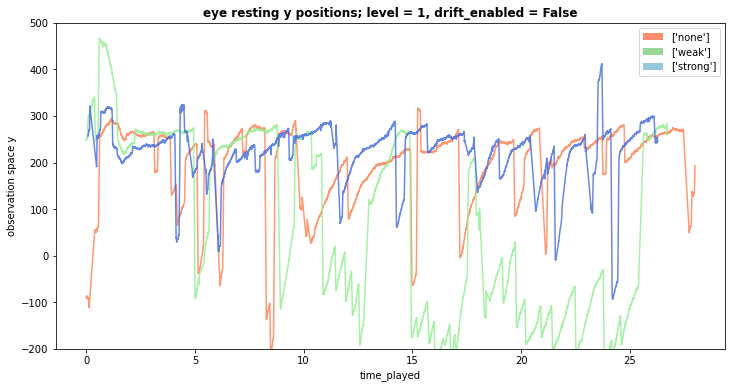

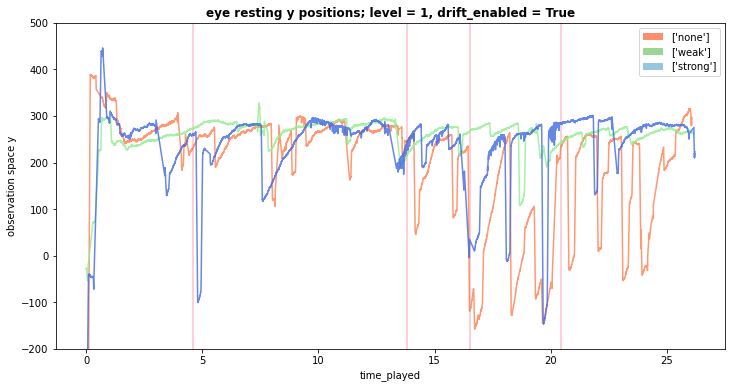

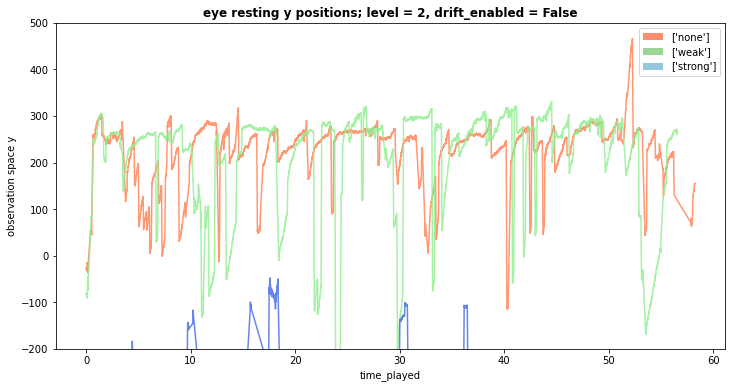

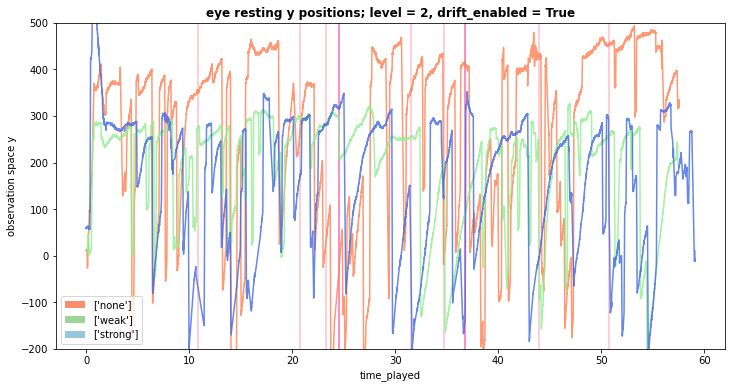

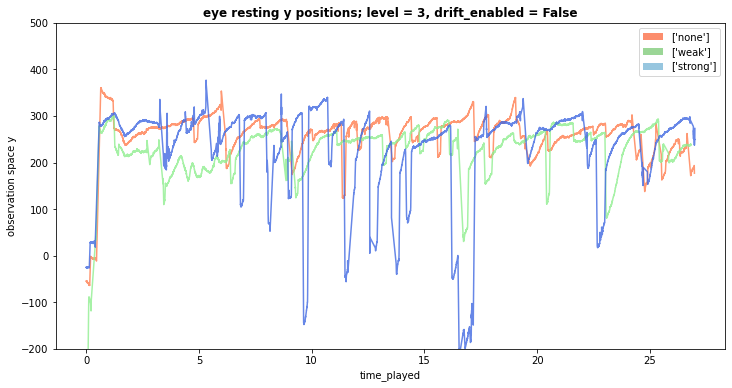

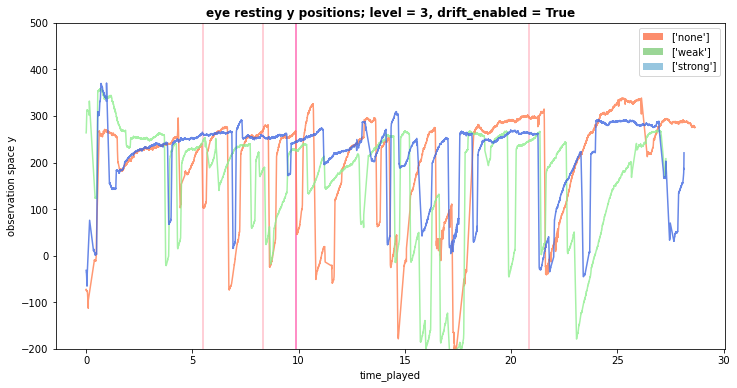

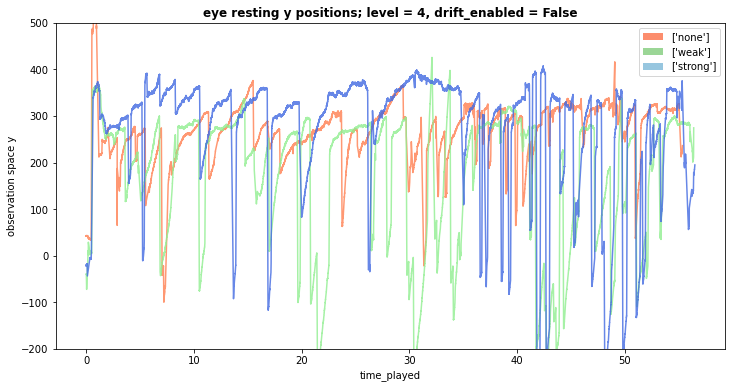

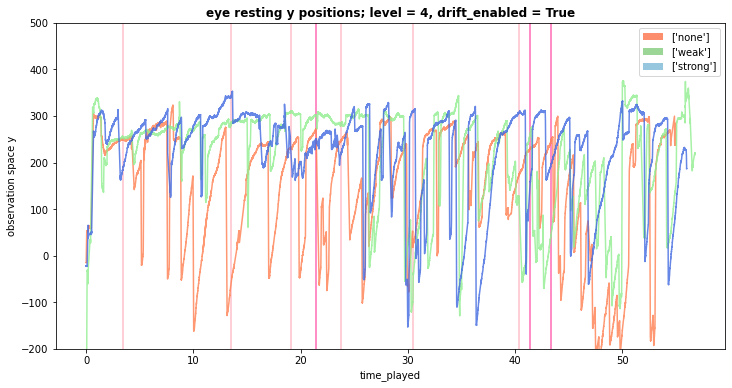

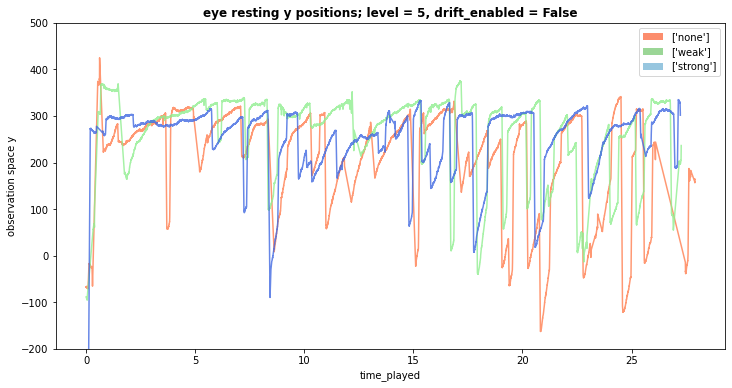

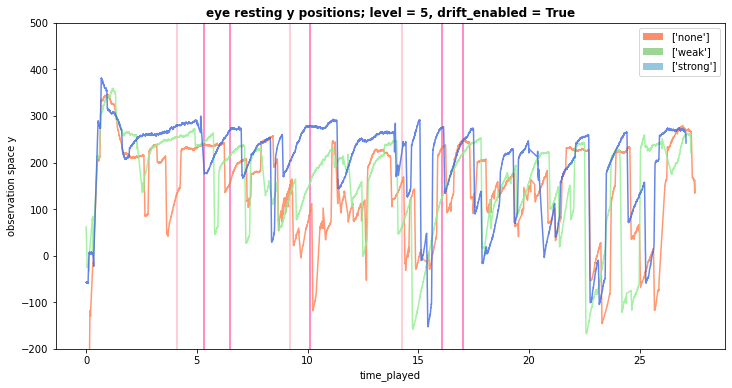

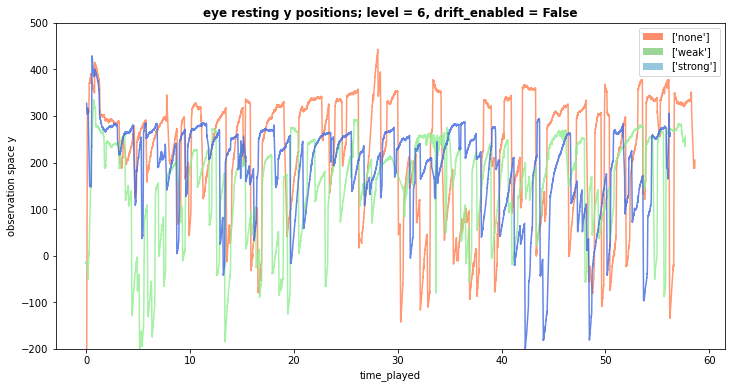

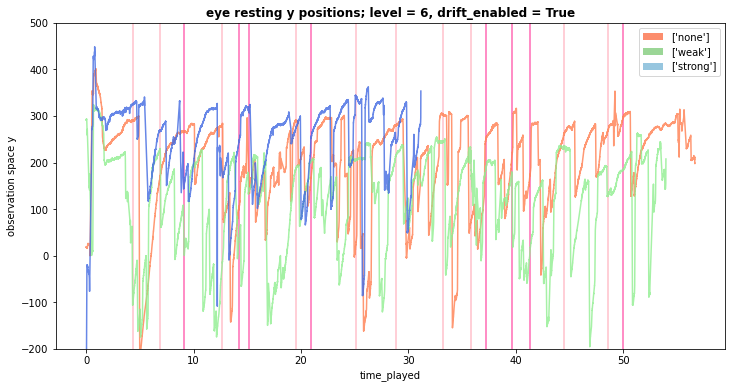

In [32]:
code = "pilot4"
for combination in trial_config_combinations:
    
    eye_data_none = pre_process_eye_data(pd.read_csv(f'eye_data/{code}_eye_tracking_output_{combination[0]:0>2}.csv', index_col=False))
    eye_data_weak = pre_process_eye_data(pd.read_csv(f'eye_data/{code}_eye_tracking_output_{combination[1]:0>2}.csv', index_col=False))
    eye_data_strong = pre_process_eye_data(pd.read_csv(f'eye_data/{code}_eye_tracking_output_{combination[2]:0>2}.csv', index_col=False))
    
    # get level features from exemplary input data
    input_data = pd.read_csv(f'input_data/{code}_output_{combination[0]:0>2}.csv', index_col=False)
    input_data = pre_process_input_data(input_data)
    plot_eye_rest_y_over_time(eye_data_none, eye_data_weak, eye_data_strong, input_data, safe_plot=False)

Use varying alphas to highlight a specific input noise condition. The ones that are not important plot with alpha=0.1 and the one of interest with alpha=1.0

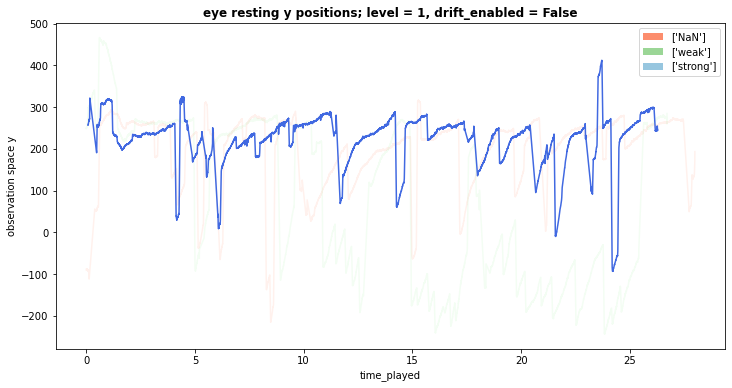

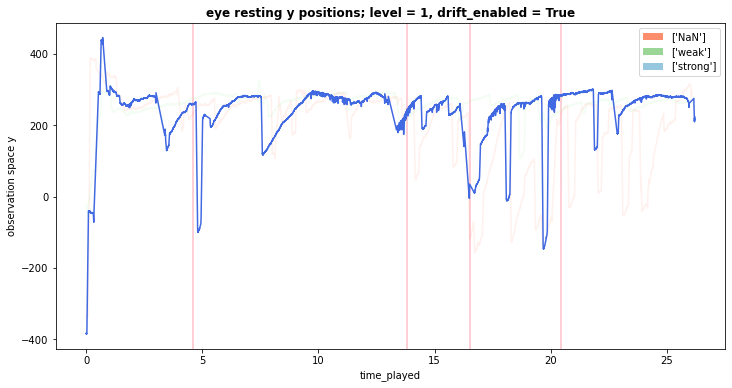

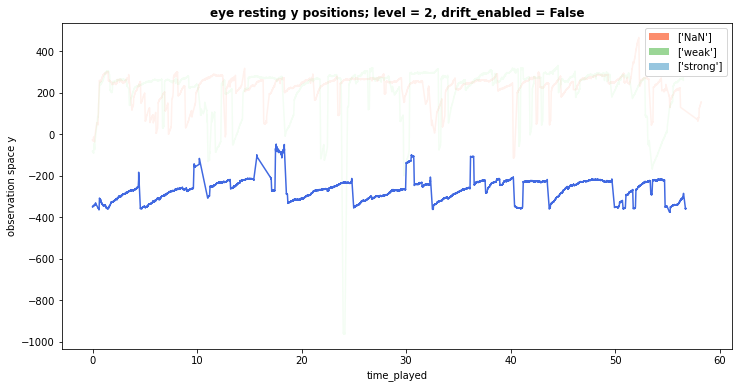

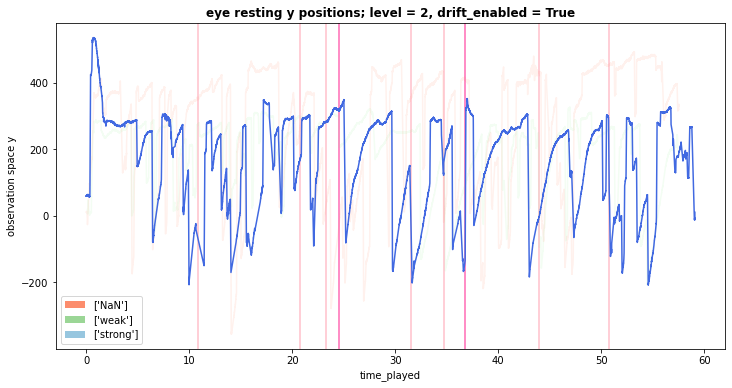

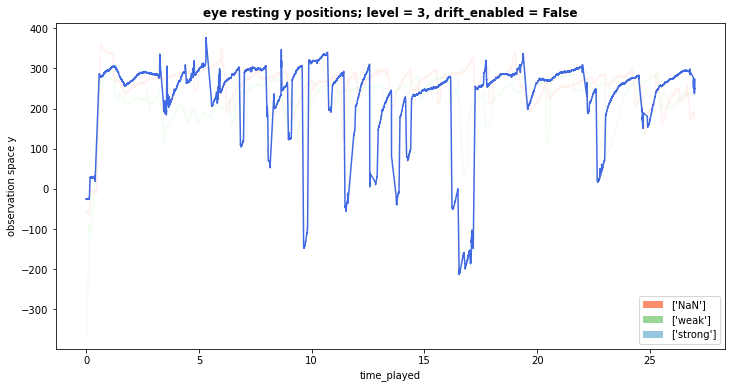

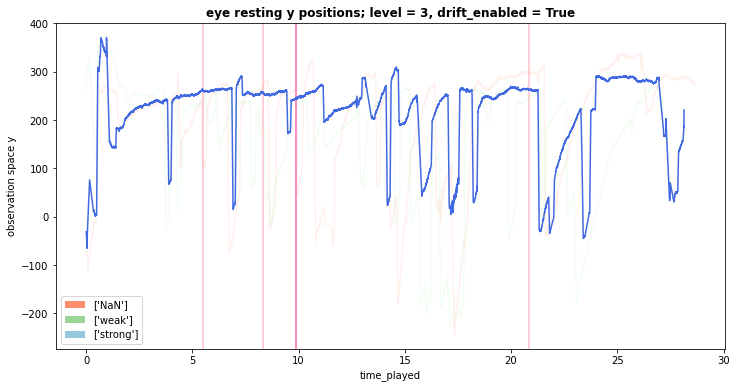

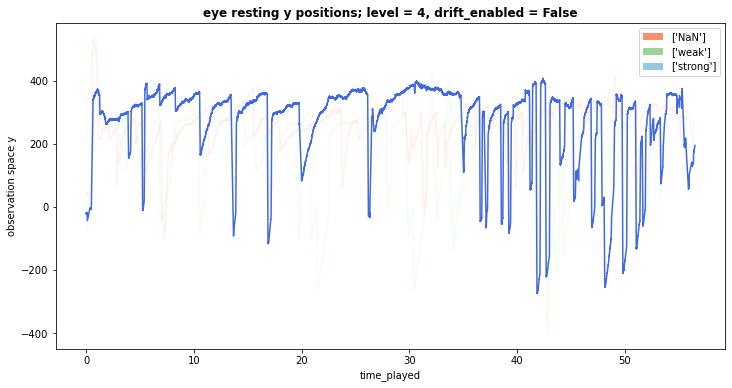

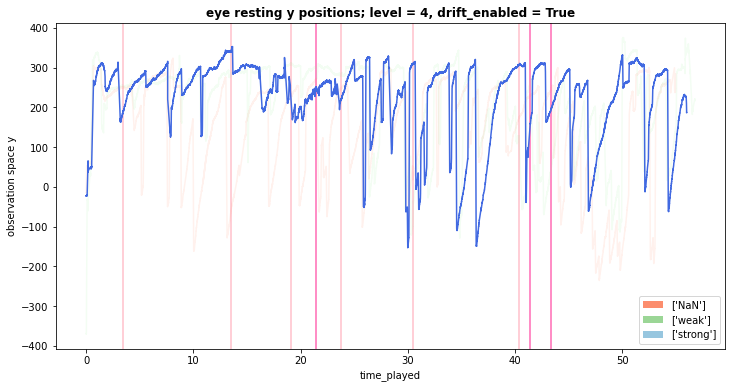

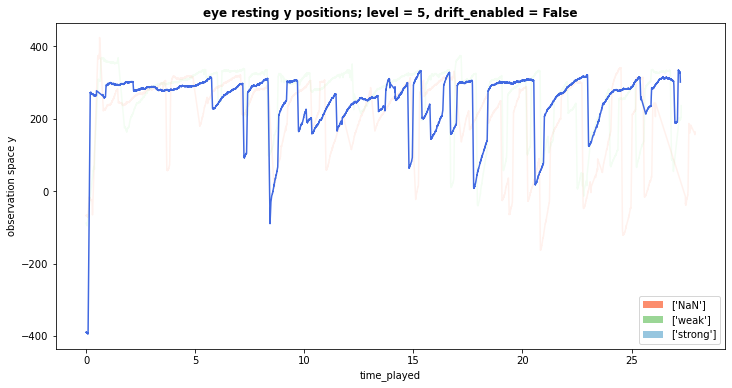

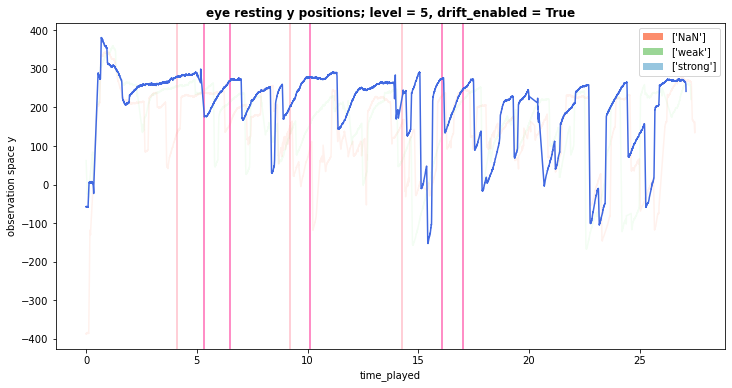

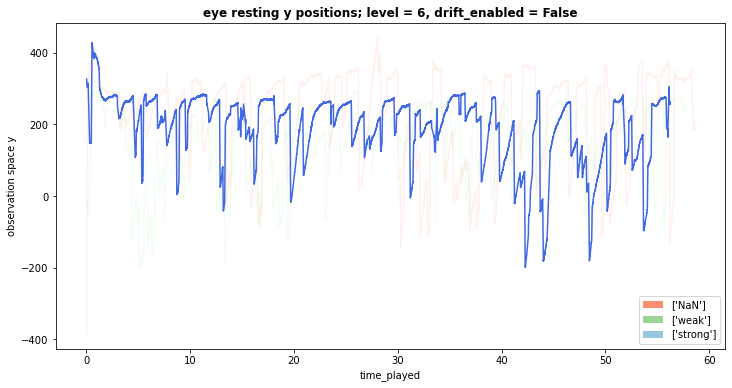

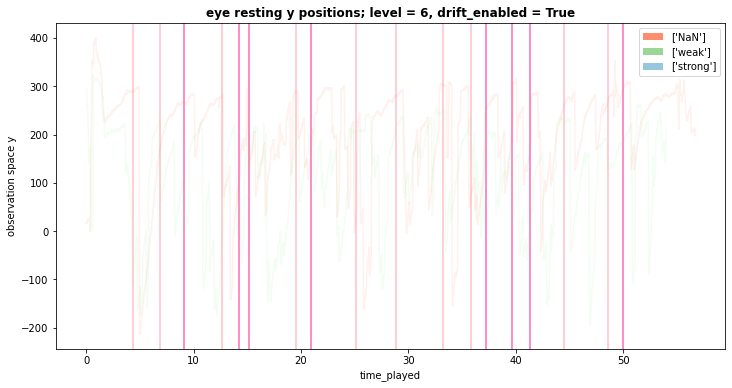

In [29]:
# high alpha for STRONG input noise

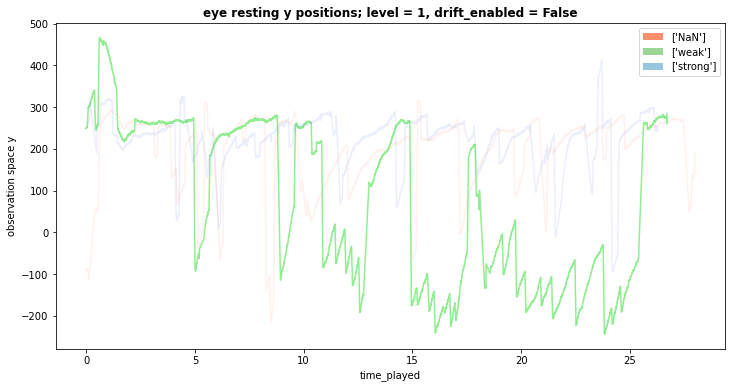

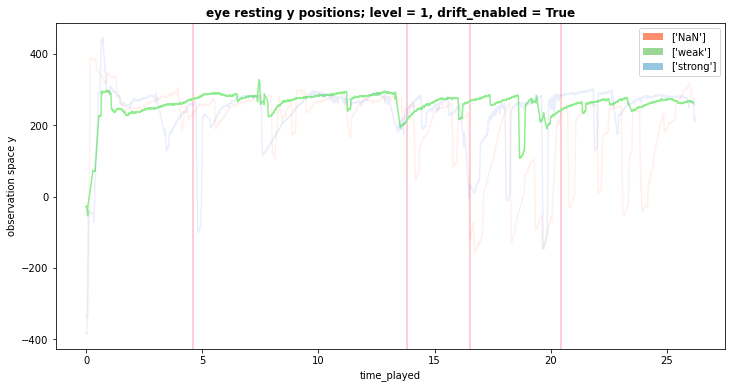

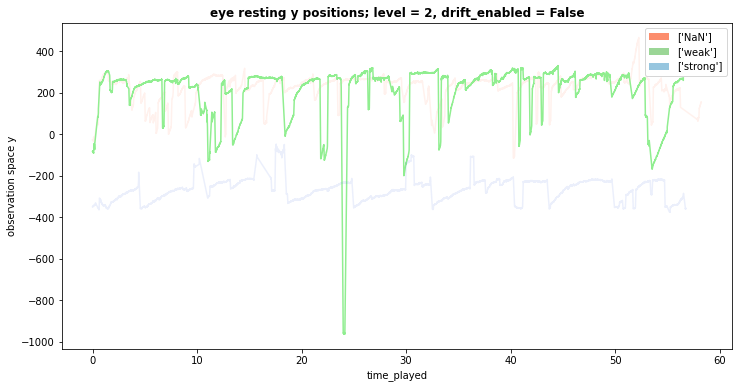

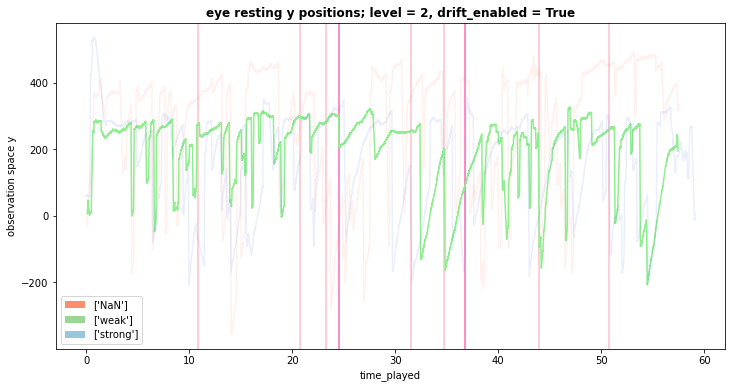

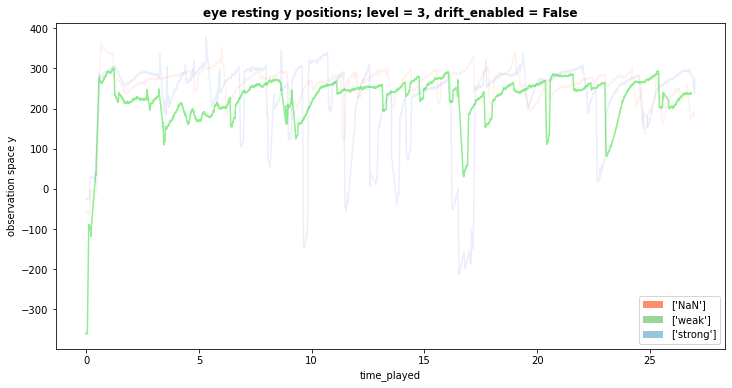

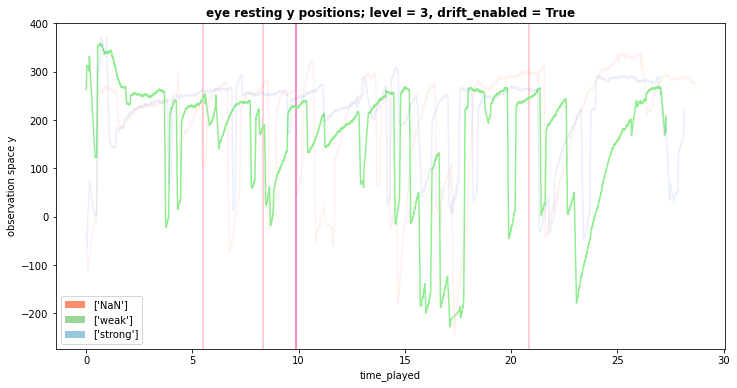

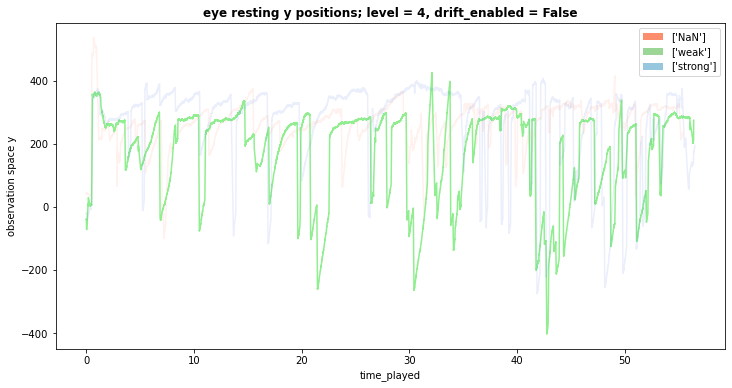

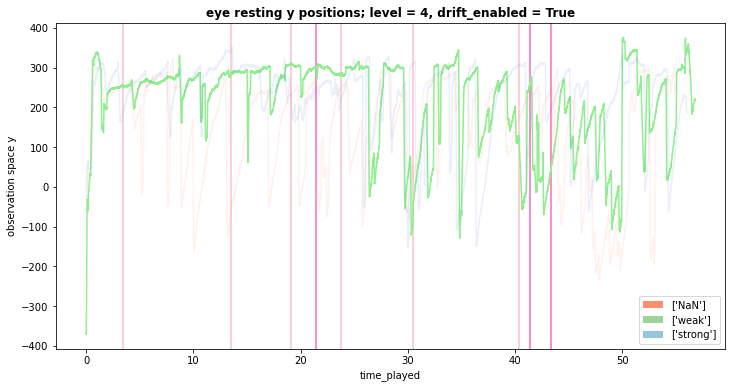

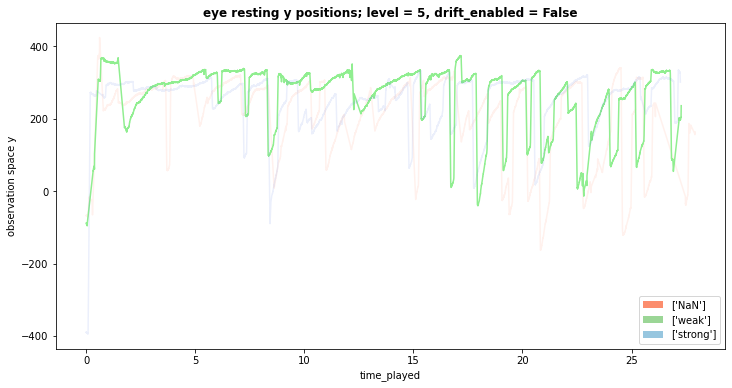

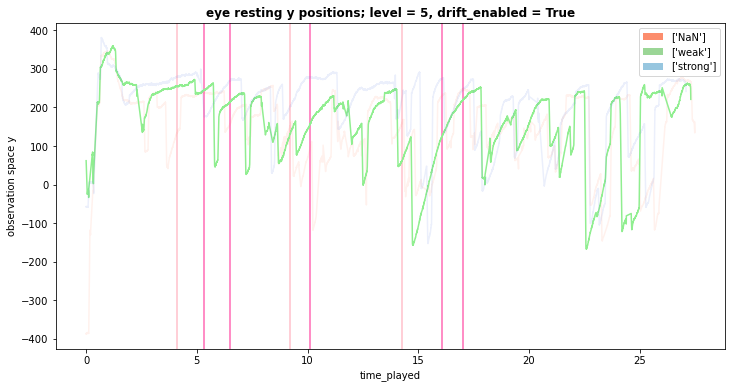

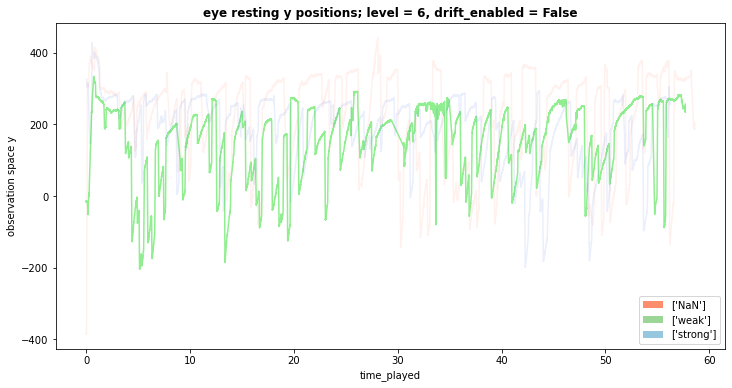

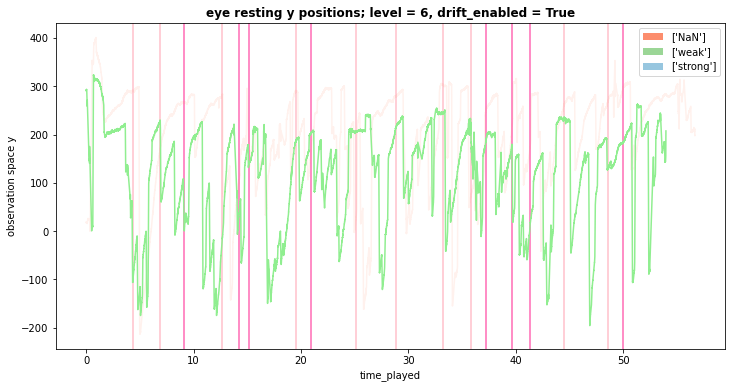

In [31]:
# high alpha for WEAK input noise

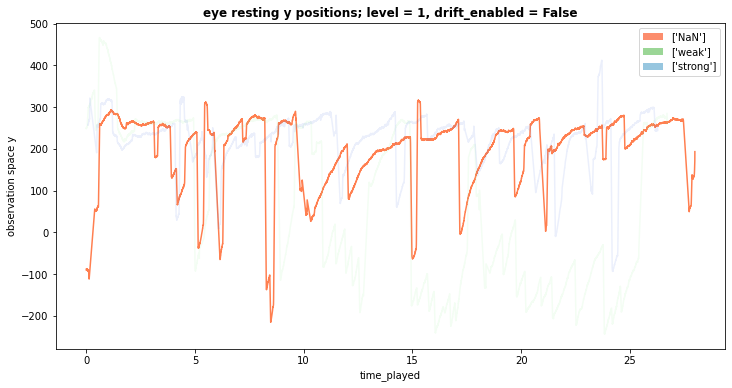

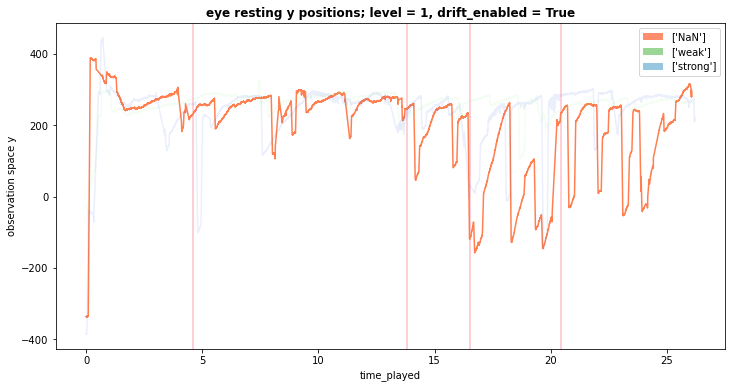

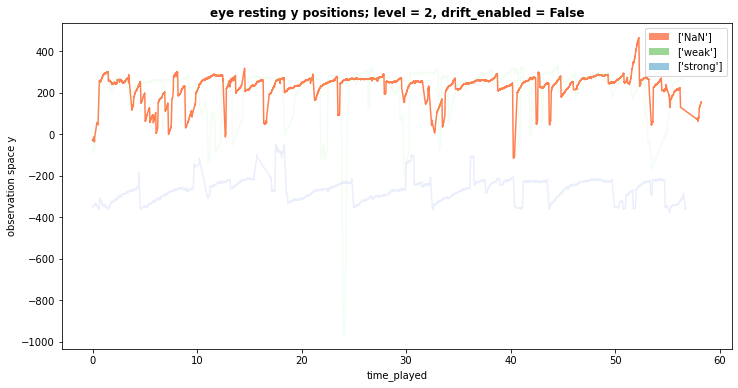

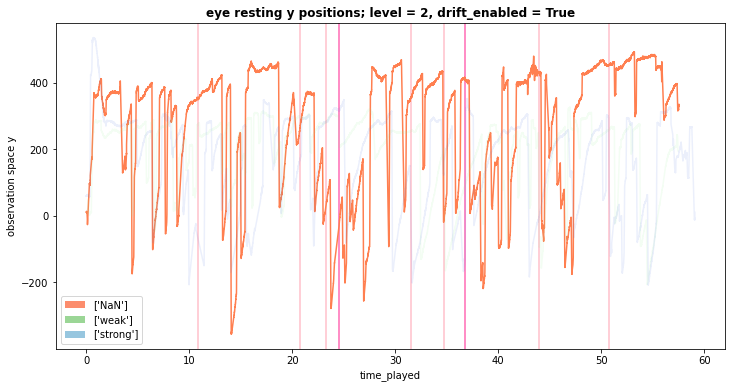

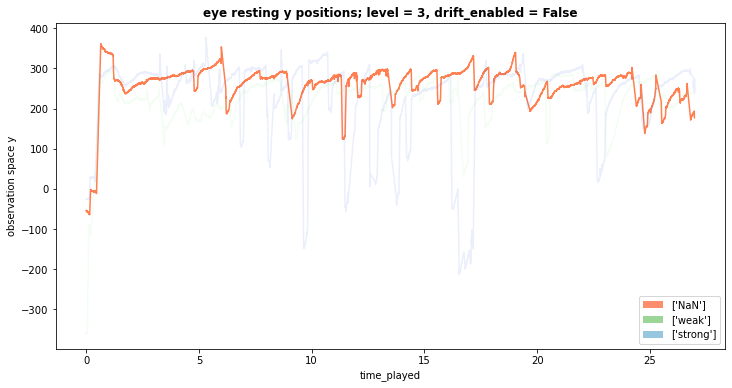

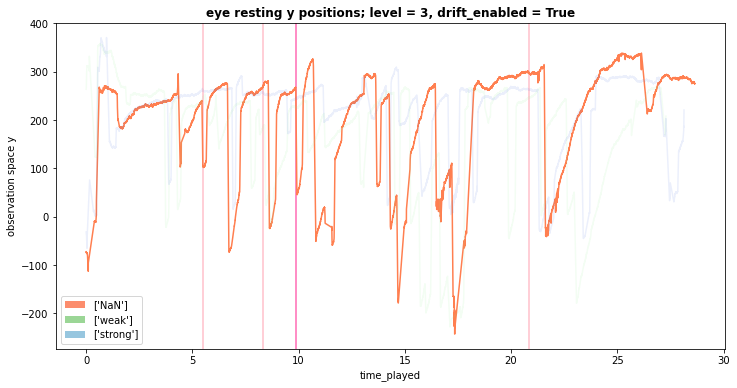

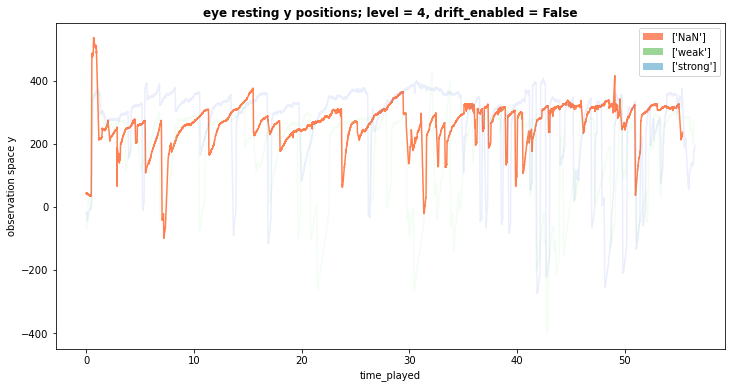

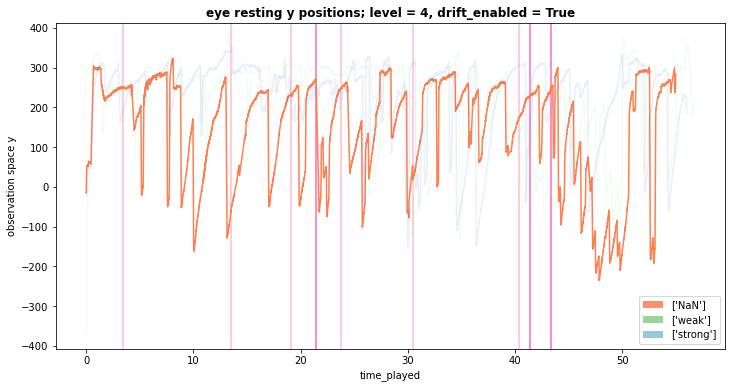

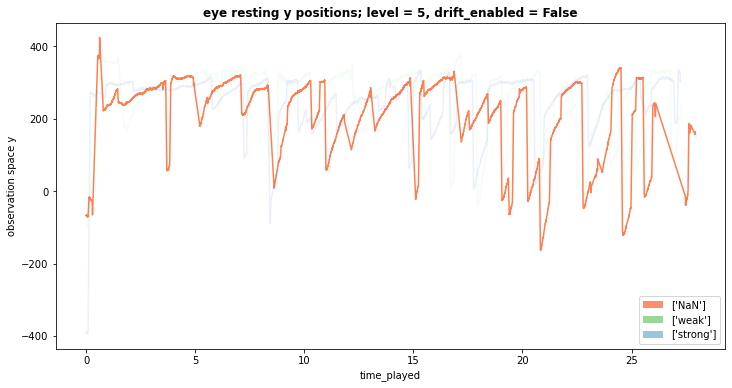

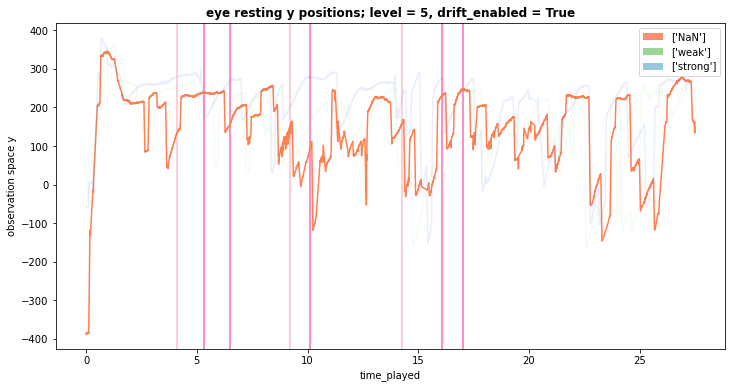

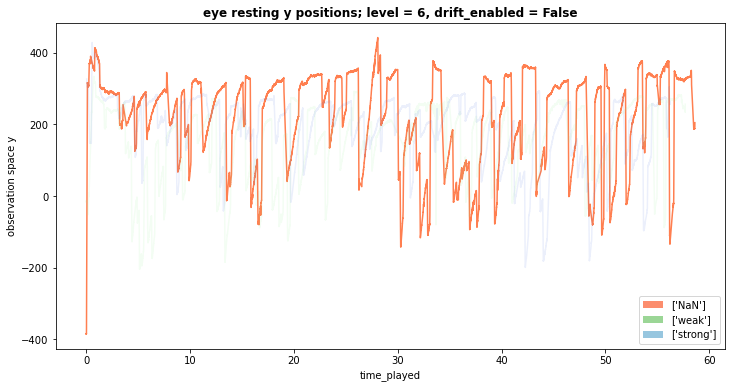

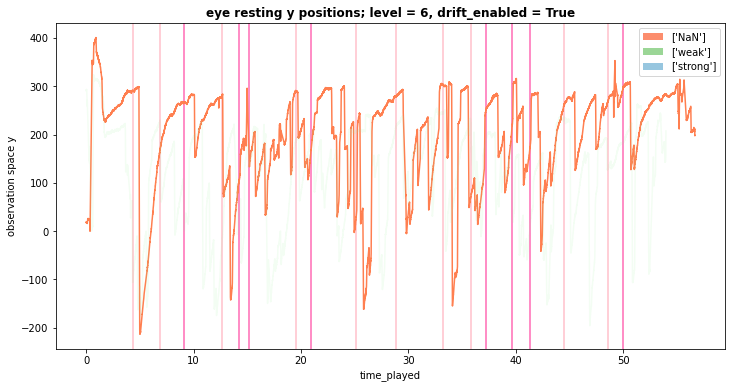

In [33]:
# high alpha for NAN input noise

# saccade amplitudes

In [25]:
def plot_saccade_amplitudes(eye_data_none, eye_data_weak, eye_data_strong, level, drift_enabled,
                            regressive_saccades=False, log_scale=False, safe_plot=False,
                            path_to_save_folder=f"{os.getcwd()}/plots/plots_saccade_amplitude/"):
    """
    :param eye_data_none: data of input noise = none
    :param eye_data_weak: data of input noise = weak
    :param eye_data_strong: data of input noise = strong
    :param level: level played
    :param drift_enabled: True vs. False
    :param regressive_saccades: True vs. False; if True regressive saccades are targeted else progressive saccades
    :param log_scale: False vs. True; whether y axis log scaled
    :param safe_plot: True vs. False - determines whether plots are saved or not
    :param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
    IMPORTANT: The function will not raise an error if the runs aren't of the same level and drift condition. It will only consider level and drift passed for labeling
    """

    if regressive_saccades:
        saccade_type = "regressive_saccades"
    else:
        saccade_type = "progressive_saccades"

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.set_title(f"saccade amplitudes - {saccade_type}; level {level}, drift_enabled = {drift_enabled}",
                 fontdict={"fontweight": "bold"})

    # axis labels
    ax.set_xlabel("input noise magnitude")
    ax.set_ylabel("saccade amplitude (in °)")

    ax.set_xlim([-1.25, 1.25])
    ax.set_xticks([-0.75, 0, 0.75])
    ax.set_xticklabels(["none", "weak", "strong"])

    if log_scale:
        ax.set_ylim([10 ** -1, 10 ** 3])
        ax.set_yscale("log")

    # Plotting
    colors = ["coral", "lightgreen", "royalblue"]
    colors_p = ["crimson", "green", "blue"]
    color_maps = ["Reds", "Greens", "Blues"]
    input_noise_magnitude = ["none", "weak", "strong"]
    offset = [-0.75, 0, 0.75]
    n_saccades = [np.nan, np.nan, np.nan]
    n_target_saccades = [np.nan, np.nan, np.nan]

    counter = 0

    for eye_data in [eye_data_none, eye_data_weak, eye_data_strong]:

        # all kinds of saccades
        # only consider the ones whichs amplitude is below 800 (arbitrarily chosen - saccades out of screen)
        saccades = eye_data[(eye_data["saccadeOnset"] >= 1) & (eye_data.saccade_amplitude < 800)]
        n_saccades[counter] = len(saccades)
        plot_labels = [offset[counter]] * len(saccades)
        saccades["plot_label"] = [offset[counter]] * len(saccades)
        # subset target saccades
        if regressive_saccades:
            target_saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
        else:
            target_saccades = saccades.loc[saccades["saccade_direction_y"] < 0]
        n_target_saccades[counter] = len(target_saccades)

        # draw on canvas
        ax.scatter(target_saccades.plot_label, target_saccades.saccade_amplitude, marker=".", color=colors_p[counter],
                   alpha=0.3)
        ax.plot(offset[counter], np.mean(target_saccades.saccade_amplitude), marker="_", markersize=15,
                color=colors_p[counter], alpha=1.0)

        # display density in violinplot over points
        violin = ax.violinplot(target_saccades.saccade_amplitude, showextrema=False, positions=[offset[counter]])
        violinparts = violin['bodies']
        for vp in violinparts:
            vp.set_facecolor(colors[counter])
            vp.set_edgecolor(colors[counter])

        counter += 1

    handles = [mpatches.Patch(facecolor=plt.cm.Reds(100),
                              label=[input_noise_magnitude[0], n_target_saccades[0], n_saccades[0]]),
               mpatches.Patch(facecolor=plt.cm.Greens(100),
                              label=[input_noise_magnitude[1], n_target_saccades[1], n_saccades[1]]),
               mpatches.Patch(facecolor=plt.cm.Blues(100),
                              label=[input_noise_magnitude[2], n_target_saccades[2], n_saccades[2]])]
    ax.legend(handles=handles)

    if safe_plot:
        plt.savefig(
            f"{path_to_save_folder}saccade_amplitude_{saccade_type}_level_{level}_drift_enabled_{drift_enabled}",
            dpi=300)
        plt.close()

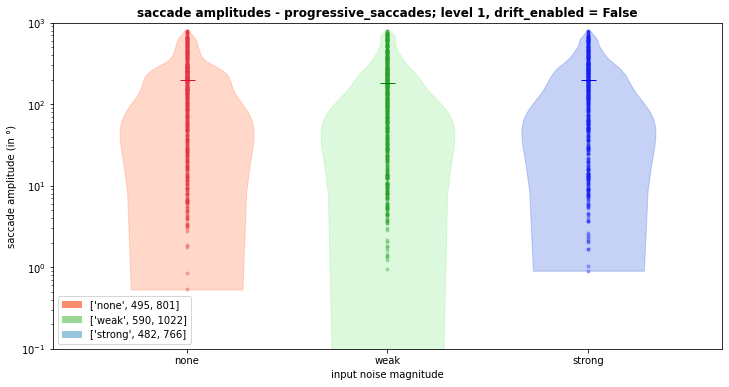

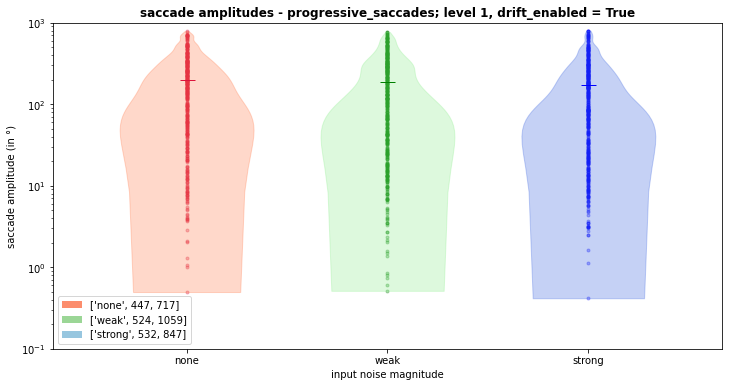

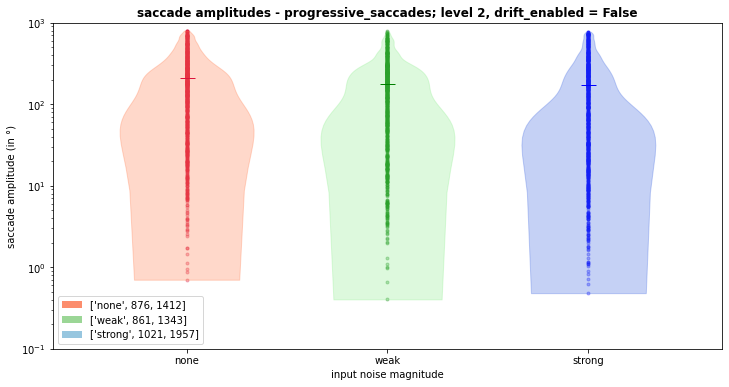

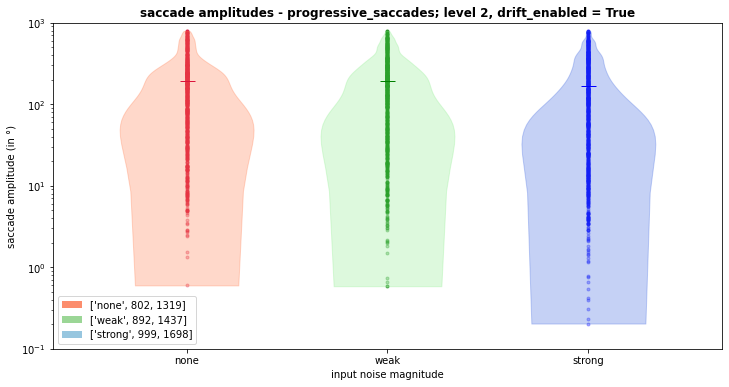

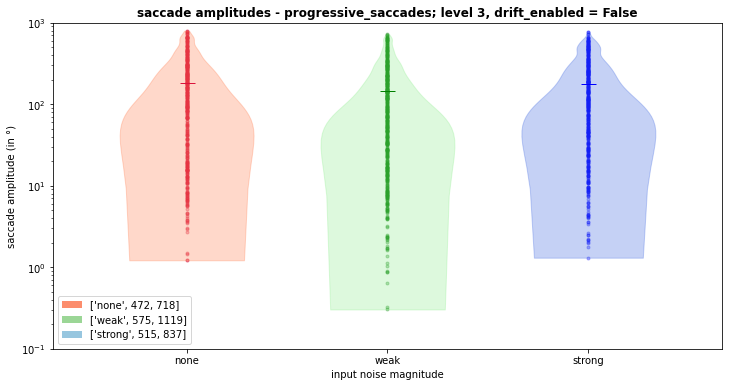

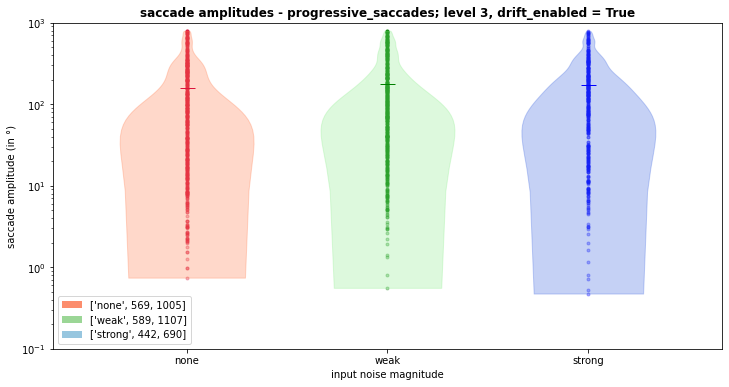

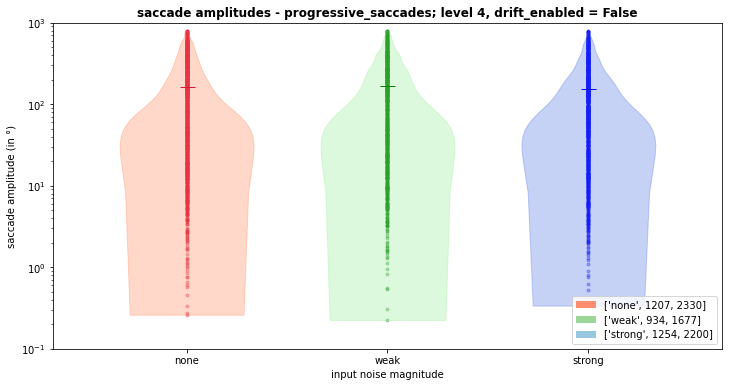

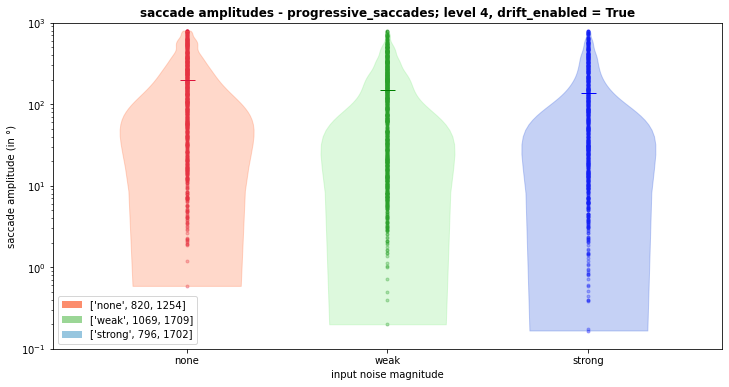

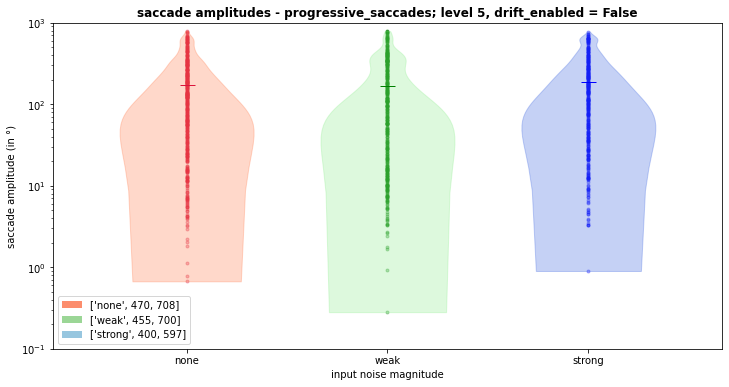

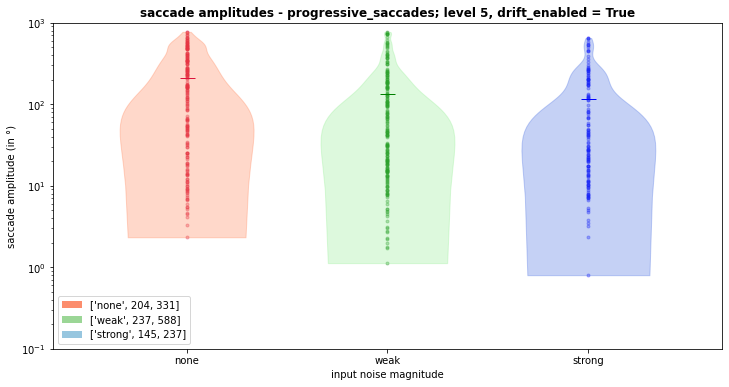

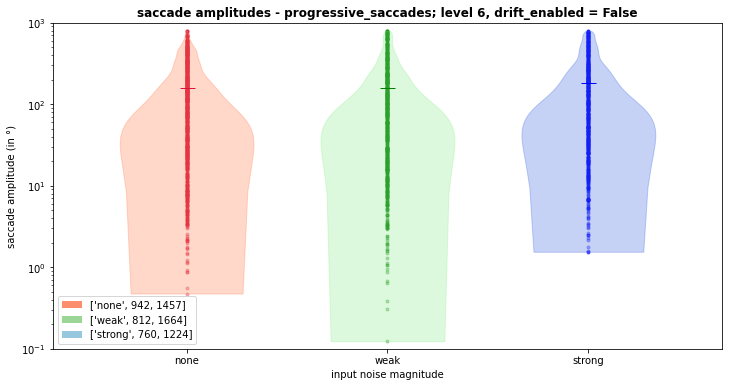

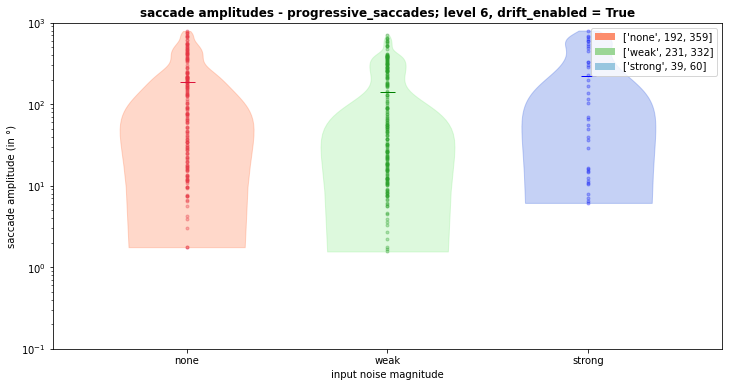

In [30]:
target_levels = [1, 2, 3, 4, 5, 6]
drift_enabled_args = [False, True]


args_list = [target_levels, drift_enabled_args]
arg_combs = list(itertools.product(*args_list))

#print(arg_combs)

for arg_comb in arg_combs:
#for drift_arg in drift_enabled_args:
    
    target_level = arg_comb[0]
    drift_enabled = arg_comb[1]

    eye_data = pd.read_csv(f'eye_data/experimental_eye_data_saccades.csv', index_col=False)
    eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled}")[0])]
    #eye_data_targetlevel = eye_data[(eye_data.drift == str(f"{drift_arg}")[0])]

    
    eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
    eye_data_weak = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'W']
    eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']

    plot_saccade_amplitudes(eye_data_none, eye_data_weak, eye_data_strong, target_level, drift_enabled, regressive_saccades=False, log_scale=True, safe_plot=False)


# Exploring saccade launch and landing sites

In [10]:
def plot_saccade_vectors(eye_data_none, eye_data_weak, eye_data_strong, level, drift_enabled, regressive_saccades=False, safe_plot=False, path_to_save_folder=f"{os.getcwd()}/plots/plots_saccade_vectors/"):
    
    """
    :param eye_data_none: data of onput noise = none
    :param eye_data_weak: data of onput noise = weak
    :param eye_data_strong: data of onput noise = strong
    :param level: level played
    :param drift_enabled: True vs. False
    :param regressive_saccades: True vs. False; if True regressive saccades are targeted else progressive saccades
    :param safe_plot: True vs. False - determines whether plots are saved or not
    :param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
    IMPORTANT: The function will not raise an error if the runs aren't of the same level and drift condition. It will only consider level and drift passed for labeling
    """
    
    if regressive_saccades:
        saccade_type = "regressive_saccades"
    else:
        saccade_type = "progressive_saccades"
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))  # 3 subplots
    fig.suptitle(f"saccade vectors - {saccade_type}; level {level}, drift_enabled = {drift_enabled}")
    
    fig.supxlabel("observation space x")
    fig.supylabel("observation space y")   

    # Plotting
    colors = ["coral", "lightgreen", "royalblue"]
    colors_p = ["crimson", "green", "blue"]
    color_maps = ["Reds", "Greens", "Blues"]
    input_noise_magnitude = ["none", "weak", "strong"]
    n_saccades = [np.nan, np.nan, np.nan]
    n_target_saccades = [np.nan, np.nan, np.nan]

    counter = 0
    
    for eye_data, ax in zip([eye_data_none, eye_data_weak, eye_data_strong], axs.ravel()):
        
        # axis labels
        ax.set_xlabel(" ")
        ax.set_ylabel(" ")

        ax.set_xlim([-1000, 1000])
        ax.set_ylim([-600, 600])

        # all kinds of saccades
        saccades = eye_data[eye_data["saccadeOnset"] >= 1]
        n_saccades[counter] = len(saccades)

        # subset target saccades
        if regressive_saccades:
            target_saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
        else:
            target_saccades = saccades.loc[saccades["saccade_direction_y"] < 0]

        n_target_saccades[counter] = len(target_saccades)
        
        # loop through saccades
        for saccade in np.arange(len(target_saccades)):
            saccade_launch_site = [target_saccades.iloc[saccade].converging_eye_x, target_saccades.iloc[saccade].converging_eye_y]
            saccade_landing_site = [target_saccades.iloc[saccade].converging_eye_x + target_saccades.iloc[saccade].saccade_direction_x, target_saccades.iloc[saccade].converging_eye_y + target_saccades.iloc[saccade].saccade_direction_y]
            
            x_pos = [saccade_launch_site[0], saccade_landing_site[0]]
            y_pos = [saccade_launch_site[1], saccade_landing_site[1]]
            
            # draw on canvas
            ax.quiver(x_pos, y_pos, target_saccades.iloc[saccade].saccade_direction_x, target_saccades.iloc[saccade].saccade_direction_y, scale_units='xy', angles='xy', scale=1, color=colors[counter], alpha=1.0)

        counter += 1

    handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=[input_noise_magnitude[0], n_target_saccades[0], n_saccades[0]]),
               mpatches.Patch(facecolor=plt.cm.Greens(100), label=[input_noise_magnitude[1], n_target_saccades[1], n_saccades[1]]),
               mpatches.Patch(facecolor=plt.cm.Blues(100), label=[input_noise_magnitude[2], n_target_saccades[2], n_saccades[2]])]
    fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.98, 0.9), framealpha=1.0)
    
    if safe_plot:
        plt.savefig(f"{path_to_save_folder}saccade_vectors_{saccade_type}_level_{level}_drift_enabled_{drift_enabled}", dpi=300)
        #plt.close()

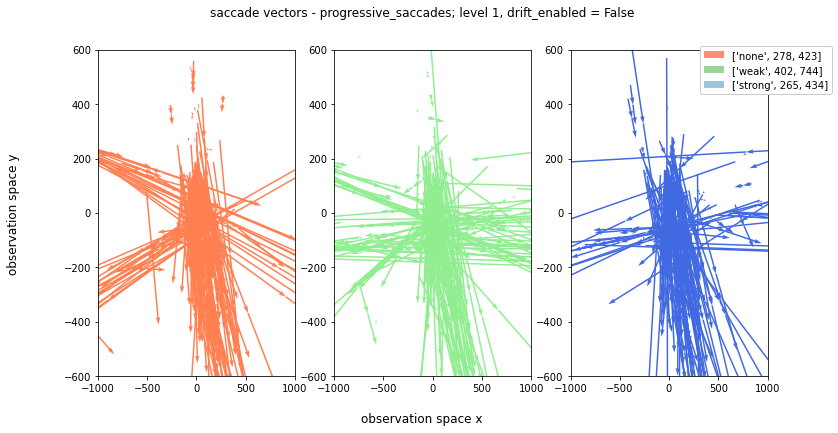

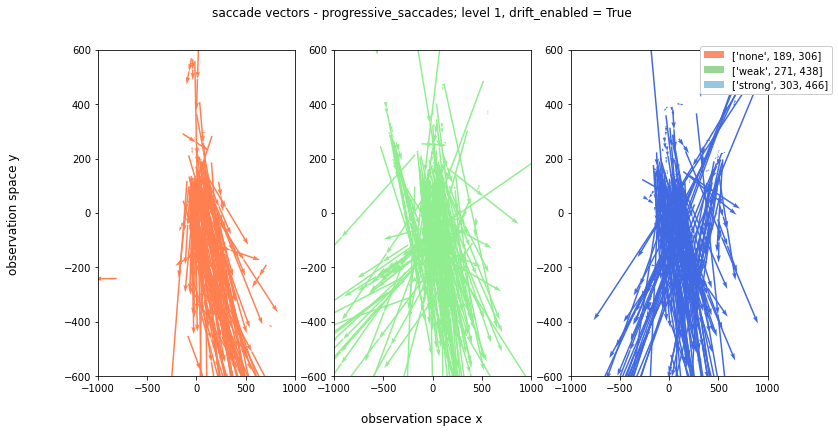

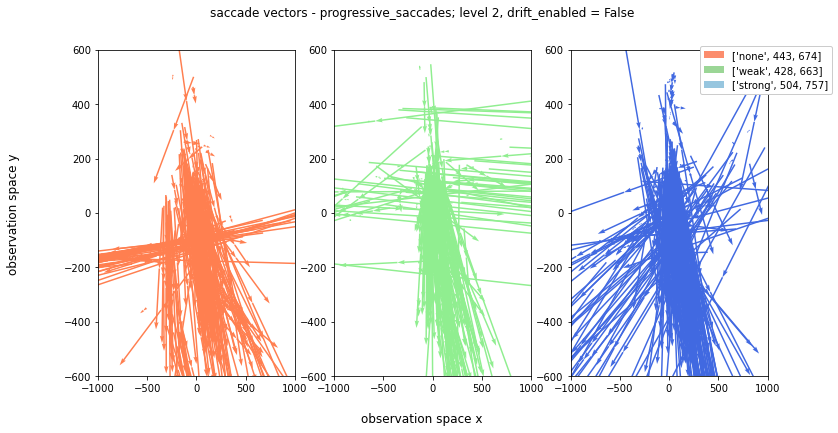

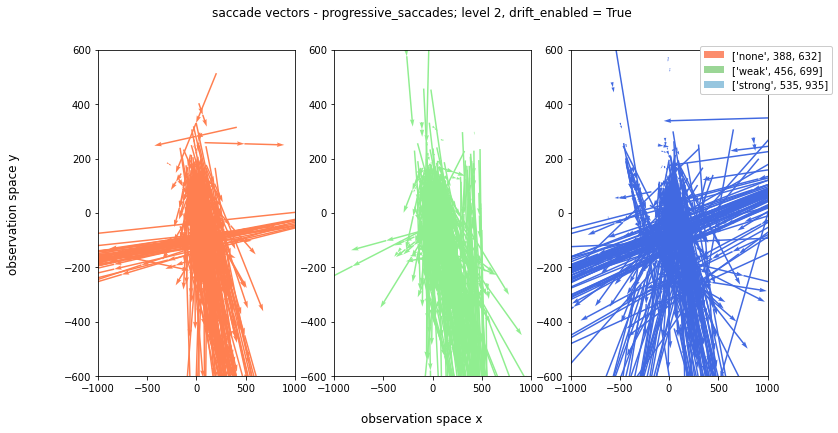

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1

<Figure size 864x432 with 3 Axes>

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1

<Figure size 864x432 with 3 Axes>

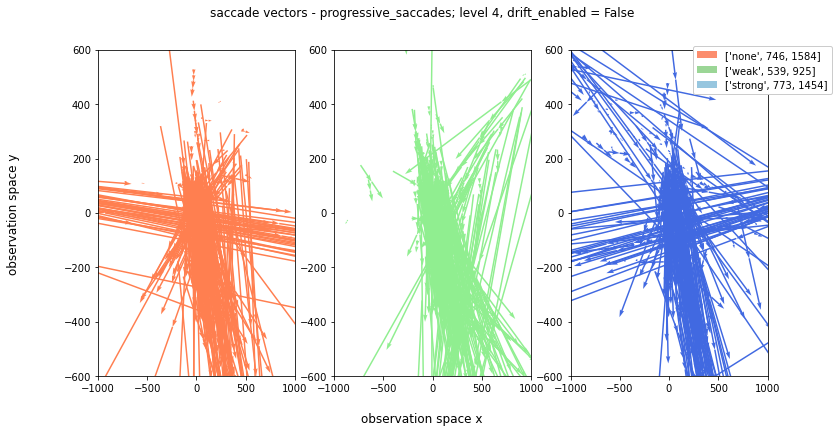

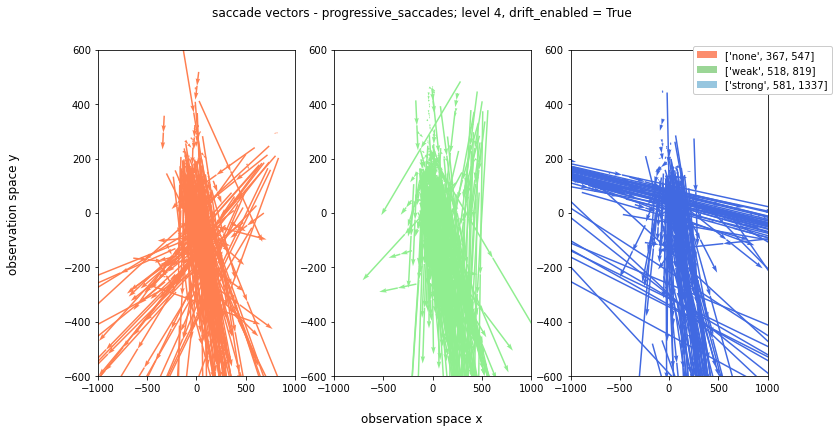

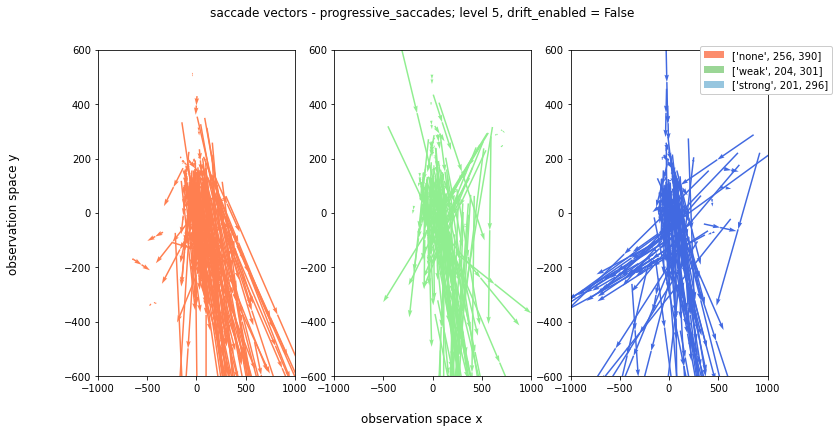

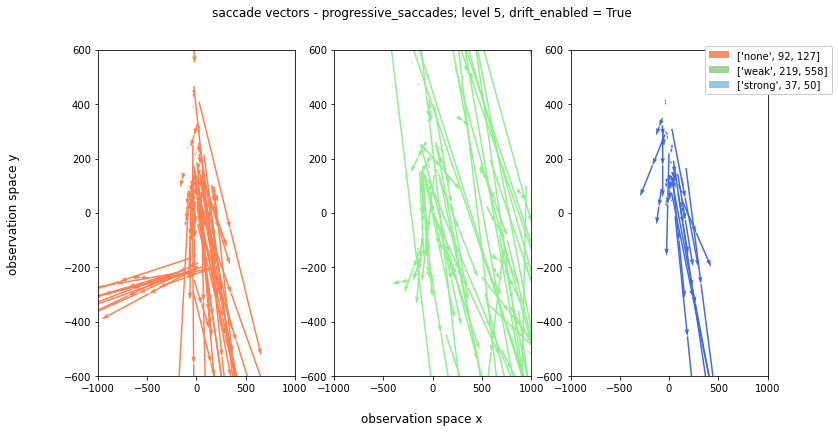

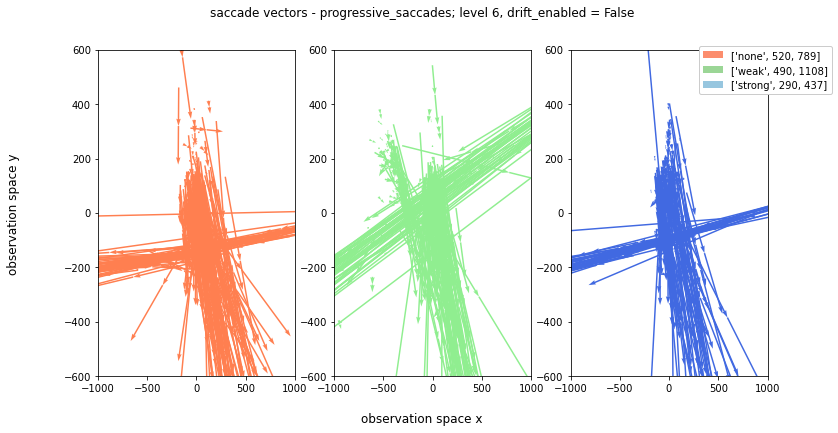

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1

<Figure size 864x432 with 3 Axes>

In [25]:
target_levels = [1, 2, 3, 4, 5, 6]
drift_enabled_args = [False, True]


args_list = [target_levels, drift_enabled_args]
arg_combs = list(itertools.product(*args_list))

for arg_comb in arg_combs:
    
    target_level = arg_comb[0]
    drift_enabled = arg_comb[1]

    eye_data = pd.read_csv(f'eye_data/experimental_eye_data_saccades.csv', index_col=False)
    eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled}")[0])]

    eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
    eye_data_weak = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'W']
    eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']

    plot_saccade_vectors(eye_data_none, eye_data_weak, eye_data_strong, target_level, drift_enabled, regressive_saccades=False, safe_plot=False)


In [24]:
def plot_saccade_landing_sites(eye_data_none, eye_data_weak, eye_data_strong, level, drift_enabled, regressive_saccades=False, safe_plot=False, path_to_save_folder=f"{os.getcwd()}/plots/plots_saccade_landing_site/"):    
    
    """
    :param eye_data_none: data of onput noise = none
    :param eye_data_weak: data of onput noise = weak
    :param eye_data_strong: data of onput noise = strong
    :param level: level played
    :param drift_enabled: True vs. False
    :param regressive_saccades: True vs. False; if True regressive saccades are targeted else progressive saccades
    :param safe_plot: True vs. False - determines whether plots are saved or not
    :param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
    IMPORTANT: The function will not raise an error if the runs aren't of the same level and drift condition. It will only consider level and drift passed for labeling
    """
    if regressive_saccades:
        saccade_type = "regressive_saccades"
    else:
        saccade_type = "progressive_saccades"
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))  # 3 subplots
    fig.suptitle(f"saccade landing sites - {saccade_type}; level {level}, drift_enabled = {drift_enabled}")
    
    fig.supxlabel("observation space x")
    fig.supylabel("observation space y")   

    # Plotting
    colors = ["coral", "lightgreen", "royalblue"]
    colors_p = ["crimson", "green", "blue"]
    color_maps = ["Reds", "Greens", "Blues"]
    input_noise_magnitude = ["none", "weak", "strong"]
    n_saccades = [np.nan, np.nan, np.nan]
    n_target_saccades = [np.nan, np.nan, np.nan]

    counter = 0
    
    for eye_data, ax in zip([eye_data_none, eye_data_weak, eye_data_strong], axs.ravel()):
        
        # axis labels
        ax.set_xlabel(" ")
        ax.set_ylabel(" ")

        ax.set_xlim([-1500, 1500])
        ax.set_ylim([-800, 400])

        # all kinds of saccades
        saccades = eye_data[eye_data["saccadeOnset"] >= 1]
        n_saccades[counter] = len(saccades)
        # subset target saccades
        if regressive_saccades:
            target_saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
        else:
            target_saccades = saccades.loc[saccades["saccade_direction_y"] < 0]
        n_target_saccades[counter] = len(target_saccades)
        # insert saccade landing sites
        target_saccades["saccade_landing_site_x"] = target_saccades.converging_eye_x + target_saccades.saccade_direction_x
        target_saccades["saccade_landing_site_y"] = target_saccades.converging_eye_y + target_saccades.saccade_direction_y
        
        #filter for landing sites within level
        target_saccades = target_saccades[target_saccades["saccade_landing_site_x"].between(((34-20)*18), ((34+40+20)*18))]
        # edge=34, scaling=18, observation_space_x=40
        
        # draw on canvas
        heatmap = sns.kdeplot(x=target_saccades.saccade_landing_site_x,
                              y=target_saccades.saccade_landing_site_y,
                              cmap=color_maps[counter],
                              shade=True,
                              alpha=0.9,
                              bw_adjust=0.4,
                              ax=ax)
        
        #y_coord = point_estimate(progressive_saccades.saccade_landing_site_y)[0]
        #ax.axhline(y_coord, color=colors[counter])
        #x_coord = point_estimate(progressive_saccades.saccade_landing_site_x)[0]
        #ax.axvline(x_coord, color=colors[counter])
            
        counter += 1

    handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=[input_noise_magnitude[0], n_target_saccades[0], n_saccades[0]]),
               mpatches.Patch(facecolor=plt.cm.Greens(100), label=[input_noise_magnitude[1], n_target_saccades[1], n_saccades[1]]),
               mpatches.Patch(facecolor=plt.cm.Blues(100), label=[input_noise_magnitude[2], n_target_saccades[2], n_saccades[2]])]
    fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.98, 0.9), framealpha=1.0)
    
    if safe_plot:
        plt.savefig(f"{path_to_save_folder}saccade_landing_site_{saccade_type}_level_{level}_drift_enabled_{drift_enabled}", dpi=300)
        #plt.close()

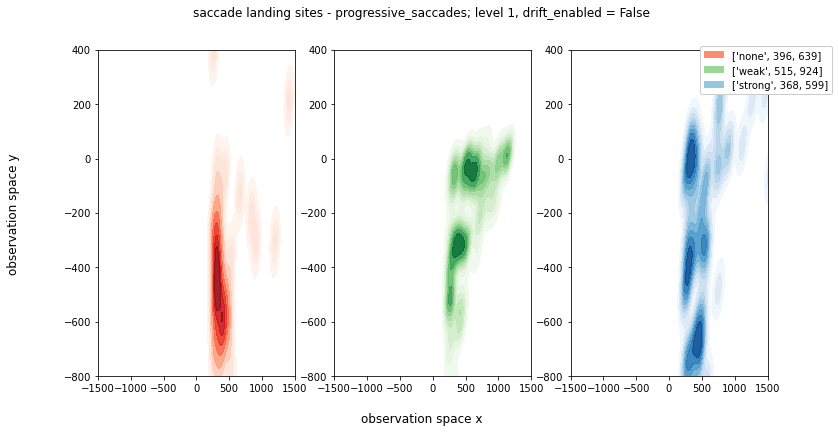

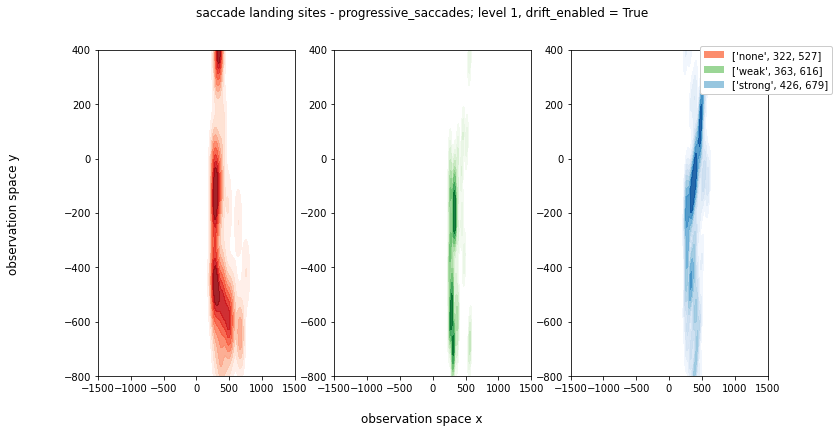

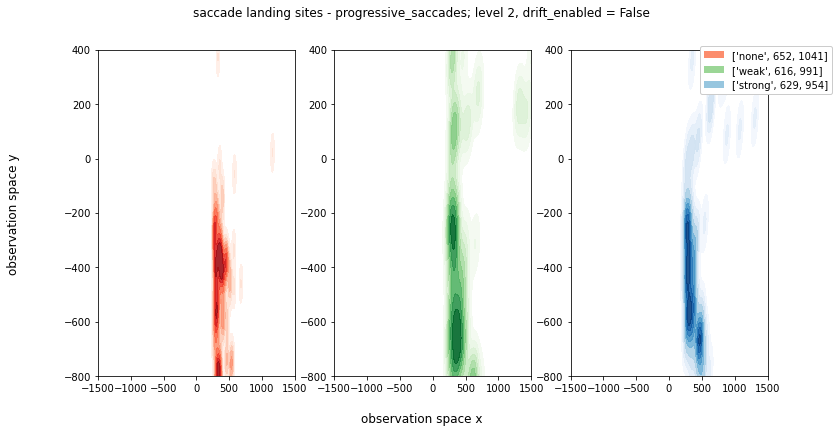

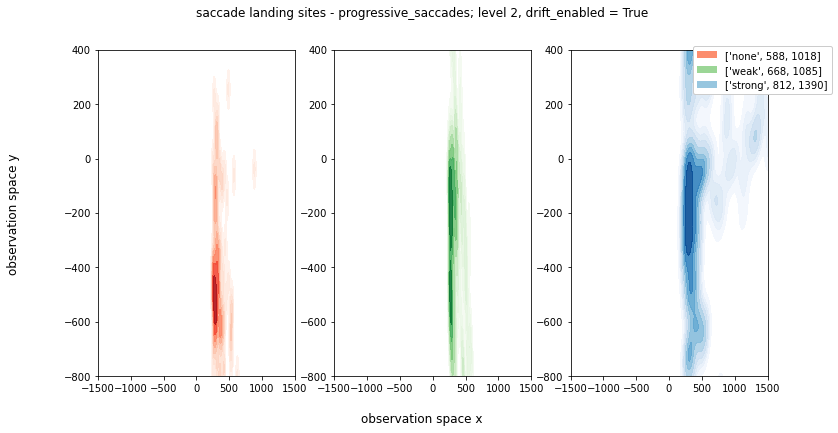

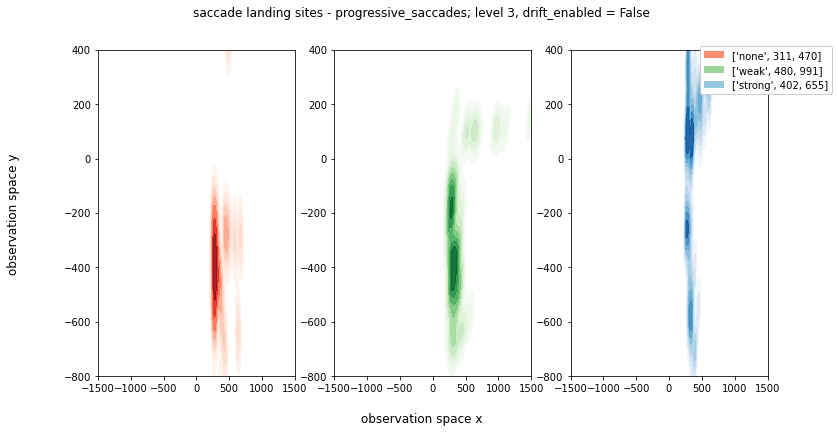

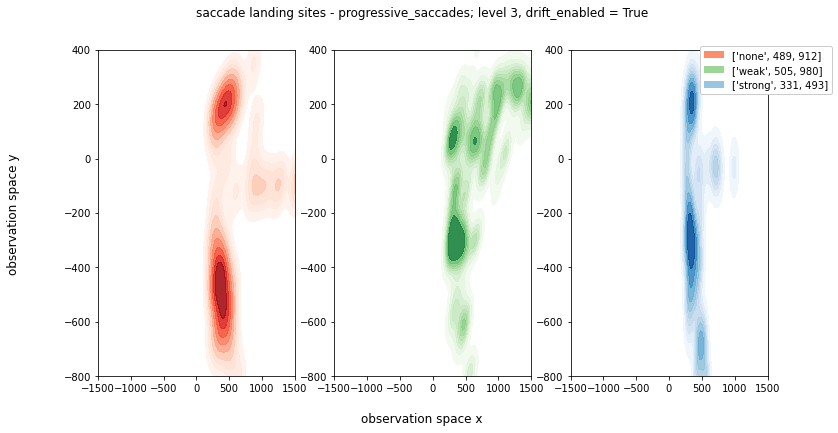

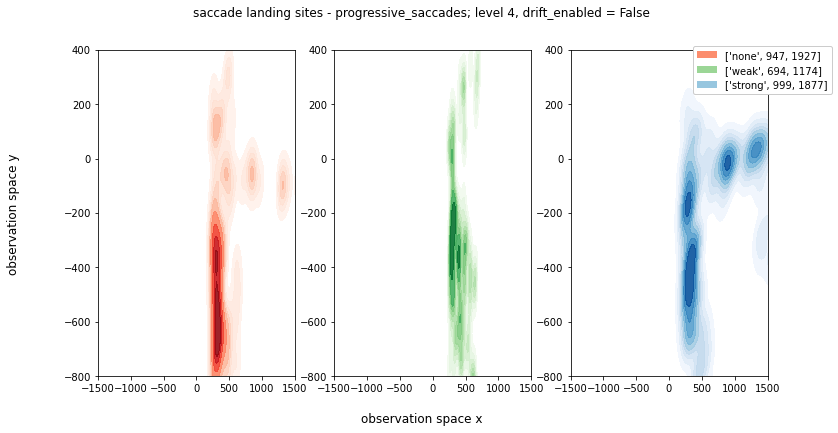

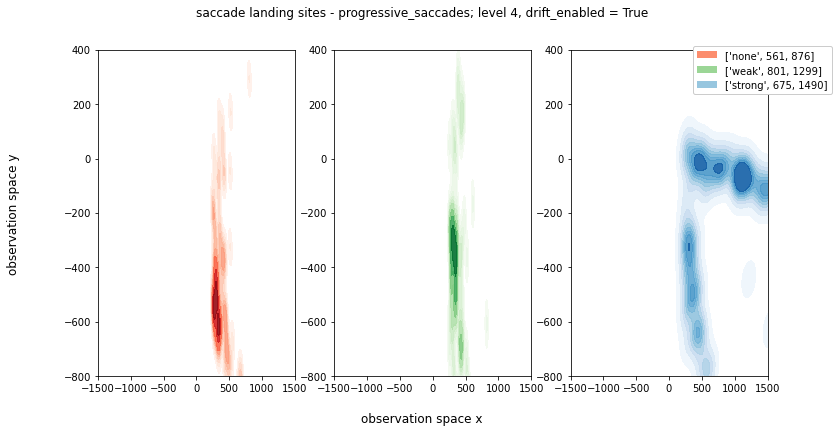

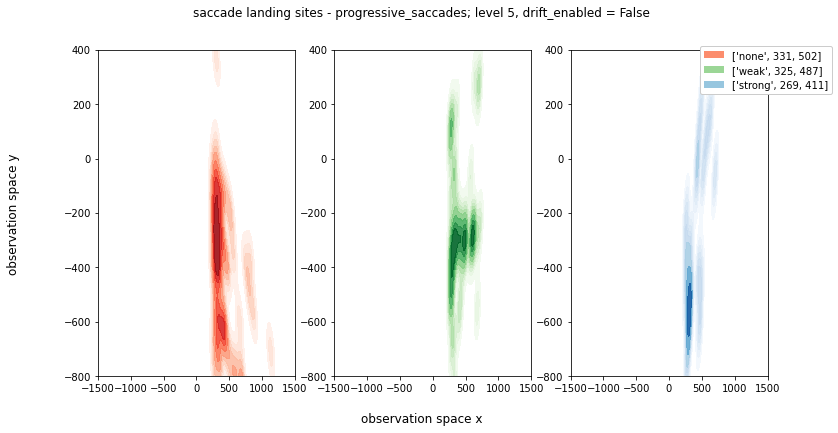

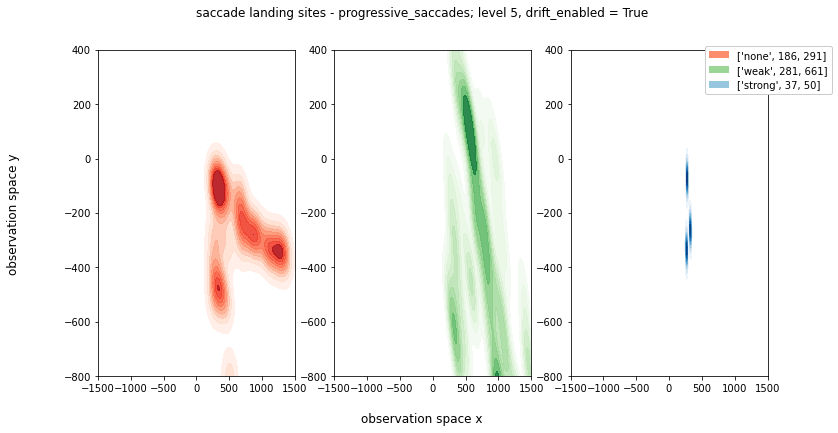

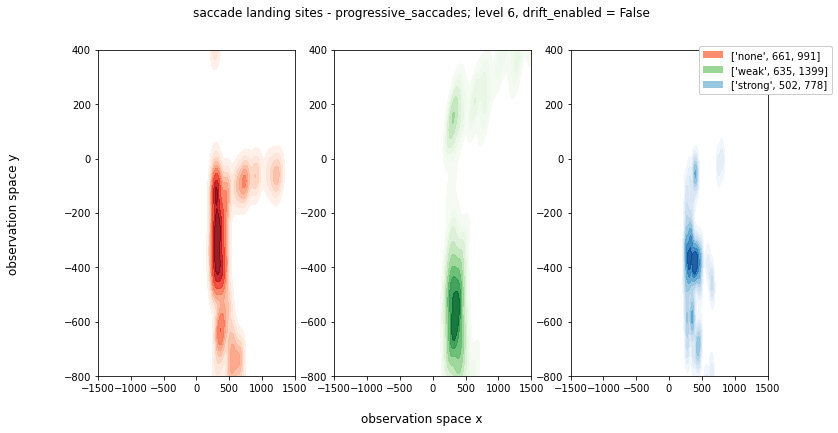

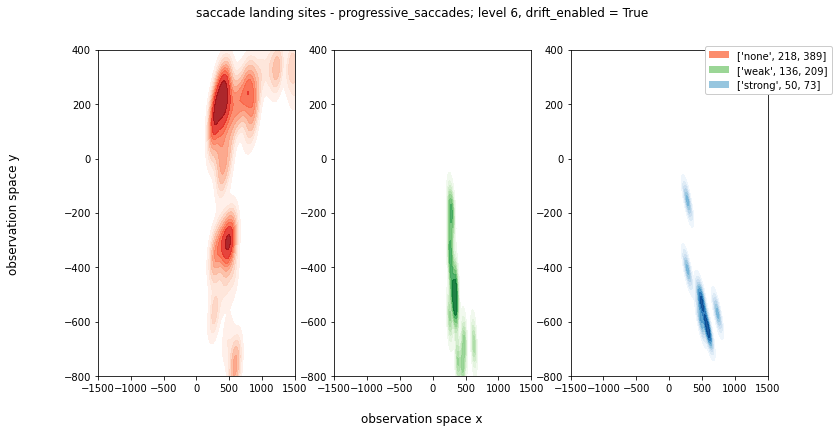

In [42]:
target_levels = [1, 2, 3, 4, 5, 6]
drift_enabled_args = [False, True]


args_list = [target_levels, drift_enabled_args]
arg_combs = list(itertools.product(*args_list))

for arg_comb in arg_combs:
    
    target_level = arg_comb[0]
    drift_enabled = arg_comb[1]

    eye_data = pd.read_csv(f'eye_data/experimental_eye_data_saccades.csv', index_col=False)
    eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled}")[0])]

    eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
    eye_data_weak = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'W']
    eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']

    plot_saccade_landing_sites(eye_data_none, eye_data_weak, eye_data_strong, target_level, drift_enabled, regressive_saccades=False, safe_plot=False)


# Experimental data

In [3]:
root_dir = os.getcwd()

data_dir = "/experimental_data/"

target_string = "output"
target_string_eye_tracking = "eye_tracking"
done_string = "done"

successfull_runs = []

for subdir, dirs, files in os.walk(root_dir+data_dir):
    for file in files:
        if done_string in file:
            successfull_runs.append(file)

        
# triplet coding: level, drift (True vs. False), input noise (None vs. Weak vs. Strong)
# _ done vs. crashed
# experimental trial

In [4]:
successfull_runs

['OK01UE_output_5FN_done_10.csv',
 'OK01UE_output_3FN_done_25.csv',
 'OK01UE_output_6FN_done_16.csv',
 'OK01UE_output_2FS_done_27.csv',
 'OK01UE_output_4FS_done_07.csv',
 'OK01UE_output_4FW_done_36.csv',
 'OK01UE_output_3TS_done_14.csv',
 'OK01UE_output_1FW_done_06.csv',
 'OK01UE_output_6FW_done_02.csv',
 'OK01UE_output_5FS_done_40.csv',
 'OK01UE_output_4TN_done_21.csv',
 'OK01UE_output_1TS_done_32.csv',
 'OK01UE_output_0TS_done_00.csv',
 'OK01UE_output_3FW_done_22.csv',
 'OK01UE_output_3TN_done_00.csv',
 'OK01UE_output_1FN_done_47.csv',
 'OK01UE_output_6TW_done_50.csv',
 'OK01UE_output_5FW_done_30.csv',
 'OK01UE_output_2TS_done_39.csv',
 'OK01UE_output_2FN_done_41.csv',
 'OK01UE_output_5TS_done_15.csv',
 'OK01UE_output_2TN_done_20.csv',
 'OK01UE_output_1FS_done_48.csv',
 'OK01UE_output_2FW_done_18.csv',
 'OK01UE_output_1TN_done_33.csv',
 'OK01UE_output_3TW_done_28.csv',
 'OK01UE_output_2TW_done_31.csv',
 'OK01UE_output_4TW_done_13.csv',
 'OK01UE_output_3FS_done_19.csv',
 'OK01UE_outpu

split successfull_runs by _ and get code ([0]) of trial ([-1]; - cut of .csv). Then use this to read eye_tracking data.

In [6]:
snippets = []

for file_name in successfull_runs:
    temp = file_name.split("_")
    code = temp[0]
    exp_trial = temp[-1]
    exp_trial = exp_trial[:2]  # cut off .csv
    
    snippets.append([code, exp_trial])

In [7]:
snippets

[['OK01UE', '10'],
 ['OK01UE', '25'],
 ['OK01UE', '16'],
 ['OK01UE', '27'],
 ['OK01UE', '07'],
 ['OK01UE', '36'],
 ['OK01UE', '14'],
 ['OK01UE', '06'],
 ['OK01UE', '02'],
 ['OK01UE', '40'],
 ['OK01UE', '21'],
 ['OK01UE', '32'],
 ['OK01UE', '00'],
 ['OK01UE', '22'],
 ['OK01UE', '00'],
 ['OK01UE', '47'],
 ['OK01UE', '50'],
 ['OK01UE', '30'],
 ['OK01UE', '39'],
 ['OK01UE', '41'],
 ['OK01UE', '15'],
 ['OK01UE', '20'],
 ['OK01UE', '48'],
 ['OK01UE', '18'],
 ['OK01UE', '33'],
 ['OK01UE', '28'],
 ['OK01UE', '31'],
 ['OK01UE', '13'],
 ['OK01UE', '19'],
 ['OK01UE', '11'],
 ['OK01UE', '24'],
 ['OK01UE', '04'],
 ['EU29TT1', '21'],
 ['EU29TT1', '29'],
 ['EU29TT1', '24'],
 ['EU29TT1', '12'],
 ['EU29TT1', '51'],
 ['EU29TT1', '00'],
 ['EU29TT1', '50'],
 ['EU29TT1', '41'],
 ['EU29TT1', '15'],
 ['EU29TT1', '13'],
 ['EU29TT1', '40'],
 ['EU29TT1', '10'],
 ['EU29TT1', '18'],
 ['EU29TT1', '33'],
 ['EU29TT1', '39'],
 ['EU29TT1', '17'],
 ['EU29TT1', '19'],
 ['EU29TT1', '45'],
 ['EU29TT1', '14'],
 ['EU29TT1',

In [8]:
temp_df = pd.DataFrame(snippets, columns = ['code', 'trial'])
temp_df

code trial
0    OK01UE    10
1    OK01UE    25
2    OK01UE    16
3    OK01UE    27
4    OK01UE    07
..      ...   ...
821  UD06AD    16
822  UD06AD    13
823  UD06AD    35
824  UD06AD    45
825  UD06AD    23

[826 rows x 2 columns]

In [9]:
# filter the content for trials in temp df
eye_data_successfull_runs = pd.DataFrame()


for id_code in np.unique(temp_df.code):
    successfull_runs = list(temp_df.loc[temp_df['code'] == id_code].trial)
    
    path = root_dir + data_dir + str(id_code) + "/eye_data"
    for subdir, dirs, files in os.walk(path):
        for data_file in files:
            if ".csv" in str(data_file):

                temp = str(data_file).split("_")
                # extract features of run from file_name coding
                level = temp[4][0]
                drift = temp[4][1]
                input_noise = temp[4][2]
                exp_trial = temp[-1]
                exp_trial = exp_trial[:2]
                # check for trial number of successfull trials
                #print(exp_trial, successfull_runs)
                if exp_trial in successfull_runs:

                    #f"experimental_data/{id_code}/eye_data/{data_file}"
                    temp_data = pre_process_eye_data(pd.read_csv((f"experimental_data/{id_code}/eye_data/{data_file}"), index_col=False))
                    temp_data["ID"] = id_code
                    temp_data["level"] = level
                    temp_data["drift"] = drift
                    temp_data["input_noise"] = input_noise

                    eye_data_successfull_runs = pd.concat([eye_data_successfull_runs, temp_data])


In [10]:
eye_data_successfull_runs

TimeTag    LeftEyeX    LeftEyeY  LeftPupilDiameter   RightEyeX  \
0       8555.5115 -146.224121  276.833130          55.789062 -151.429169   
1       8555.5120 -146.333740  276.585815          55.785156 -152.097992   
2       8555.5125 -146.658447  276.880127          55.726562 -152.528595   
3       8555.5130 -146.760925  277.019165          55.718750 -152.446960   
4       8555.5135 -146.859680  277.055298          55.683594 -152.996399   
...           ...         ...         ...                ...         ...   
57898  22783.8610  813.058838  431.165588          98.445312         NaN   
57899  22783.8615  821.868042  453.081024          99.199219         NaN   
57900  22783.8620  837.580322  465.705597          98.875000         NaN   
57901  22783.8625  834.721680  456.473419          98.714844         NaN   
57902  22783.8630  835.644775  455.401367          98.593750         NaN   

        RightEyeY  RightPupilDiameter   DigitalIn  LeftBlink  RightBlink  ...  \
0      248.663208           63.476562  16777215.0        0.0         0.0  ...   
1      248.959839           63.464844  16777215.0        0.0         0.0  ...   
2      248.736328           63.449219  16777215.0        0.0         0.0  ...   
3      248.679810           63.398438  16777215.0        0.0         0.0  ...   
4      249.085571           63.375000  16777215.0        0.0         0.0  ...   
...           ...                 ...         ...        ...         ...  ...   
57898         NaN         9999.000000  16777215.0        0.0         1.0  ...   
57899         NaN         9999.000000  16777215.0        0.0         1.0  ...   
57900         NaN         9999.000000  16777215.0        0.0         1.0  ...   
57901         NaN         9999.000000  16777215.0        0.0         1.0  ...   
57902         NaN         9999.000000  16777215.0        0.0         1.0  ...   

       Saccade  saccadeOnset  N_saccade  saccade_direction_x  \
0          0.0             0        NaN                  NaN   
1          0.0             0        NaN                  NaN   
2          0.0             0        NaN                  NaN   
3          0.0             0        NaN                  NaN   
4          0.0             0        NaN                  NaN   
...        ...           ...        ...                  ...   
57898      0.0             0        NaN                  NaN   
57899      0.0             0        NaN                  NaN   
57900      0.0             0        NaN                  NaN   
57901      0.0             0        NaN                  NaN   
57902      0.0             0        NaN                  NaN   

       saccade_direction_y  saccade_amplitude       ID  level  drift  \
0                      NaN                NaN  AE07EM1      2      T   
1                      NaN                NaN  AE07EM1      2      T   
2                      NaN                NaN  AE07EM1      2      T   
3                      NaN                NaN  AE07EM1      2      T   
4                      NaN                NaN  AE07EM1      2      T   
...                    ...                ...      ...    ...    ...   
57898                  NaN                NaN   ZC12VE      3      T   
57899                  NaN                NaN   ZC12VE      3      T   
57900                  NaN                NaN   ZC12VE      3      T   
57901                  NaN                NaN   ZC12VE      3      T   
57902                  NaN                NaN   ZC12VE      3      T   

       input_noise  
0                N  
1                N  
2                N  
3                N  
4                N  
...            ...  
57898            S  
57899            S  
57900            S  
57901            S  
57902            S  

[64338202 rows x 40 columns]

45199552 rows before; now: 64338202 rows

In [11]:
eye_data_successfull_runs.to_csv('experimental_eye_data_complete.csv', sep=',', index=False)

In [12]:
data_successfull_runs_fixations = eye_data_successfull_runs[eye_data_successfull_runs.fixationOnset == 1].reset_index()
data_successfull_runs_fixations.to_csv('experimental_eye_data_fixations.csv', sep=',')
data_successfull_runs_fixations

index     TimeTag    LeftEyeX    LeftEyeY  LeftPupilDiameter  \
0        362   8555.6925  153.147766  280.140991          51.062500   
1       3010   8557.0165  -61.182617    3.833374          57.843750   
2       3485   8557.2540   -6.799438  220.455322          55.980469   
3       3902   8557.4625  -17.254700  282.880615          51.070312   
4       4835   8557.9290   -6.512329 -155.344238          55.539062   
...      ...         ...         ...         ...                ...   
86785  51718  22780.7710 -270.271942  218.176819          60.839844   
86786  53691  22781.7575 -372.090424  332.374817          61.265625   
86787  54138  22781.9810 -206.885529  390.400208          60.238281   
86788  54625  22782.2245 -207.103180  351.743469          58.187500   
86789  55024  22782.4240 -250.874359  355.179260          58.054688   

        RightEyeX   RightEyeY  RightPupilDiameter   DigitalIn  LeftBlink  ...  \
0      138.066833  263.747314           59.636719  16777215.0        0.0  ...   
1      -26.071381   -5.930054           63.949219  16777215.0        0.0  ...   
2       -5.339569  193.183472           62.375000  16777215.0        0.0  ...   
3      -11.294189  258.508545           57.000000  16777215.0        0.0  ...   
4       21.574677 -168.864441           60.718750  16777215.0        0.0  ...   
...           ...         ...                 ...         ...        ...  ...   
86785   31.836182  207.793091           63.933594  16777215.0        0.0  ...   
86786  -24.934143  294.829834           65.484375  16777215.0        0.0  ...   
86787  225.029602  274.641113           65.113281  16777215.0        0.0  ...   
86788  196.808167  253.705322           62.445312  16777215.0        0.0  ...   
86789  135.444275  255.123169           61.832031  16777215.0        0.0  ...   

       Saccade  saccadeOnset  N_saccade  saccade_direction_x  \
0          0.0             0        NaN                  NaN   
1          0.0             0        NaN                  NaN   
2          0.0             0        NaN                  NaN   
3          0.0             0        NaN                  NaN   
4          0.0             0        NaN                  NaN   
...        ...           ...        ...                  ...   
86785      0.0             0        NaN                  NaN   
86786      0.0             0        NaN                  NaN   
86787      0.0             0        NaN                  NaN   
86788      0.0             0        NaN                  NaN   
86789      0.0             0        NaN                  NaN   

       saccade_direction_y  saccade_amplitude       ID  level  drift  \
0                      NaN                NaN  AE07EM1      2      T   
1                      NaN                NaN  AE07EM1      2      T   
2                      NaN                NaN  AE07EM1      2      T   
3                      NaN                NaN  AE07EM1      2      T   
4                      NaN                NaN  AE07EM1      2      T   
...                    ...                ...      ...    ...    ...   
86785                  NaN                NaN   ZC12VE      3      T   
86786                  NaN                NaN   ZC12VE      3      T   
86787                  NaN                NaN   ZC12VE      3      T   
86788                  NaN                NaN   ZC12VE      3      T   
86789                  NaN                NaN   ZC12VE      3      T   

       input_noise  
0                N  
1                N  
2                N  
3                N  
4                N  
...            ...  
86785            S  
86786            S  
86787            S  
86788            S  
86789            S  

[86790 rows x 41 columns]

In [13]:
data_successfull_runs_saccades = eye_data_successfull_runs[eye_data_successfull_runs.saccadeOnset == 1].reset_index()
data_successfull_runs_saccades.to_csv('experimental_eye_data_saccades.csv', sep=',')
data_successfull_runs_saccades

index     TimeTag    LeftEyeX    LeftEyeY  LeftPupilDiameter  \
0        551   8555.7870  168.241211  215.731567          50.328125   
1       4537   8557.7800   -3.870850  212.010010          52.671875   
2       7554   8559.2885   20.343445  145.206421          57.039062   
3       8710   8559.8665  -26.323425 -356.768677          56.332031   
4      10231   8560.6270    5.696289  -39.843506          58.460938   
...      ...         ...         ...         ...                ...   
43271  51668  22780.7460 -219.626678  135.201233          61.156250   
43272  54072  22781.9480 -272.919952  335.391907          61.179688   
43273  55473  22782.6485 -273.277069  388.391907          59.296875   
43274  56095  22782.9595  211.832764  162.889236          65.246094   
43275  56151  22782.9875  432.167542  220.459259          71.109375   

        RightEyeX    RightEyeY  RightPupilDiameter   DigitalIn  LeftBlink  \
0      212.875549   116.934937           56.882812  16777215.0        0.0   
1       91.835205   189.089722           55.761719  16777215.0        0.0   
2       13.415558   127.965698           64.015625  16777215.0        0.0   
3      128.697144  -232.579895           58.710938  16777215.0        0.0   
4        0.703918   -37.902954           65.367188  16777215.0        0.0   
...           ...          ...                 ...         ...        ...   
43271   29.673462   159.977539           64.019531  16777215.0        0.0   
43272  109.821838   279.531616           65.128906  16777215.0        0.0   
43273  126.701477   132.136108           63.410156  16777215.0        0.0   
43274 -343.036072 -1103.425537           86.445312  16777215.0        0.0   
43275 -309.177368 -1198.360352           86.644531  16777215.0        0.0   

       ...  Saccade  saccadeOnset  N_saccade  saccade_direction_x  \
0      ...      1.0             1        1.0            85.044647   
1      ...      1.0             1        2.0           143.455750   
2      ...      1.0             1        3.0            47.018600   
3      ...      1.0             1        4.0           100.829681   
4      ...      1.0             1        5.0           -12.982697   
...    ...      ...           ...        ...                  ...   
43271  ...      1.0             1       39.0           -20.176971   
43272  ...      1.0             1       40.0            49.223053   
43273  ...      1.0             1       41.0           164.567627   
43274  ...      1.0             1       42.0           120.505264   
43275  ...      1.0             1       43.0            -5.249481   

       saccade_direction_y  saccade_amplitude       ID  level  drift  \
0              -223.696014         239.316733  AE07EM1      2      T   
1              -338.532318         367.673337  AE07EM1      2      T   
2              -295.072754         298.795380  AE07EM1      2      T   
3              -179.928345         206.254294  AE07EM1      2      T   
4               -73.488007          74.625984  AE07EM1      2      T   
...                    ...                ...      ...    ...    ...   
43271            55.995483          59.519781   ZC12VE      3      T   
43272             3.173218          49.325229   ZC12VE      3      T   
43273          -408.498077         440.401162   ZC12VE      3      T   
43274            49.601166         130.314214   ZC12VE      3      T   
43275           -16.569641          17.381314   ZC12VE      3      T   

       input_noise  
0                N  
1                N  
2                N  
3                N  
4                N  
...            ...  
43271            S  
43272            S  
43273            S  
43274            S  
43275            S  

[43276 rows x 41 columns]

In [36]:
data_successfull_runs_fixations.groupby(["level", "drift", "input_noise"]).fixation_duration.mean()

level  drift  input_noise
1      F      N              0.181390
              S              0.233991
              W              0.185051
       T      N              0.334169
              S              0.198964
              W              0.282282
2      F      N              0.306268
              S              0.224205
              W              0.272824
       T      N              0.308337
              S              0.244530
              W              0.308496
3      F      N              0.256494
              S              0.317693
              W              0.294754
       T      N              0.164919
              S              0.245825
              W              0.239144
4      F      N              0.237551
              S              0.197917
              W              0.260584
       T      N              0.250494
              S              0.348798
              W              0.286312
5      F      N              0.293129
              S         

In [32]:
import itertools

# extract all unique levels of varibales
levels = data_successfull_runs.level.unique()
drift_enabled_args = data_successfull_runs.drift.unique()
input_noise_args = data_successfull_runs.input_noise.unique()

# every possible combination of level, drift, and input_noise
args_list = [levels, drift_enabled_args, input_noise_args]
arg_combs = list(itertools.product(*args_list))

# then loop over all unique id_codes
print(arg_combs)

[('2', 'T', 'N'), ('2', 'T', 'W'), ('2', 'T', 'S'), ('2', 'F', 'N'), ('2', 'F', 'W'), ('2', 'F', 'S'), ('5', 'T', 'N'), ('5', 'T', 'W'), ('5', 'T', 'S'), ('5', 'F', 'N'), ('5', 'F', 'W'), ('5', 'F', 'S'), ('4', 'T', 'N'), ('4', 'T', 'W'), ('4', 'T', 'S'), ('4', 'F', 'N'), ('4', 'F', 'W'), ('4', 'F', 'S'), ('6', 'T', 'N'), ('6', 'T', 'W'), ('6', 'T', 'S'), ('6', 'F', 'N'), ('6', 'F', 'W'), ('6', 'F', 'S'), ('3', 'T', 'N'), ('3', 'T', 'W'), ('3', 'T', 'S'), ('3', 'F', 'N'), ('3', 'F', 'W'), ('3', 'F', 'S'), ('1', 'T', 'N'), ('1', 'T', 'W'), ('1', 'T', 'S'), ('1', 'F', 'N'), ('1', 'F', 'W'), ('1', 'F', 'S')]


In [33]:
arg_comb = ''.join(arg_combs[0][0:3])
arg_comb

'2TN'

# SoC data

In [17]:
root_dir = os.getcwd()

data_dir = "/experimental_data/"
done_string = "done"
crashed_string = "crashed"
target_string = "output"

runs = []

for subdir, dirs, files in os.walk(root_dir+data_dir):
    for file in files:
        if done_string in file:
            runs.append(file)
        if crashed_string in file:
            runs.append(file)
#runs

['EU29TT1_output_1TS_done_21.csv',
 'EU29TT1_output_1TN_done_29.csv',
 'EU29TT1_output_2TS_done_24.csv',
 'EU29TT1_output_1FW_done_12.csv',
 'EU29TT1_output_4TW_done_51.csv',
 'EU29TT1_output_5TN_crashed_06.csv',
 'EU29TT1_output_5TS_crashed_25.csv',
 'EU29TT1_output_5TN_crashed_28.csv',
 'EU29TT1_output_0TS_done_00.csv',
 'EU29TT1_output_4TW_crashed_36.csv',
 'EU29TT1_output_3TW_done_50.csv',
 'EU29TT1_output_5TW_crashed_43.csv',
 'EU29TT1_output_3TN_done_41.csv',
 'EU29TT1_output_1TW_done_15.csv',
 'EU29TT1_output_4FN_crashed_02.csv',
 'EU29TT1_output_6TW_crashed_07.csv',
 'EU29TT1_output_4FS_crashed_37.csv',
 'EU29TT1_output_4TW_crashed_47.csv',
 'EU29TT1_output_2TW_done_13.csv',
 'EU29TT1_output_5TW_crashed_27.csv',
 'EU29TT1_output_4FW_done_40.csv',
 'EU29TT1_output_1FN_done_10.csv',
 'EU29TT1_output_1FS_done_18.csv',
 'EU29TT1_output_6TS_crashed_49.csv',
 'EU29TT1_output_6FW_crashed_05.csv',
 'EU29TT1_output_4FN_done_33.csv',
 'EU29TT1_output_5TW_crashed_23.csv',
 'EU29TT1_output

In [18]:
snippets_runs = []

for file_name in runs:
    temp = file_name.split("_")
    code = temp[0]
    exp_trial = temp[-1]
    exp_trial = exp_trial[:2]  # cut off .csv
    
    snippets_runs.append([code, exp_trial])

#snippets_runs

[['EU29TT1', '21'],
 ['EU29TT1', '29'],
 ['EU29TT1', '24'],
 ['EU29TT1', '12'],
 ['EU29TT1', '51'],
 ['EU29TT1', '06'],
 ['EU29TT1', '25'],
 ['EU29TT1', '28'],
 ['EU29TT1', '00'],
 ['EU29TT1', '36'],
 ['EU29TT1', '50'],
 ['EU29TT1', '43'],
 ['EU29TT1', '41'],
 ['EU29TT1', '15'],
 ['EU29TT1', '02'],
 ['EU29TT1', '07'],
 ['EU29TT1', '37'],
 ['EU29TT1', '47'],
 ['EU29TT1', '13'],
 ['EU29TT1', '27'],
 ['EU29TT1', '40'],
 ['EU29TT1', '10'],
 ['EU29TT1', '18'],
 ['EU29TT1', '49'],
 ['EU29TT1', '05'],
 ['EU29TT1', '33'],
 ['EU29TT1', '23'],
 ['EU29TT1', '39'],
 ['EU29TT1', '17'],
 ['EU29TT1', '44'],
 ['EU29TT1', '19'],
 ['EU29TT1', '45'],
 ['EU29TT1', '14'],
 ['EU29TT1', '08'],
 ['EU29TT1', '31'],
 ['EU29TT1', '04'],
 ['EU29TT1', '16'],
 ['EU29TT1', '46'],
 ['EU29TT1', '00'],
 ['EU29TT1', '42'],
 ['EU29TT1', '35'],
 ['EU29TT1', '52'],
 ['EU29TT1', '22'],
 ['EU29TT1', '26'],
 ['EU29TT1', '48'],
 ['EU29TT1', '38'],
 ['EU29TT1', '11'],
 ['EU29TT1', '32'],
 ['EU29TT1', '01'],
 ['EU29TT1', '34'],


In [19]:
temp_df = pd.DataFrame(snippets_runs, columns = ['code', 'trial'])
temp_df

code trial
0     EU29TT1    21
1     EU29TT1    29
2     EU29TT1    24
3     EU29TT1    12
4     EU29TT1    51
...       ...   ...
1415   RE25EK    02
1416   RE25EK    09
1417   RE25EK    11
1418   RE25EK    41
1419   RE25EK    25

[1420 rows x 2 columns]

In [39]:
soc_data = pd.DataFrame()
index=0


for id_code in np.unique(temp_df.code):
    experimental_runs = list(temp_df.loc[temp_df['code'] == id_code].trial)
    
    path = root_dir + data_dir + str(id_code) + "/data"
    for subdir, dirs, files in os.walk(path):
        for data_file in files:
            if ".csv" in str(data_file):

                temp = str(data_file).split("_")
                # extract features of run from file_name coding
                level = temp[2][0]
                drift = temp[2][1]
                input_noise = temp[2][2]
                exp_trial = temp[-1]
                exp_trial = exp_trial[:2]
                done = temp[3]
                
                # writing to a temporal data frame
                temp_data = pd.DataFrame({'ID': [np.nan],
                                          'level': [np.nan],
                                          'drift': [np.nan],
                                          'input_noise': [np.nan], 
                                          'done': [np.nan],
                                          'run': [np.nan], 
                                          'SoC': [np.nan]})
                                         
                opened_file = pre_process_input_data(pd.read_csv((f"experimental_data/{id_code}/data/{data_file}"), index_col=False))
                temp_data["ID"].iloc[0] = id_code
                temp_data["level"].iloc[0] = level
                temp_data["drift"].iloc[0] = drift
                temp_data["input_noise"].iloc[0] = input_noise
                if done == "crashed":
                    temp_data["done"].iloc[0] = False
                elif done == "done":
                    temp_data["done"].iloc[0] = True
                temp_data["run"].iloc[0] = exp_trial
                temp_data["SoC"].iloc[0] = opened_file["SoC"].iloc[-1]

                soc_data = pd.concat([soc_data, temp_data])

soc_data
                

ID level drift input_noise   done run  SoC
0   AE07EM1     3     T           N   True  09  6.0
0   AE07EM1     2     F           S   True  43  6.0
0   AE07EM1     4     T           W   True  46  6.0
0   AE07EM1     5     F           W   True  10  6.0
0   AE07EM1     6     T           W  False  12  4.0
..      ...   ...   ...         ...    ...  ..  ...
0    ZC12VE     4     T           W  False  30  3.0
0    ZC12VE     4     F           S   True  24  7.0
0    ZC12VE     4     T           S   True  54  6.0
0    ZC12VE     5     T           W  False  47  1.0
0    ZC12VE     2     F           W   True  45  7.0

[1317 rows x 7 columns]

In [40]:
#soc_data.to_csv('soc_data.csv', sep=',', index=False)

In [41]:
#soc_df = pd.read_csv('soc_data.csv', index_col=False)
#soc_df

ID  level drift input_noise   done  run  SoC
0     AE07EM1      3     T           N   True    9  6.0
1     AE07EM1      2     F           S   True   43  6.0
2     AE07EM1      4     T           W   True   46  6.0
3     AE07EM1      5     F           W   True   10  6.0
4     AE07EM1      6     T           W  False   12  4.0
...       ...    ...   ...         ...    ...  ...  ...
1312   ZC12VE      4     T           W  False   30  3.0
1313   ZC12VE      4     F           S   True   24  7.0
1314   ZC12VE      4     T           S   True   54  6.0
1315   ZC12VE      5     T           W  False   47  1.0
1316   ZC12VE      2     F           W   True   45  7.0

[1317 rows x 7 columns]

# Plot experimental data

In [ ]:
# 6 possible levels 
N_levels = 6  # 1:6, therefore np.arange(1, N_levels+1)
drift_enabled_args = ['T', 'F']  # T: True vs. F: False
input_noise_args = ['N', 'W', 'S']  # none vs. weak vs. strong

for level_n in np.arange(1, N_levels+1):
    for drift_arg in drift_enabled_args:
        temp_data = eye_data_complete.loc[(eye_data_complete.level == str(level_n)) & (eye_data_complete.drift == drift_arg)]
        
        # create individual dataFrames for each level of input_noise
        temp_data_none = temp_data.loc[temp_data.input_noise == 'N']
        temp_data_weak = temp_data.loc[temp_data.input_noise == 'W']
        temp_data_strong = temp_data.loc[temp_data.input_noise == 'S']
        
        # call plotting function
        #plot_fixation_location_kde(temp_data_none, temp_data_weak, temp_data_strong, level=level_n, drift_enabled=drift_arg, safe_plot=True)
        #plot_saccade_amplitudes(temp_data_none, temp_data_weak, temp_data_strong, level=level_n, drift_enabled=drift_arg, safe_plot=True)
        #plot_saccade_landing_sites(temp_data_none, temp_data_weak, temp_data_strong, level=level_n, drift_enabled=drift_arg, safe_plot=True)    
        #plot_saccade_amplitude_kde(temp_data_none, temp_data_weak, temp_data_strong, level=level_n, drift_enabled=drift_arg, safe_plot=True)

In [11]:
def plot_saccade_amplitude_kde(eye_data_none, eye_data_weak, eye_data_strong, level, drift_enabled, regressive_saccades=False, safe_plot=False, path_to_save_folder=f"{os.getcwd()}/plots/plots_saccade_amplitude_kde/"):    
    
    """
    :param eye_data_none: data of onput noise = none
    :param eye_data_weak: data of onput noise = weak
    :param eye_data_strong: data of onput noise = strong
    :param level: level played
    :param drift_enabled: True vs. False
    :param regressive_saccades: True vs. False; if True regressive saccades are targeted else progressive saccades
    :param safe_plot: True vs. False - determines whether plots are saved or not
    :param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
    IMPORTANT: The function will not raise an error if the runs aren't of the same level and drift condition. It will only consider level and drift passed for labeling
    """   
    if regressive_saccades:
        saccade_type = "regressive_saccades"
    else:
        saccade_type = "progressive_saccades"
    # Grid
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f"Densities of saccade amplitudes - {saccade_type}; level {level} (drift enabled = {drift_enabled})", fontdict={"fontweight": "bold"})


    # axis labels
    ax.set_xlabel("saccade amplitude")
    ax.set_ylabel("Density")

    # plot boundaries:
    lbound = 0
    ubound = 1000
    
    ax.set_xlim([lbound, ubound])

    xaxis = np.linspace(lbound, ubound, 11)
    ax.set_xticks(xaxis)
    
    # Plotting parameters
    colors = ["coral", "lightgreen", "royalblue"]
    colors_p = ["crimson", "green", "blue"]
    color_maps = ["Reds", "Greens", "Blues"]
    input_noise_magnitude = ["none", "weak", "strong"]
    n_saccades = [np.nan, np.nan, np.nan]
    n_target_saccades = [np.nan, np.nan, np.nan]
    
    counter = 0
    
    for temp_eye_data in [eye_data_none, eye_data_weak, eye_data_strong]:
        # reducing data to only respective events of interest (saccade onsets) & filter enormous saccade amplitudes
        saccades = temp_eye_data[(temp_eye_data["saccadeOnset"] == 1.0) & (temp_eye_data["saccade_amplitude"] < 1000)]
        
        # subset target saccades
        if regressive_saccades:
            saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
        else:
            saccades = saccades.loc[saccades["saccade_direction_y"] < 0]
        
        n_saccades[counter] = len(saccades)
        ## insert saccade landing sites
        saccades["saccade_landing_site_x"] = saccades.converging_eye_x + saccades.saccade_direction_x
        saccades["saccade_landing_site_y"] = saccades.converging_eye_y + saccades.saccade_direction_y
        
        #filter for landing sites within level
        saccades = saccades[saccades["saccade_landing_site_x"].between(((34-20)*18), ((34+40+20)*18))]
        # edge=34, scaling=18, observation_space_x=40
        

        # define arrays of saccade amplitudes for respective data
        eye_data_array = np.asarray(saccades.saccade_amplitude)

        # compute hpdi (I went for the smallest interval which contains 25% of the mass)
        eye_data_hpdi_bounds = az.hdi(eye_data_array, 0.25)

        # instatiate KDEs
        kde_init = np.linspace(lbound, ubound, 100)

        eye_data_kde = st.gaussian_kde(eye_data_array)


        # draw KDE

        ax.plot(kde_init, eye_data_kde(kde_init), color=colors[counter], label=input_noise_magnitude[counter])

        # define dataframe for points of eye_data ( now because we can retrieve y-axis limits at this point)
        #y_max = ax.get_ylim()[1]  # 0: bottom; 1: top
        #eye_data_points = {'x': eye_data_array, 'y': [y_max/99]*len(eye_data_array)}  # y_max/99 to plot these a bit above input data points
        #eye_data_points = pd.DataFrame(data=eye_data_points)
        #ax.scatter(eye_data_points.x, eye_data_points.y, marker=".", color=colors[counter])


        # HPDIs:
        point_estimate_eye_data = point_estimate(saccades.time_tag)
        #plt.vlines(point_estimate_eye_data[0], ymin=0, ymax=point_estimate_eye_data[1], color=colors[counter])
        
        counter += 1
        
    ax.legend()

    if safe_plot:
        plt.savefig(f"{path_to_save_folder}saccade_amplitude_kde_{saccade_type}_level_{level}_drift_enabled_{drift_enabled}", dpi=300)
        #plt.close()

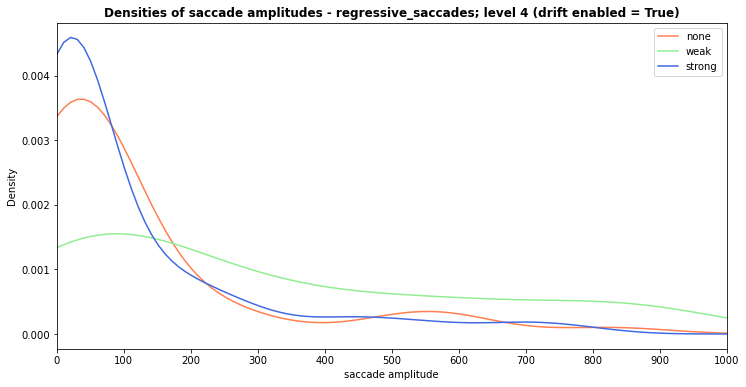

In [36]:
target_level = 4
drift_enabled = True

eye_data = pd.read_csv(f'eye_data/experimental_eye_data_saccades.csv', index_col=False)
eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled}")[0])]

eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
eye_data_weak = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'W']
eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']

plot_saccade_amplitude_kde(eye_data_none, eye_data_weak, eye_data_strong, target_level, drift_enabled, regressive_saccades=True, safe_plot=False)


In [162]:
#target_level = 4
drift_enabled = True

eye_data = pd.read_csv(f'eye_data/experimental_eye_data_fixations.csv', index_col=False)

eye_data['level_difficulty'] = (eye_data.level // 2) + (eye_data.level % 2 > 0)

# categorical sorting
eye_data['drift'] = pd.Categorical(eye_data['drift'], ["F", "T"])
eye_data['input_noise'] = pd.Categorical(eye_data['input_noise'], ["N", "W", "S"])

eye_data.groupby(["level_difficulty", "drift", "input_noise", "exploring_fixation"]).fixation_duration.agg(['mean', 'std'])

mean       std
level_difficulty drift input_noise exploring_fixation                    
1                F     N           0                   0.233455  0.325011
                                   1                   0.310920  0.342292
                       W           0                   0.225355  0.365628
                                   1                   0.300486  0.398279
                       S           0                   0.205087  0.326703
                                   1                   0.344262  0.635132
                 T     N           0                   0.315790  0.412733
                                   1                   0.319231  0.371488
                       W           0                   0.304535  0.395374
                                   1                   0.272278  0.310537
                       S           0                   0.226816  0.309328
                                   1                   0.231487  0.280688
2                F     N           0                   0.236580  0.318607
                                   1                   0.290608  0.276592
                       W           0                   0.272652  0.324915
                                   1                   0.261445  0.279139
                       S           0                   0.235753  0.339107
                                   1                   0.179682  0.268706
                 T     N           0                   0.204473  0.287013
                                   1                   0.285775  0.304004
                       W           0                   0.263218  0.360804
                                   1                   0.329740  0.364706
                       S           0                   0.294181  0.369484
                                   1                   0.348322  0.351560
3                F     N           0                   0.251308  0.331649
                                   1                   0.307017  0.382562
                       W           0                   0.234960  0.305244
                                   1                   0.162683  0.258714
                       S           0                   0.270087  0.305132
                                   1                   0.358348  0.429347
                 T     N           0                   0.253463  0.316825
                                   1                   0.356919  0.417782
                       W           0                   0.176829  0.256644
                                   1                   0.075528  0.170217
                       S           0                   0.337655  0.288843
                                   1                   0.324875  0.235621

In [32]:
def plot_fixation_duration(eye_data_none, eye_data_weak, eye_data_strong, level, drift_enabled,
                           exploring_fixations=True, log_scale=False, safe_plot=False,
                           path_to_save_folder=f"{os.getcwd()}/plots/plota_fixation_duration/"):
    """
    :param eye_data_none: data of input noise = none
    :param eye_data_weak: data of input noise = weak
    :param eye_data_strong: data of input noise = strong
    :param level: level played
    :param drift_enabled: True vs. False
    :param exploring_fixations: True vs. False; if True progressive fixations are considered, else resting fixations
    :param log_scale: False vs. True; whether y axis log scaled
    :param safe_plot: True vs. False - determines whether plots are saved or not
    :param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
    IMPORTANT: The function will not raise an error if the runs aren't of the same level and drift condition. It will only consider level and drift passed for labeling
    """

    if exploring_fixations:
        fixation_type = "exploring_fixations"
    else:
        fixation_type = "resting_fixations"

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.set_title(f"fixation durations - {fixation_type}; level {level}, drift_enabled = {drift_enabled}",
                 fontdict={"fontweight": "bold"})

    # axis labels
    ax.set_xlabel("input noise magnitude")
    ax.set_ylabel("fixation duration (in ms)")

    ax.set_xlim([-1.25, 1.25])
    ax.set_xticks([-0.75, 0, 0.75])
    ax.set_xticklabels(["none", "weak", "strong"])

    if log_scale:
        ax.set_ylim([10 ** -4, 10 ** 1])
        ax.set_yscale("log")

    # Plotting
    colors = ["coral", "lightgreen", "royalblue"]
    colors_p = ["crimson", "green", "blue"]
    color_maps = ["Reds", "Greens", "Blues"]
    input_noise_magnitude = ["none", "weak", "strong"]
    offset = [-0.75, 0, 0.75]
    n_fixations = [np.nan, np.nan, np.nan]
    n_target_fixations = [np.nan, np.nan, np.nan]

    counter = 0

    for eye_data in [eye_data_none, eye_data_weak, eye_data_strong]:

        # all kinds of saccades
        # only consider the ones whichs amplitude is below 800 (arbitrarily chosen - saccades out of screen)
        fixations = eye_data[eye_data["fixationOnset"] >= 1]
        n_fixations[counter] = len(fixations)
        plot_labels = [offset[counter]] * len(fixations)
        fixations["plot_label"] = [offset[counter]] * len(fixations)
        # subset target fixations
        if exploring_fixations:
            target_fixations = fixations.loc[fixations["exploring_fixation"] == 1]
        else:
            target_fixations = fixations.loc[fixations["exploring_fixation"] == 0]
        n_target_fixations[counter] = len(target_fixations)

        # draw on canvas
        ax.scatter(target_fixations.plot_label, target_fixations.fixation_duration, marker=".", color=colors_p[counter],
                   alpha=0.3)
        ax.plot(offset[counter], np.mean(target_fixations.fixation_duration), marker="_", markersize=15,
                color=colors_p[counter], alpha=1.0)

        # display density in violinplot over points
        violin = ax.violinplot(target_fixations.fixation_duration, showextrema=False, positions=[offset[counter]])
        violinparts = violin['bodies']
        for vp in violinparts:
            vp.set_facecolor(colors[counter])
            vp.set_edgecolor(colors[counter])

        counter += 1

    handles = [mpatches.Patch(facecolor=plt.cm.Reds(100),
                              label=[input_noise_magnitude[0], n_target_fixations[0], n_fixations[0]]),
               mpatches.Patch(facecolor=plt.cm.Greens(100),
                              label=[input_noise_magnitude[1], n_target_fixations[1], n_fixations[1]]),
               mpatches.Patch(facecolor=plt.cm.Blues(100),
                              label=[input_noise_magnitude[2], n_target_fixations[2], n_fixations[2]])]
    ax.legend(handles=handles)

    if safe_plot:
        plt.savefig(
            f"{path_to_save_folder}fixation_duration_{fixation_type}_level_{level}_drift_enabled_{drift_enabled}",
            dpi=300)
        plt.close()

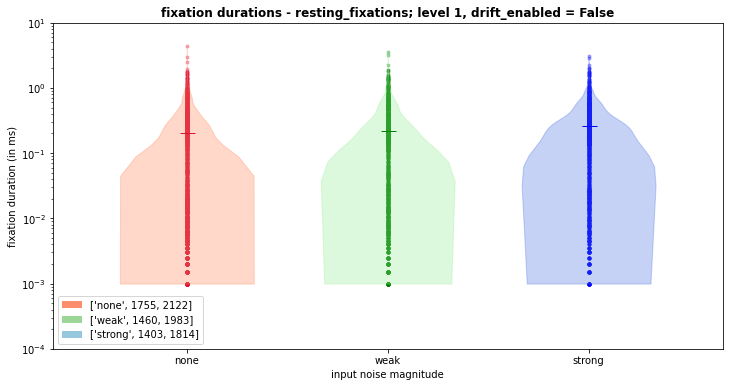

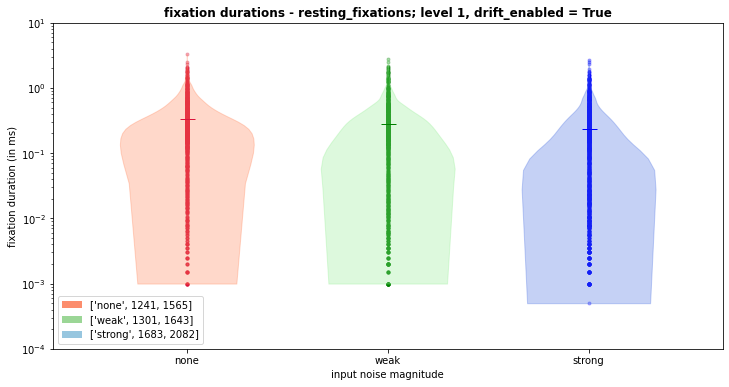

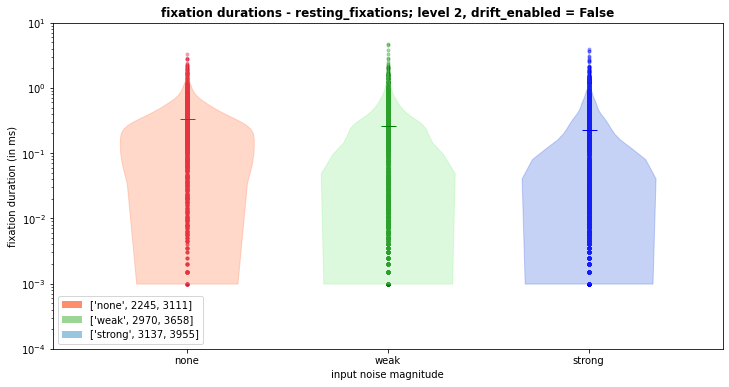

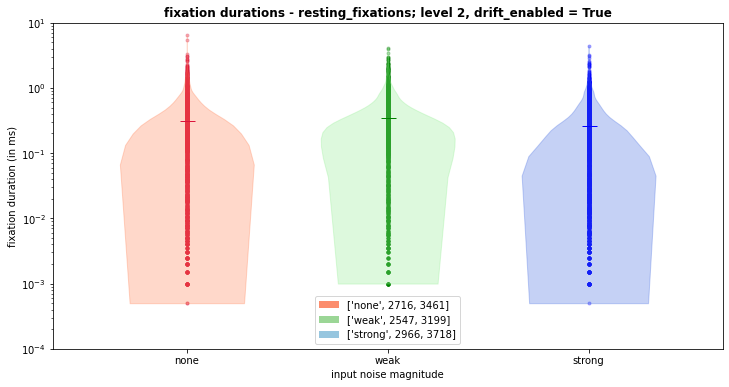

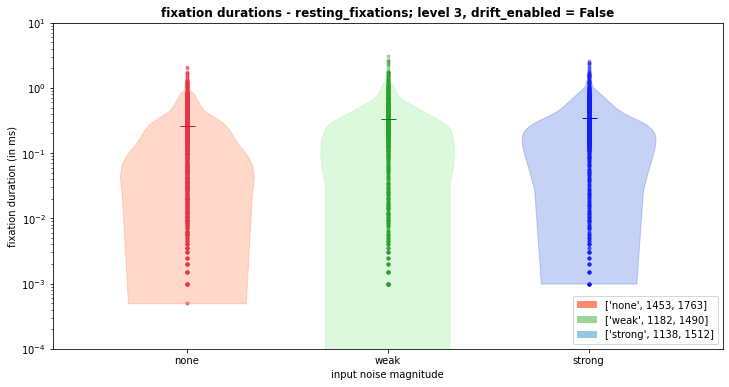

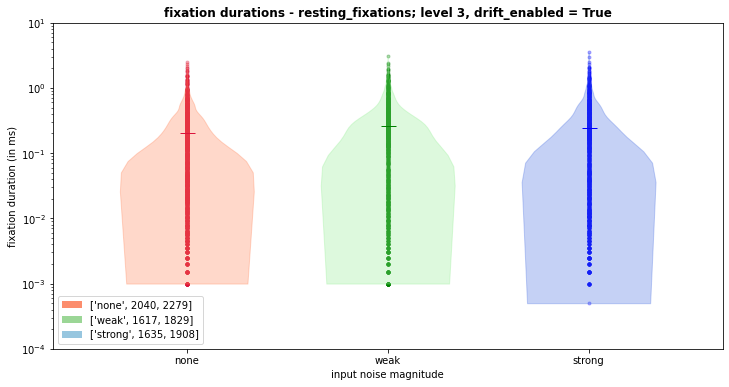

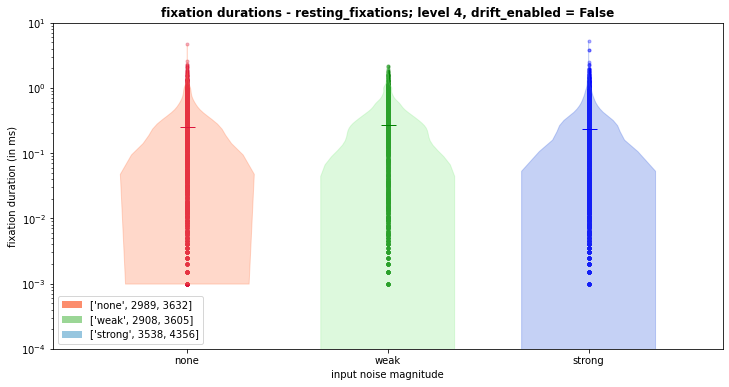

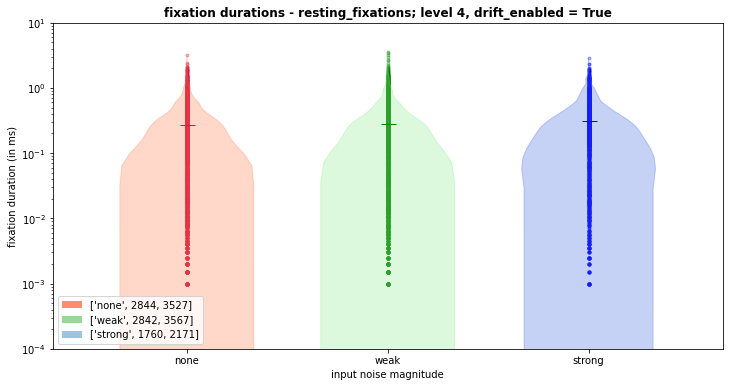

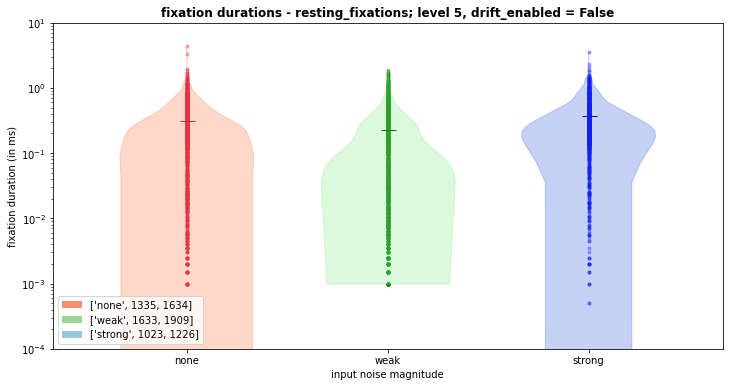

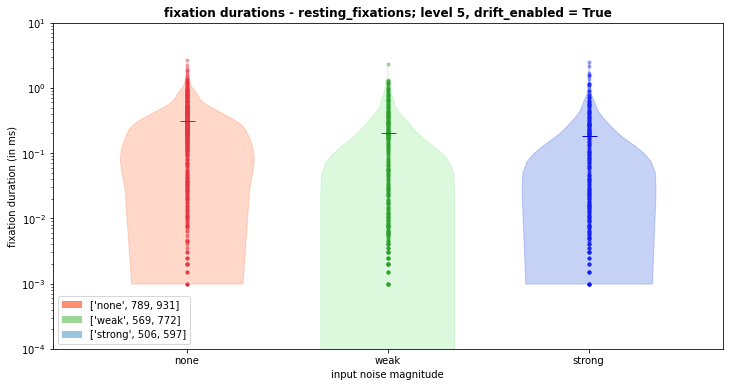

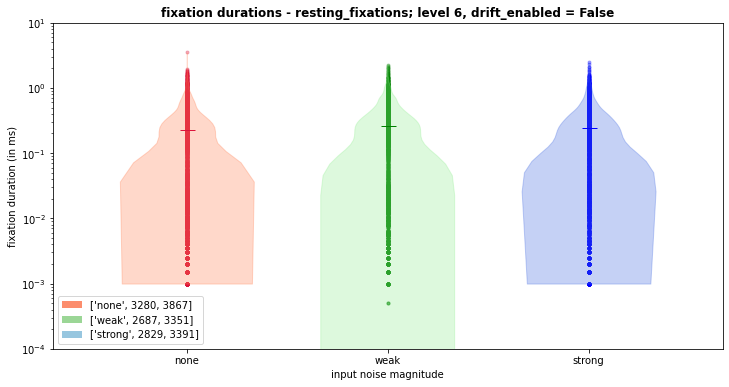

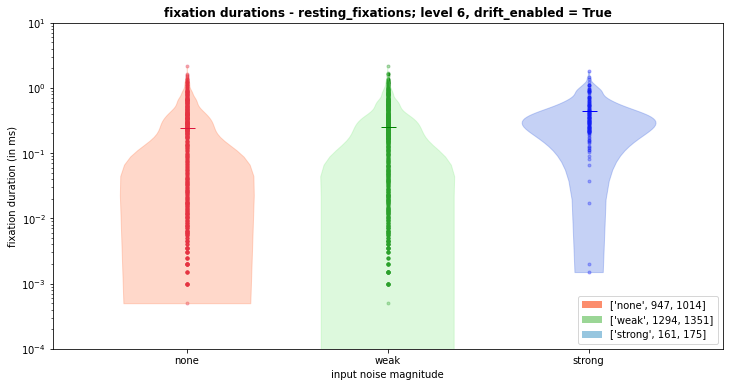

In [33]:
target_levels = [1, 2, 3, 4, 5, 6]
drift_enabled_args = [False, True]


args_list = [target_levels, drift_enabled_args]
arg_combs = list(itertools.product(*args_list))

for arg_comb in arg_combs:
    
    target_level = arg_comb[0]
    drift_enabled = arg_comb[1]

    eye_data = pd.read_csv(f'eye_data/experimental_eye_data_fixations.csv', index_col=False)
    eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled}")[0])]

    eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
    eye_data_weak = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'W']
    eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']

    plot_fixation_duration(eye_data_none, eye_data_weak, eye_data_strong, target_level, drift_enabled, exploring_fixations=False, log_scale=True, safe_plot=False)


In [49]:
root_dir = os.getcwd()
data_dir = "/experimental_data/"

button_press_data = pd.DataFrame()


for id_code in np.unique(temp_df.code):
    successfull_runs = list(temp_df.loc[temp_df['code'] == id_code].trial)
    
    path = root_dir + data_dir + str(id_code) + "/data"
    for subdir, dirs, files in os.walk(path):
        for data_file in files:
            if ".csv" in str(data_file):
                
                null_data = {"ID":[np.nan], "level":[np.nan], "drift":[np.nan], "input_noise":[np.nan], "done":[np.nan], "SoC":[np.nan]}
                temp_data = pd.DataFrame(data=null_data)
                
                temp = str(data_file).split("_")
                # extract features of run from file_name coding
                temp_data.ID = temp[0]
                temp_data.level = temp[2][0]
                temp_data.drift = temp[2][1]
                temp_data.input_noise = temp[2][2]
                temp_data.done = temp[3]
                
                soc_data = pd.read_csv(f"experimental_data/{id_code}/data/{data_file}", index_col=False)
                temp_data.SoC = soc_data.iloc[-1].SoC
                
                button_press_data = pd.concat([button_press_data, temp_data])

button_press_data = button_press_data.reset_index()
button_press_data = button_press_data.drop("index", axis=1)
#button_press_data.to_csv("aggregated_soc_data.csv", sep=',', index=False)

# Earth mover's distance

In [54]:
# target_levels = [1, 2, 3, 4, 5, 6]
target_level = 4
#drift_enabled_args = [False, True]
drift_enabled = True

#args_list = [target_levels, drift_enabled_args]
#arg_combs = list(itertools.product(*args_list))

#for arg_comb in arg_combs:
    
#target_level = arg_comb[0]
#drift_enabled = arg_comb[1]

eye_data = pd.read_csv(f'eye_data/experimental_eye_data_fixations.csv', index_col=False)
eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled}")[0])]

# differentiate input noise magnitudes
eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
fixations_none = eye_data_none[eye_data_none["fixationOnset"] >= 1]
target_fixations_none = fixations_none.loc[fixations_none["exploring_fixation"] == 0]

eye_data_weak = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'W']
fixations_weak = eye_data_weak[eye_data_weak["fixationOnset"] >= 1]
target_fixations_weak = fixations_weak.loc[fixations_weak["exploring_fixation"] == 0]

eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']
fixations_strong = eye_data_strong[eye_data_strong["fixationOnset"] >= 1]
target_fixations_strong = fixations_strong.loc[fixations_strong["exploring_fixation"] == 0]


wasserstein_distance = st.wasserstein_distance(target_fixations_weak.fixation_duration, target_fixations_strong.fixation_duration)
print(wasserstein_distance)


0.03908947724076979


In [13]:
def compute_wasserstein_distance_fixations(eye_data, target_level, drift_enabled_arg):
    eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled_arg}")[0])]
    
    # differentiate input noise magnitudes
    eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
    fixations_none = eye_data_none[eye_data_none["fixationOnset"] >= 1]
    target_fixations_none = fixations_none.loc[fixations_none["exploring_fixation"] == 0]

    eye_data_weak = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'W']
    fixations_weak = eye_data_weak[eye_data_weak["fixationOnset"] >= 1]
    target_fixations_weak = fixations_weak.loc[fixations_weak["exploring_fixation"] == 0]

    eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']
    fixations_strong = eye_data_strong[eye_data_strong["fixationOnset"] >= 1]
    target_fixations_strong = fixations_strong.loc[fixations_strong["exploring_fixation"] == 0]
    
    return st.wasserstein_distance(target_fixations_none.fixation_duration, target_fixations_strong.fixation_duration)
    

In [113]:
eye_data_fixations = pd.read_csv(f'eye_data/experimental_eye_data_fixations.csv', index_col=False)

In [114]:
target_levels = [1, 2, 3, 4, 5, 6]
drift_enabled_args = [False, True]

args_list = [target_levels, drift_enabled_args]
arg_combs = list(itertools.product(*args_list))

wasserstein_distances_fixations = []

for arg_comb in arg_combs:
    
    target_level = arg_comb[0]
    drift_enabled_arg = arg_comb[1]
    
    wasserstein_distance = compute_wasserstein_distance_fixations(eye_data_fixations, target_level, drift_enabled_arg)
    
    features = [target_level, drift_enabled_arg, wasserstein_distance]
    
    wasserstein_distances_fixations.append(features)


In [115]:
wasserstein_distances_fixations

[[1, False, 0.05612914897461741],
 [1, True, 0.10294863624153153],
 [2, False, 0.10562392274688065],
 [2, True, 0.05084085306027065],
 [3, False, 0.0830792424497282],
 [3, True, 0.04183248785753241],
 [4, False, 0.014653975496396479],
 [4, True, 0.043118354430418046],
 [5, False, 0.07081472206659961],
 [5, True, 0.13356667267804945],
 [6, False, 0.016994019529850107],
 [6, True, 0.1930725501255171]]

In [14]:
def compute_wasserstein_distance_saccades(eye_data, target_level, drift_enabled_arg, regressive_saccades=True):
    eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled_arg}")[0])]
    
    # differentiate input noise magnitudes
    eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
    saccades_none = eye_data_none[(eye_data_none["saccadeOnset"] >= 1) & (eye_data_none.saccade_amplitude < 800)]
    if regressive_saccades:
        target_saccades_none = saccades_none.loc[saccades_none["saccade_direction_y"] >= 0]
    else:
        target_saccades_none = saccades_none.loc[saccades_none["saccade_direction_y"] < 0]

    eye_data_weak = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'W']
    saccades_weak = eye_data_weak[(eye_data_weak["saccadeOnset"] >= 1) & (eye_data_weak.saccade_amplitude < 800)]
    if regressive_saccades:
        target_saccades_weak = saccades_weak.loc[saccades_weak["saccade_direction_y"] >= 0]
    else:
        target_saccades_weak = saccades_weak.loc[saccades_weak["saccade_direction_y"] < 0]

    eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']
    saccades_strong = eye_data_strong[(eye_data_strong["saccadeOnset"] >= 1) & (eye_data_strong.saccade_amplitude < 800)]
    if regressive_saccades:
        target_saccades_strong = saccades_strong.loc[saccades_strong["saccade_direction_y"] >= 0]
    else:
        target_saccades_strong = saccades_strong.loc[saccades_strong["saccade_direction_y"] < 0]
    
    return st.wasserstein_distance(target_saccades_none.saccade_amplitude, target_saccades_strong.saccade_amplitude)
    

In [65]:
eye_data_saccades = pd.read_csv(f'eye_data/experimental_eye_data_saccades.csv', index_col=False)

In [119]:
target_levels = [1, 2, 3, 4, 5, 6]
drift_enabled_args = [False, True]

args_list = [target_levels, drift_enabled_args]
arg_combs = list(itertools.product(*args_list))

wasserstein_distances_saccades = []

for arg_comb in arg_combs:
    
    target_level = arg_comb[0]
    drift_enabled_arg = arg_comb[1]
    
    wasserstein_distance = compute_wasserstein_distance_saccades(eye_data_saccades, target_level, drift_enabled_arg)
    
    features = [target_level, drift_enabled_arg, wasserstein_distance]
    
    wasserstein_distances_saccades.append(features)

In [120]:
wasserstein_distances_saccades

[[1, False, 38.824509675843835],
 [1, True, 10.84630819875276],
 [2, False, 20.272471857673096],
 [2, True, 41.62217645849397],
 [3, False, 18.034236997549257],
 [3, True, 27.240422683247125],
 [4, False, 12.415103375770522],
 [4, True, 18.558695045079922],
 [5, False, 26.796750622635134],
 [5, True, 47.351081639303224],
 [6, False, 7.511386090587241],
 [6, True, 69.51685471188802]]

In [34]:
def KL(P,Q):
    '''Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0.'''
     
    epsilon = 0.00001
    # You may want to instead make copies to avoid changing the np arrays.

    P = P+epsilon
    Q = Q+epsilon

    divergence = np.sum(P*np.log(P/Q))
        
    return divergence

In [63]:
def compute_kl_divergence_saccades(eye_data, target_level, drift_enabled_arg, regressive_saccades=True):
    eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled_arg}")[0])]
    
    # differentiate input noise magnitudes
    eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
    saccades_none = eye_data_none[(eye_data_none["saccadeOnset"] >= 1) & (eye_data_none.saccade_amplitude < 800)]
    if regressive_saccades:
        target_saccades_none = saccades_none.loc[saccades_none["saccade_direction_y"] >= 0]
    else:
        target_saccades_none = saccades_none.loc[saccades_none["saccade_direction_y"] < 0]

    eye_data_weak = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'W']
    saccades_weak = eye_data_weak[(eye_data_weak["saccadeOnset"] >= 1) & (eye_data_weak.saccade_amplitude < 800)]
    if regressive_saccades:
        target_saccades_weak = saccades_weak.loc[saccades_weak["saccade_direction_y"] >= 0]
    else:
        target_saccades_weak = saccades_weak.loc[saccades_weak["saccade_direction_y"] < 0]

    eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']
    saccades_strong = eye_data_strong[(eye_data_strong["saccadeOnset"] >= 1) & (eye_data_strong.saccade_amplitude < 800)]
    if regressive_saccades:
        target_saccades_strong = saccades_strong.loc[saccades_strong["saccade_direction_y"] >= 0]
    else:
        target_saccades_strong = saccades_strong.loc[saccades_strong["saccade_direction_y"] < 0]
    
    # sampling
    n_samples = 1000  # arbitrarily high number of samples
    ## gaussian kernel
    ### none
    kde_none = st.gaussian_kde(target_saccades_none.saccade_amplitude)
    samples_none = np.linspace(min(target_saccades_none.saccade_amplitude), max(target_saccades_none.saccade_amplitude), n_samples)
    probs_none = kde_none.evaluate(samples_none)
    
    ### strong
    kde_strong = st.gaussian_kde(target_saccades_strong.saccade_amplitude)
    samples_strong = np.linspace(min(target_saccades_strong.saccade_amplitude), max(target_saccades_strong.saccade_amplitude), n_samples)
    probs_strong = kde_strong.evaluate(samples_strong)
    
    kl_divergence = st.entropy(pk=samples_strong, qk=samples_none)
    
    return kl_divergence
    

In [64]:
target_levels = [1, 2, 3, 4, 5, 6]
drift_enabled_args = [False, True]

args_list = [target_levels, drift_enabled_args]
arg_combs = list(itertools.product(*args_list))

kl_divergences_saccades = []

for arg_comb in arg_combs:
    
    target_level = arg_comb[0]
    drift_enabled_arg = arg_comb[1]
    
    kl_divergence = compute_kl_divergence_saccades(eye_data_saccades, target_level, drift_enabled_arg)
    
    features = [target_level, drift_enabled_arg, kl_divergence]
    
    kl_divergences_saccades.append(features)
    

1000 1000
1000 1000
1000 1000
1000 1000
1000 1000
1000 1000
1000 1000
1000 1000
1000 1000
1000 1000
1000 1000
1000 1000


In [62]:
kl_divergences_saccades

[[1, False, 1.8380803496982292e-16],
 [1, True, -1.1593440032922554e-16],
 [2, False, 2.7907695062686664e-16],
 [2, True, 1.632996929760014e-16],
 [3, False, -5.652046509608722e-17],
 [3, True, 6.76495896338262e-17],
 [4, False, 1.5945869916448043e-16],
 [4, True, 1.2211408616579278e-16],
 [5, False, 4.390793145597621e-17],
 [5, True, 2.4524517988392357e-06],
 [6, False, 7.450141049070701e-17],
 [6, True, inf]]

In [216]:
id_code = 'AE07EM1'
done_ = 'crashed'
n_run = 39
arg_comb = '5TW'

input_data = pd.read_csv(f'experimental_data/{id_code}/data/{id_code}_output_{arg_comb}_{done_}_{n_run:0>2}.csv', index_col=False)
input_data_ = pre_process_input_data(input_data)

eye_data = pd.read_csv(f'experimental_data/{id_code}/eye_data/{id_code}_eye_tracking_output_{arg_comb}_{n_run:0>2}.csv', index_col=False)
eye_data_ = pre_process_eye_data(eye_data)

eye_data_.converging_eye_x_adjusted.fillna(method='ffill', inplace=True)
eye_data_.converging_eye_y_adjusted.fillna(method='ffill', inplace=True)

eye_data_.converging_eye_x_adjusted.fillna(method='bfill', inplace=True)
eye_data_.converging_eye_y_adjusted.fillna(method='bfill', inplace=True)

factor = math.floor(len(eye_data_) / len(input_data_))

result = []
for frame in range(len(input_data_)):
    eye_data_subset = eye_data_[frame * factor: frame * factor + factor]
    x_coord = point_estimate(eye_data_subset.converging_eye_x_adjusted)[0]
    y_coord = point_estimate(eye_data_subset.converging_eye_y_adjusted)[0]
    x_coord_diff_mean = (eye_data_subset.converging_eye_x_adjusted.iloc[-1] - eye_data_subset.converging_eye_x_adjusted.iloc[0])
    
    result.append([frame, x_coord, y_coord, x_coord_diff_mean])

eye_pos_aggregated = pd.DataFrame(result, columns=['frame', 'converging_eye_x_adjusted', 'converging_eye_y_adjusted', 'x_coord_diff_mean'])

SingularMatrixError; numpy.linalg.LinAlgError: singular matrix; no variance in data
SingularMatrixError; numpy.linalg.LinAlgError: singular matrix; no variance in data
SingularMatrixError; numpy.linalg.LinAlgError: singular matrix; no variance in data
SingularMatrixError; numpy.linalg.LinAlgError: singular matrix; no variance in data
SingularMatrixError; numpy.linalg.LinAlgError: singular matrix; no variance in data
SingularMatrixError; numpy.linalg.LinAlgError: singular matrix; no variance in data
SingularMatrixError; numpy.linalg.LinAlgError: singular matrix; no variance in data
SingularMatrixError; numpy.linalg.LinAlgError: singular matrix; no variance in data
SingularMatrixError; numpy.linalg.LinAlgError: singular matrix; no variance in data
SingularMatrixError; numpy.linalg.LinAlgError: singular matrix; no variance in data
SingularMatrixError; numpy.linalg.LinAlgError: singular matrix; no variance in data
SingularMatrixError; numpy.linalg.LinAlgError: singular matrix; no variance 

In [165]:
eye_pos_aggregated

frame  converging_eye_x_adjusted  converging_eye_y_adjusted
0        0                 748.073761                 382.326782
1        1                 748.073761                 382.326782
2        2                 748.073761                 382.326782
3        3                 748.073761                 382.326782
4        4                 748.073761                 382.326782
..     ...                        ...                        ...
549    549                1123.960587                 418.165649
550    550                1123.960587                 418.165649
551    551                1123.960587                 418.165649
552    552                1123.960587                 418.165649
553    553                1123.960587                 418.165649

[554 rows x 3 columns]

In [166]:
input_data_.head()

frame  trial  attempt  time_played     time_tag  level_size_y  player_pos  \
0      0      5        2     0.001966  8082.745181          9018  [954, -86]   
1      1      5        2     0.017143  8082.745181          9018  [954, -82]   
2      2      5        2     0.033230  8082.745181          9018  [954, -78]   
3      3      5        2     0.049319  8082.745181          9018  [954, -74]   
4      4      5        2     0.066240  8082.745181          9018  [954, -70]   

   collision current_input  drift_enabled  ...  visible_obstacles  \
0      False           NaN           True  ...                 []   
1      False           NaN           True  ...                 []   
2      False           NaN           True  ...                 []   
3      False           NaN           True  ...                 []   
4      False           NaN           True  ...                 []   

   adjacent_wall_tiles_x_pos visible_drift_tiles  SoC adjusted_time_tag  \
0                        NaN                  []  NaN       8082.747147   
1                        NaN                  []  NaN       8082.762324   
2                        NaN                  []  NaN       8082.778411   
3                        NaN                  []  NaN       8082.794500   
4                        NaN                  []  NaN       8082.811421   

   start_input N_input  input_change  drift_tile_onset  \
0          NaN     NaN           NaN                 0   
1          NaN     NaN           NaN                 0   
2          NaN     NaN           NaN                 0   
3          NaN     NaN           NaN                 0   
4          NaN     NaN           NaN                 0   

   second_drift_tile_onset  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  

[5 rows x 24 columns]

In [217]:
final = input_data_.merge(eye_pos_aggregated, on='frame', how='left')

In [218]:
final_filtered = final[['frame', 'time_played', 'player_pos', 'current_input', 'drift_tile_onset', 'converging_eye_x_adjusted', 'converging_eye_y_adjusted', 'x_coord_diff_mean']]


In [219]:
final_filtered

frame  time_played  player_pos current_input  drift_tile_onset  \
0        0     0.001966  [954, -86]           NaN                 0   
1        1     0.017143  [954, -82]           NaN                 0   
2        2     0.033230  [954, -78]           NaN                 0   
3        3     0.049319  [954, -74]           NaN                 0   
4        4     0.066240  [954, -70]           NaN                 0   
..     ...          ...         ...           ...               ...   
549    549     9.360122  [954, 270]          Left                 0   
550    550     9.376518  [954, 270]           NaN                 0   
551    551     9.394463  [954, 270]           NaN                 0   
552    552     9.410065  [954, 270]           NaN                 0   
553    553    11.472325  [954, 270]           NaN                 0   

     converging_eye_x_adjusted  converging_eye_y_adjusted  x_coord_diff_mean  
0                   748.073761                 382.326782                0.0  
1                   748.073761                 382.326782                0.0  
2                   748.073761                 382.326782                0.0  
3                   748.073761                 382.326782                0.0  
4                   748.073761                 382.326782                0.0  
..                         ...                        ...                ...  
549                1123.960587                 418.165649                0.0  
550                1123.960587                 418.165649                0.0  
551                1123.960587                 418.165649                0.0  
552                1123.960587                 418.165649                0.0  
553                1123.960587                 418.165649                0.0  

[554 rows x 8 columns]

In [220]:
final_filtered.corr()

frame  time_played  drift_tile_onset  \
frame                      1.000000     0.999455          0.044789   
time_played                0.999455     1.000000          0.044880   
drift_tile_onset           0.044789     0.044880          1.000000   
converging_eye_x_adjusted  0.504456     0.505658          0.040183   
converging_eye_y_adjusted -0.057724    -0.059262          0.041097   
x_coord_diff_mean         -0.004523    -0.004472         -0.000857   

                           converging_eye_x_adjusted  \
frame                                       0.504456   
time_played                                 0.505658   
drift_tile_onset                            0.040183   
converging_eye_x_adjusted                   1.000000   
converging_eye_y_adjusted                   0.038960   
x_coord_diff_mean                           0.007266   

                           converging_eye_y_adjusted  x_coord_diff_mean  
frame                                      -0.057724          -0.004523  
time_played                                -0.059262          -0.004472  
drift_tile_onset                            0.041097          -0.000857  
converging_eye_x_adjusted                   0.038960           0.007266  
converging_eye_y_adjusted                   1.000000          -0.001270  
x_coord_diff_mean                          -0.001270           1.000000

## button presses and eye_pos_x corr

In [225]:
button_presses = final_filtered[~final_filtered.current_input.isna()]
button_presses

frame  time_played  player_pos current_input  drift_tile_onset  \
376    376     6.361496  [954, 270]         Right                 0   
377    377     6.378477  [954, 270]         Right                 0   
378    378     6.395358  [954, 270]         Right                 0   
379    379     6.411994  [954, 270]         Right                 0   
380    380     6.429028  [954, 270]         Right                 0   
..     ...          ...         ...           ...               ...   
545    545     9.294441  [954, 270]          Left                 0   
546    546     9.310789  [954, 270]          Left                 0   
547    547     9.326883  [954, 270]          Left                 0   
548    548     9.343832  [954, 270]          Left                 0   
549    549     9.360122  [954, 270]          Left                 0   

     converging_eye_x_adjusted  converging_eye_y_adjusted  x_coord_diff_mean  
376                 917.453368                 308.120818          -2.215485  
377                 916.651291                 306.247646          -1.381256  
378                 916.368525                 305.903013           0.427872  
379                 915.560033                 304.077622          -1.183228  
380                 914.282398                 301.528934          -1.019699  
..                         ...                        ...                ...  
545                1123.960587                 418.165649           0.000000  
546                1123.960587                 418.165649           0.000000  
547                1123.960587                 418.165649           0.000000  
548                1123.960587                 418.165649           0.000000  
549                1123.960587                 418.165649           0.000000  

[125 rows x 8 columns]

In [226]:
button_presses.current_input = button_presses.current_input.replace('Left', -1).replace('Right', 1)

In [223]:
button_presses.x_coord_diff_mean[button_presses.x_coord_diff_mean<0] = -1
button_presses.x_coord_diff_mean[button_presses.x_coord_diff_mean>0]=1

In [227]:
button_presses.corr()

frame  time_played  current_input  \
frame                      1.000000     0.999801      -0.930872   
time_played                0.999801     1.000000      -0.927458   
current_input             -0.930872    -0.927458       1.000000   
drift_tile_onset           0.120552     0.122617      -0.080902   
converging_eye_x_adjusted  0.826348     0.824214      -0.887810   
converging_eye_y_adjusted  0.002816    -0.000029       0.074493   
x_coord_diff_mean          0.027026     0.026961      -0.039809   

                           drift_tile_onset  converging_eye_x_adjusted  \
frame                              0.120552                   0.826348   
time_played                        0.122617                   0.824214   
current_input                     -0.080902                  -0.887810   
drift_tile_onset                   1.000000                   0.074002   
converging_eye_x_adjusted          0.074002                   1.000000   
converging_eye_y_adjusted         -0.004456                  -0.011620   
x_coord_diff_mean                  0.001050                   0.031990   

                           converging_eye_y_adjusted  x_coord_diff_mean  
frame                                       0.002816           0.027026  
time_played                                -0.000029           0.026961  
current_input                               0.074493          -0.039809  
drift_tile_onset                           -0.004456           0.001050  
converging_eye_x_adjusted                  -0.011620           0.031990  
converging_eye_y_adjusted                   1.000000          -0.043074  
x_coord_diff_mean                          -0.043074           1.000000

high positive (negative beacuse of moving the environment) correlation of where eye are on horizontal axis and input (left vs. right)

In [66]:
eye_data = pd.read_csv(f'eye_data/experimental_eye_data_saccades.csv', index_col=False)

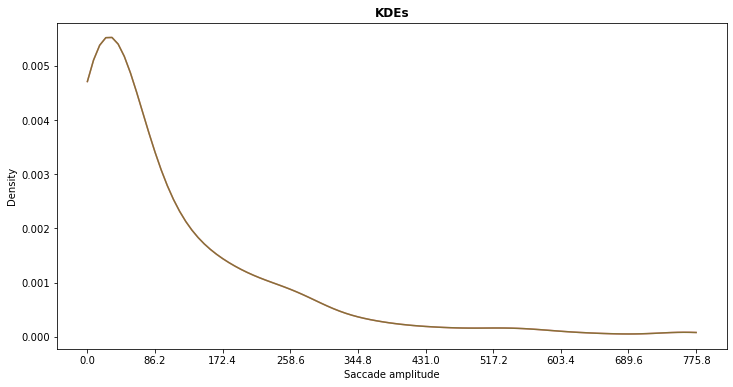

In [75]:
target_level = 4
drift_enabled_args = True
regressive_saccades = True

eye_data_targetlevel = eye_data[(eye_data.level == target_level) & (eye_data.drift == str(f"{drift_enabled_arg}")[0])]
    
# differentiate input noise magnitudes
eye_data_none = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'N']
saccades_none = eye_data_none[(eye_data_none["saccadeOnset"] >= 1) & (eye_data_none.saccade_amplitude < 800)]
if regressive_saccades:
    target_saccades_none = saccades_none.loc[saccades_none["saccade_direction_y"] >= 0]
else:
    target_saccades_none = saccades_none.loc[saccades_none["saccade_direction_y"] < 0]


eye_data_strong = eye_data_targetlevel[eye_data_targetlevel.input_noise == 'S']
saccades_strong = eye_data_strong[(eye_data_strong["saccadeOnset"] >= 1) & (eye_data_strong.saccade_amplitude < 800)]
if regressive_saccades:
    target_saccades_strong = saccades_strong.loc[saccades_strong["saccade_direction_y"] >= 0]
else:
    target_saccades_strong = saccades_strong.loc[saccades_strong["saccade_direction_y"] < 0]

# sampling
n_samples = 1000  # arbitrarily high number of samples
## gaussian kernel
### none
kde_none = st.gaussian_kde(target_saccades_none.saccade_amplitude)
samples_none = np.linspace(min(target_saccades_none.saccade_amplitude), max(target_saccades_none.saccade_amplitude), n_samples)
probs_none = kde_none.evaluate(samples_none)

### strong
kde_strong = st.gaussian_kde(target_saccades_strong.saccade_amplitude)
samples_strong = np.linspace(min(target_saccades_strong.saccade_amplitude), max(target_saccades_strong.saccade_amplitude), n_samples)
probs_strong = kde_strong.evaluate(samples_strong)


fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("KDEs", fontdict={"fontweight": "bold"})

colors = ["crimson", "limegreen", "royalblue"]
counter = 0

# axis labels
ax.set_xlabel("Saccade amplitude")
ax.set_ylabel("Density")

#for data in [target_saccades_none.saccade_amplitude, samples_none]:
    
# plot boundaries:
lbound = 0
ubound = max(target_saccades_none.saccade_amplitude)  # second last row because last row is written to df AFTER SoC response given which may take time


#ax.set_xlim([lbound, ubound])

xaxis = np.linspace(lbound, ubound, 10)
ax.set_xticks(xaxis)


# Plotting

# instatiate KDEs
kde_init = np.linspace(lbound, ubound, 100)
data_kde = st.gaussian_kde(target_saccades_none.saccade_amplitude)

ax.plot(kde_init, data_kde(kde_init), color=colors[0], label=f'{target_saccades_none.saccade_amplitude}')
#ax.fill_between(kde_init, input_data_kde(kde_init), step="mid", alpha=0.3, color=colors[0])
#ax.scatter(input_data_points.x, input_data_points.y, marker=".", color=colors[counter])

#counter += 1

ax.plot(kde_init, kde_none(kde_init), color=colors[1], label='sampled from KDE', alpha=0.5)


# Adding N_obstacles and N_dirft_tiles information for fixation and saccade dataframes

## Fixations

In [2]:
fix_data = pd.read_csv(f'eye_data/experimental_eye_data_fixations.csv', index_col=False)
fix_data

index     TimeTag    LeftEyeX    LeftEyeY  LeftPupilDiameter  \
0        362   8555.6925  153.147766  280.140991          51.062500   
1       3010   8557.0165  -61.182617    3.833374          57.843750   
2       3485   8557.2540   -6.799438  220.455322          55.980469   
3       3902   8557.4625  -17.254700  282.880615          51.070312   
4       4835   8557.9290   -6.512329 -155.344238          55.539062   
...      ...         ...         ...         ...                ...   
93962  51718  22780.7710 -270.271942  218.176819          60.839844   
93963  53691  22781.7575 -372.090424  332.374817          61.265625   
93964  54138  22781.9810 -206.885529  390.400208          60.238281   
93965  54625  22782.2245 -207.103180  351.743469          58.187500   
93966  55024  22782.4240 -250.874359  355.179260          58.054688   

        RightEyeX   RightEyeY  RightPupilDiameter  DigitalIn  LeftBlink  ...  \
0      138.066833  263.747314           59.636719   16777215          0  ...   
1      -26.071381   -5.930054           63.949219   16777215          0  ...   
2       -5.339569  193.183472           62.375000   16777215          0  ...   
3      -11.294189  258.508545           57.000000   16777215          0  ...   
4       21.574677 -168.864441           60.718750   16777215          0  ...   
...           ...         ...                 ...        ...        ...  ...   
93962   31.836182  207.793091           63.933594   16777215          0  ...   
93963  -24.934143  294.829834           65.484375   16777215          0  ...   
93964  225.029602  274.641113           65.113281   16777215          0  ...   
93965  196.808167  253.705322           62.445312   16777215          0  ...   
93966  135.444275  255.123169           61.832031   16777215          0  ...   

       saccade_direction_x  saccade_direction_y  saccade_amplitude  \
0                      NaN                  NaN                NaN   
1                      NaN                  NaN                NaN   
2                      NaN                  NaN                NaN   
3                      NaN                  NaN                NaN   
4                      NaN                  NaN                NaN   
...                    ...                  ...                ...   
93962                  NaN                  NaN                NaN   
93963                  NaN                  NaN                NaN   
93964                  NaN                  NaN                NaN   
93965                  NaN                  NaN                NaN   
93966                  NaN                  NaN                NaN   

       distance_to_spaceship  distance_to_spaceship_in_pixel       ID  level  \
0                   3.111974                      135.087674  AE07EM1      2   
1                   5.952950                      259.090381  AE07EM1      2   
2                   1.121926                       48.659982  AE07EM1      2   
3                   0.743542                       32.246453  AE07EM1      2   
4                   9.462565                      414.128452  AE07EM1      2   
...                      ...                             ...      ...    ...   
93962               3.153531                      136.895237   ZC12VE      3   
93963               5.044780                      219.340530   ZC12VE      3   
93964               1.857333                       80.573877   ZC12VE      3   
93965               1.234509                       53.544386   ZC12VE      3   
93966               2.020674                       87.665493   ZC12VE      3   

       drift  input_noise  level_difficulty  
0       True            N              easy  
1       True            N              easy  
2       True            N              easy  
3       True            N              easy  
4       True            N              easy  
...      ...          ...               ...  
93962   True            S            medium  
93963   True           

In [33]:
N_visible_obs_col = []
N_visible_drift_col = []

for index, row in fix_data.iterrows():
    
    input_file_name = f'{row.ID}_output_{row.level}{str(row.drift)[0]}{row.input_noise}_done_'
    
    path = f'experimental_data/{row.ID}/data/'
    
    file_found = False
    
    for subdir, dirs, files in os.walk(path):
        for data_file in files:
            if input_file_name in str(data_file):
                
                file_found = True
                
                #print(f'searching for {data_file}')
                
                input_data = pre_process_input_data(pd.read_csv(f'{path}/{data_file}', index_col=False))
                
                closest_frame = input_data.iloc[(input_data['time_played'] - row.time_tag).abs().argsort()[0]]
                
                N_visible_obstacles = len(closest_frame.visible_obstacles)
                N_visible_drift = len(closest_frame.visible_drift_tiles)
                
                N_visible_obs_col.append(N_visible_obstacles)
                N_visible_drift_col.append(N_visible_drift)
    
    if not file_found:
        N_visible_obs_col.append(np.nan)
        N_visible_drift_col.append(np.nan)

In [ ]:
fix_data.insert (37, 'N_visible_obstacles', N_visible_obs_col)
fix_data.insert (37, 'N_visible_drift_tiles', N_visible_drift_col)

fix_data.to_csv('eye_data/experimental_eye_data_fixations.csv', sep=',')

## Saccades

In [41]:
sacc_data = pd.read_csv(f'eye_data/experimental_eye_data_saccades.csv', index_col=False)
sacc_data

index     TimeTag    LeftEyeX    LeftEyeY  LeftPupilDiameter  \
0        551   8555.7870  168.241211  215.731567          50.328125   
1       4537   8557.7800   -3.870850  212.010010          52.671875   
2       7554   8559.2885   20.343445  145.206421          57.039062   
3       8710   8559.8665  -26.323425 -356.768677          56.332031   
4      10231   8560.6270    5.696289  -39.843506          58.460938   
...      ...         ...         ...         ...                ...   
47557  51668  22780.7460 -219.626678  135.201233          61.156250   
47558  54072  22781.9480 -272.919952  335.391907          61.179688   
47559  55473  22782.6485 -273.277069  388.391907          59.296875   
47560  56095  22782.9595  211.832764  162.889236          65.246094   
47561  56151  22782.9875  432.167542  220.459259          71.109375   

        RightEyeX    RightEyeY  RightPupilDiameter   DigitalIn  LeftBlink  \
0      212.875549   116.934937           56.882812  16777215.0        0.0   
1       91.835205   189.089722           55.761719  16777215.0        0.0   
2       13.415558   127.965698           64.015625  16777215.0        0.0   
3      128.697144  -232.579895           58.710938  16777215.0        0.0   
4        0.703918   -37.902954           65.367188  16777215.0        0.0   
...           ...          ...                 ...         ...        ...   
47557   29.673462   159.977539           64.019531  16777215.0        0.0   
47558  109.821838   279.531616           65.128906  16777215.0        0.0   
47559  126.701477   132.136108           63.410156  16777215.0        0.0   
47560 -343.036072 -1103.425537           86.445312  16777215.0        0.0   
47561 -309.177368 -1198.360352           86.644531  16777215.0        0.0   

       ...  saccade_direction_x  saccade_direction_y  \
0      ...            85.044647          -223.696014   
1      ...           143.455750          -338.532318   
2      ...            47.018600          -295.072754   
3      ...           100.829681          -179.928345   
4      ...           -12.982697           -73.488007   
...    ...                  ...                  ...   
47557  ...           -20.176971            55.995483   
47558  ...            49.223053             3.173218   
47559  ...           164.567627          -408.498077   
47560  ...           120.505264            49.601166   
47561  ...            -5.249481           -16.569641   

       saccade_amplitude_in_pixel  saccade_amplitude  \
0                      239.316733           5.501526   
1                      367.673337           8.417238   
2                      298.795380           6.857109   
3                      206.254294           4.745217   
4                       74.625984           1.720312   
...                           ...                ...   
47557                   59.519781           1.372227   
47558                   49.325229           1.137260   
47559                  440.401162          10.050993   
47560                  130.314214           3.002214   
47561                   17.381314           0.400796   

       saccLandSite_dist_to_closestObstacle  saccLandSite_dist_to_spaceship  \
0                                       NaN                        7.517593   
1                                       NaN                        7.596957   
2                                 13.885305                        4.054506   
3                                  2.744936                        9.503004   
4                                  5.584614                        5.412382   
...                                     ...                             ...   
47557                                   NaN                        4.811501   
47558                                   NaN                        0.996738   
47559                                   NaN                        9.380161   
47560                                   NaN                       17.684157   
47561         

In [42]:
N_visible_obs_col = []
N_visible_drift_col = []

for index, row in sacc_data.iterrows():
    
    input_file_name = f'{row.ID}_output_{row.level}{str(row.drift)[0]}{row.input_noise}_done_'
    
    path = f'experimental_data/{row.ID}/data/'
    
    file_found = False
    
    for subdir, dirs, files in os.walk(path):
        for data_file in files:
            if input_file_name in str(data_file):
                
                file_found = True
                
                #print(f'searching for {data_file}')
                
                input_data = pre_process_input_data(pd.read_csv(f'{path}/{data_file}', index_col=False))
                
                closest_frame = input_data.iloc[(input_data['time_played'] - row.time_tag).abs().argsort()[0]]
                
                N_visible_obstacles = len(closest_frame.visible_obstacles)
                N_visible_drift = len(closest_frame.visible_drift_tiles)
                
                N_visible_obs_col.append(N_visible_obstacles)
                N_visible_drift_col.append(N_visible_drift)
    
    if not file_found:
        N_visible_obs_col.append(np.nan)
        N_visible_drift_col.append(np.nan)

In [44]:
sacc_data.insert (37, 'N_visible_obstacles', N_visible_obs_col)
sacc_data.insert (37, 'N_visible_drift_tiles', N_visible_drift_col)

sacc_data.to_csv('eye_data/experimental_eye_data_saccades.csv', sep=',')